# De Werf/Diep/Jamieson Human Pediatric AML Study in Progenitors and Hematopoietic Stem Cells Combined with MPN Study
### Progenitors
* Pediatric AML vs Adult AML
* Pediatric AML vs Pediatric Non-leukemia
* ABM vs Pediatric AML
* ABM vs Pediatric Non-leukemia
* ABM vs Adult AML
* ABM vs sAML
* ABM vs YBM

### Stem Cells
* Pediatric AML vs Adult AML
* Pediatric AML vs Pediatric Non-leukemia
* ABM vs Pediatric AML
* ABM vs Pediatric Non-leukemia
* ABM vs Adult AML
* ABM vs sAML
* ABM vs YBM

# RNASeq Data Exploration and Pre-Processing

   > * Tom Whisenant, CCBB (twhisenant@ucsd.edu)
   > * Based on upstream analysis by Guorong Xu, CCBB (g1xu@ucsd.edu)
</div>

* Modeled on "RNA-seq analysis is easy as 1-2-3 with limma, Glimma and edgeR" ([1](#Citations))

## Table of Contents
* [Introduction](#Introduction)
* [Parameter Input](#Parameter-Input)
* [Library Import](#Library-Import)
* [Data Exploration](#Data-Exploration)
* [Pre-Processing](#Pre-Processing)
    * [Scale Transformation and Lowly-Expressed Genes Filtration](#Scale-Transformation-and-Lowly-Expressed-Genes-Filtration)
    * [Normalization](#Normalization)
* [Unsupervised Clustering](#Unsupervised-Clustering)
* [Summary](#Summary)
* [Citations](#Citations)
* [Appendix: R Session Info](#Appendix:-R-Session-Info)


## Introduction

This notebook takes in RNASeq data prepared by the previous notebook, "RNASeq_Count_Metadata_Annotation_Load_and_Integration", and uses the limma ([2](#Citations)) and edgeR ([3](#Citations)) Bioconductor ([4](#Citations)) packages written in R ([5](#Citations)) to explore these data and pre-process them in preparation for differential expression testing.

[Table of Contents](#Table-of-Contents)

## Parameter Input

In [5]:
gPreviousStepRdataFp = "../interim/20200228_DeWerf_Human_PediatricAML_data_integration_20200318124751.RData"

In [6]:
gSourceDir = "../Notebooks/src/" # note trailing slash here but not below
# Import shared source code to load and save previous notebooks' environments:
source(paste0(gSourceDir, "ChainedNotebookSupport.R"))
# Import the previous step's state:
gPreviousStepEnv = loadToEnvironment(gPreviousStepRdataFp)

In [7]:
# Load relevant variables:
gProjectName = gPreviousStepEnv$gProjectName
gInterimDir = gPreviousStepEnv$gInterimDir
gOutputDir = gPreviousStepEnv$gOutputDir
gDgeList = gPreviousStepEnv$gDgeList
gGeneType = gPreviousStepEnv$gGeneType
gGeneIdCol = gPreviousStepEnv$gGeneIdCol

Populate the run name parameter automatically to ensure that outputs from different runs do not overwrite each other:

In [8]:
gRunName = makeRunName(gProjectName, "data_exploration")
gRunName

[1] "20200228_DeWerf_Human_PediatricAML_data_exploration_20220902181053"

[Table of Contents](#Table-of-Contents)

## Library Import

Import the necessary R, Bioconductor, and CCBB libraries for the analysis:

In [ ]:
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")

In [ ]:
#BiocManager::install("limma", version = "3.8")

In [ ]:
#BiocManager::install("edgeR", version = "3.8")

In [ ]:
#BiocManager::install("Glimma", version = "3.8")

In [ ]:
#install.packages("gdata")

In [ ]:
#install.packages("cowplot")

In [ ]:
#install.packages("gplots")

In [9]:
library(limma)
library(edgeR)
library(Glimma)
library(RColorBrewer)

In [10]:
library(IRdisplay)

Warning message:
“package ‘IRdisplay’ was built under R version 4.1.0”


In [18]:
library('ggplot2')
library('ggpubr')
library('org.Hs.eg.db')
library('genefilter')
library('Homo.sapiens')
library('splitstackshape')
library('statmod')
library('plyr')
library('dplyr')
library('gdata')
library('reshape2')

EG2SYM <- toTable(org.Hs.egSYMBOL)
ENS2EG <- toTable(org.Hs.egENSEMBL2EG)
ENS2EG2SYM <- data.frame(gene_id=ENS2EG$gene_id, ens_id=ENS2EG,                 
                         SYM=EG2SYM[match(ENS2EG$gene_id,EG2SYM$gene_id),"symbol"])


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Pos

In [11]:
source(paste0(gSourceDir, "PcaPlotter.R"))
source(paste0(gSourceDir, "CountsPcaPlotter.R"))

In [12]:
# This line prevents SVG output, which interacts badly with export to HTML
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

[Table of Contents](#Table-of-Contents)

## Data Exploration

### Library Size Visualization

Examine the characteristics of the raw reads for protein coding genes:

In [13]:
ls(envir = gPreviousStepEnv)
gDgeList <- gPreviousStepEnv$gDgeList
gDgeList.prog <- gPreviousStepEnv$gDgeList.prog
gDgeList.stem <- gPreviousStepEnv$gDgeList.stem
meta <- read.csv("../inputs/DeWerf_Jamieson_PediatricAMLmetadata_02282020.csv", header=TRUE, stringsAsFactors=FALSE)

[1] "ADAR.tx"                        "ANNOT"                         
 [3] "ANNOT_ncRNA"                    "ANNOT_protein_coding"          
 [5] "detectParRecords"               "EG2SYM"                        
 [7] "ENS2EG"                         "ENS2EG2SYM"                    
 [9] "gAnnotationEnv"                 "gAnnotationFp_hg19"            
[11] "gAnnotationsRdataFilename"      "gAnnotationsRdataFilename_hg19"
[13] "gAnnotationsRdataFp"            "gDeduplicatedGenesDf"          
[15] "gDeduplicatedGenesDf.prog"      "gDeduplicatedGenesDf.stem"     
[17] "gDgeList"                       "gDgeList.prog"                 
[19] "gDgeList.stem"                  "gDuplicatesMask"               
[21] "gDuplicatesMask.prog"           "gDuplicatesMask.stem"          
[23] "getGeneDf"                      "gGeneCountsDf"                 
[25] "gGeneCountsFilename"            "gGeneCountsFp"                 
[27] "gGeneIdCol"                     "gGeneType"                     
[29] "gGeneTypeAnnotationsDf"         "gGeneTypeAnnotationsDf.rmdec"  
[31] "gGroupCategory"                 "gInputDir"                     
[33] "gInterimDir"                    "gMetadataDf"                   
[35] "gMetadataDf.prog"               "gMetadataDf.stem"              
[37] "gMetadataFilename"              "gMetadataFp"                   
[39] "gOrganismPackage"               "gOutputDir"                    
[41] "gProjectName"                   "gRawGenesDf"                   
[43] "gRawGenesDf.prog"               "gRawGenesDf.stem"              
[45] "gReferenceDir"                  "gRelevantGeneCountsDf"         
[47] "gRelevantGeneCountsDf.prog"     "gRelevantGeneCountsDf.stem"    
[49] "gRemoveVersion"                 "gRunName"                      
[51] "gSampleNames"                   "gSourceDir"                    
[53] "gSplitGeneCountDfsList"         "gUnorderedGeneCountsDf"        
[55] "iso_counts"                     "iso_counts_all"                
[57] "loadToEnvironment"              "makeDgeList"                   
[59] "makeRunName"                    "ncRNA_ids"                     
[61] "protein_coding_ids"             "removeAccessionVersion"        
[63] "splitGeneCountsByCodingStatus"  "w.prog"                        
[65] "w.stem"                         "writeOutRemovedDuplicates"     
[67] "writeSubsetCounts"              "writeSubsetsCounts"            
[69] "writeWorkspaceImage"

In [14]:
dim(meta)
str(meta)

[1] 36 14

'data.frame':	36 obs. of  14 variables:
 $ SequenceRun     : chr  "ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91" "ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91" "ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91" "ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91" ...
 $ SequenceDate    : chr  "5/5/19" "5/5/19" "5/5/19" "5/5/19" ...
 $ Sample          : chr  "01id38cellHSC" "02id38cellPROGENITORS" "cell05id90HSC" "06id90cellPROGENITORS" ...
 $ SampleName      : chr  "38 HSC" "38 Progenitors" "90 HSC" "90 Progenitors" ...
 $ Patient.ID      : int  32538 32538 22390 22390 28678 28678 22666 22666 11474 11474 ...
 $ RIN             : num  10 9.7 10 10 10 10 7.7 9.8 10 9.6 ...
 $ X               : chr  "PedAML" "PedAML" "PedAML" "PedAML" ...
 $ Adult.Pediatric : chr  "Pediatric" "Pediatric" "Pediatric" "Pediatric" ...
 $ Disease         : chr  "AML" "AML" "AML" "AML" ...
 $ Cell.type       : chr  "Stem" "Prog" "Stem" "Prog" ...
 $ Sorted.Cell.Typ

# MPN Dataset for Comparisons with ABM

In [16]:
gene_name <- "MPN_ABMcomps"
gene_name2 <- "20220902"
genes_rsem_new <- read.csv("../../Jamieson/all_genes_results.txt", sep="\t", stringsAsFactors=FALSE)
dim(genes_rsem_new)
gene_counts_new <- genes_rsem_new[,sapply(colnames(genes_rsem_new), function(x) any(grepl(".results_expected_count",x)))]
colnames(gene_counts_new) <- gsub(".genes.results_expected_count","", colnames(gene_counts_new))
row.names(gene_counts_new) <- genes_rsem_new$gene_id
head(gene_counts_new)
    

[1] 57820   734

,X4259_GTGAAA_S0,X87,X97,X4727sp1,X22_15,X4215_GTGAAA_S0,X26_2,X4066_GTGAAA_S0,X91,X426_ACAGTG_S0,⋯,X670A.PB.Prog_S3,X664.Stroma_S6,X767_Stroma_S0,X600.PB.Prog_S0,X689.BM.Prog_S11,X666.PB.Stem_S3,X571.Stroma_S0,X672A.PB.Prog_S3,X591.BM.Stem_S0,X767.BM.Prog_S0
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003.10,65.00,38.00,0.00,377.00,228,151.00,221.00,60.00,13.00,51.0,⋯,9.00,762.00,420.00,217.00,63.00,64.00,13.00,4.00,19.00,219.00
ENSG00000000005.5,0.00,1.00,0.00,50.00,0,0.00,0.00,0.00,0.00,0.0,⋯,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ENSG00000000419.8,1216.00,684.00,1442.00,451.00,373,1501.00,571.00,1695.00,715.00,1170.0,⋯,1787.00,1130.00,2541.00,1287.00,2163.00,892.00,888.00,3708.00,2472.00,1451.00
ENSG00000000457.9,1066.71,907.39,1244.89,322.88,229,877.56,819.19,697.84,414.76,918.1,⋯,746.18,302.92,187.13,525.52,684.85,924.19,254.78,470.46,266.73,1044.81
ENSG00000000460.12,2372.29,1066.61,1404.11,128.12,44,2212.44,297.81,1339.16,391.24,1744.9,⋯,543.82,129.08,112.87,295.48,1453.15,346.81,208.22,354.54,29.27,1254.19
ENSG00000000938.8,137.00,103.00,71.00,107.00,8,9.00,92.00,173.00,335.00,38.0,⋯,152.00,3153.00,15773.00,234.00,203.00,343.00,13697.00,737.00,49.00,416.00


In [66]:
genes <- AnnotationDbi::select(Homo.sapiens, keys=gsub("[.].*$","", rownames(gene_counts_new)), columns=c("SYMBOL", "ENSEMBL", "ENTREZID"), 
                keytype="ENSEMBL")
genes <- genes[!duplicated(genes$ENSEMBL),]
head(genes)

meta2 <- read.csv("../../Jamieson/combined_meta2.csv", stringsAsFactors=FALSE)
types <- unlist(lapply(meta2$ID, function(x) strsplit(x, split="\\.")[[1]][2]))  
meta2$CellType <- rep("BM", nrow(meta2))
meta2$CellType[which(!meta2$Sample.type %in% c("Aged normal bone marrow","Young normal bone marrow"))] <- types[which(!meta2$Sample.type %in% c("Aged normal bone marrow","Young normal bone marrow"))]
meta2$Sample.type2 <- recode(meta2$Sample.type, `Aged normal bone marrow`="NBM", `Young normal bone marrow`="NBM")
meta2$Sample.type3 <- meta2$Phenotype <- recode(meta2$Sample.type, `Aged normal bone marrow`="ABM", 
                                                `Young normal bone marrow`="YBM")

meta2$Sample.type4 <- recode(meta2$Sample.type3, sAML="sAML_UnTx", `de novo AML`="sAML_UnTx", AML="sAML_Tx")                       
meta2$Sample.type2 <- gsub("^AML$", "sAML", meta2$Sample.type2)
meta2$Sample.type3 <- gsub("^AML$", "sAML", meta2$Sample.type3)
meta2$Sample.type2[which(meta2$Condition == "de novo AML")] <- "dnAML"
meta2$Sample.type3[which(meta2$Condition == "de novo AML")] <- "dnAML"

meta2$Phenotype <- recode(meta2$Sample.type, `Aged normal bone marrow`="ABM", `Young normal bone marrow`="YBM")
meta2$Phenotype[which(meta2$Sample.type %in% c("Young normal bone marrow"))] <- "YBM"
meta2[!meta2$Sample.type4 %in% c("ABM", "YBM", "PV", "ET", "CML"),]
gene_table_anno <- cbind(gene_counts_new, genes[match(gsub("[.].*$","", 
                                                           rownames(gene_counts_new)), genes$ENSEMBL),2:3])
meta2.Prog.filt <- meta2[meta2$Sample.type3 %in% c("ABM", "YBM", "CML", "sAML", "ET", "PV", "MF", "dnAML") & 
                         meta2$Cell.type %in% c("Progenitor", "Sorted progenitors"),]
meta2.Prog.filt$Phenotype <- factor(as.character(meta2.Prog.filt$Phenotype), 
                                           levels=c("ABM", "YBM", "ET", "PV", "MF", "CML", "AML"))
dim(meta2.Prog.filt)                         
meta2.Prog.all.filt <- meta2[meta2$Cell.type %in% c("Sorted progenitors", "Progenitor"),]
gene.Prog.filt <- cbind(ENTREZ=gene_table_anno$ENTREZID, SYMBOL=gene_table_anno$SYMBOL, 
                        gene_table_anno[match(gsub("_S[0-9]*","", meta2.Prog.filt$Sample),
                                              gsub("_S[0-9]*", "", colnames(gene_table_anno)))])
meta2.Stem.filt <- meta2[meta2$Phenotype %in% c("ABM", "YBM", "CML", "AML", "ET", "PV", "MF") & 
                         meta2$Cell.type %in% c("Stem", "Sorted stem"),] 
meta2.Stem.filt$Phenotype <- factor(as.character(meta2.Stem.filt$Phenotype), 
                                           levels=c("ABM", "YBM", "ET", "PV", "MF", "CML", "AML"))
dim(meta2.Stem.filt)
meta2.Stem.all.filt <- meta2[meta2$Cell.type %in% c("Sorted stem", "Stem"),]
gene.Stem.filt <- cbind(ENTREZ=gene_table_anno$ENTREZID, SYMBOL=gene_table_anno$SYMBOL, 
                        gene_table_anno[match(gsub("_S[0-9]*","", meta2.Stem.filt$Sample),
                                              gsub("_S[0-9]*", "", colnames(gene_table_anno)))])                                             

'select()' returned 1:many mapping between keys and columns



,ENSEMBL,ENTREZID,SYMBOL
,<chr>,<chr>,<chr>
1,ENSG00000000003,7105,TSPAN6
2,ENSG00000000005,64102,TNMD
3,ENSG00000000419,8813,DPM1
4,ENSG00000000457,57147,SCYL3
5,ENSG00000000460,55732,C1orf112
6,ENSG00000000938,2268,FGR


,File_ID,Sample,ID,Sample.type,Age,Condition,Cell.type,Patient_ID,Mutation,Gender,CellType,Sample.type2,Phenotype,Sample.type3,Sample.type4
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
18,X591.BM.Prog,X591.BM.Prog_S0,591.BM.Prog,AML,Aged,AML,Progenitor,591,JAK2 V617F-,M,BM,sAML,AML,sAML,sAML_Tx
19,X591.BM.Stem,X591.BM.Stem_S0,591.BM.Stem,AML,Aged,AML,Stem,591,JAK2 V617F-,M,BM,sAML,AML,sAML,sAML_Tx
20,X591.PB.Stem,X591.PB.Stem_S0,591.PB.Stem,AML,Aged,AML,Stem,591,JAK2 V617F-,M,PB,sAML,AML,sAML,sAML_Tx
21,X591.Stroma,X591.Stroma,591.Stroma,AML,Aged,AML,Stroma,591,JAK2 V617F-,M,Stroma,sAML,AML,sAML,sAML_Tx
22,X672A.PB.Prog,X672A.PB.Prog_S3,672A.PB.Prog,AML,Aged,AML (post-MF),Progenitor,672A,NA,M,PB,sAML,AML,sAML,sAML_Tx
23,X672A.PB.Stem,X672A.PB.Stem_S5,672A.PB.Stem,AML,Aged,AML (post-MF),Stem,672A,NA,M,PB,sAML,AML,sAML,sAML_Tx
24,X672B.PB.Prog,X672B.PB.Prog_S0,672B.PB.Prog,AML,Aged,AML (post-MF),Progenitor,672B,NA,M,PB,sAML,AML,sAML,sAML_Tx
25,X672B.PB.Stem,X672B.PB.Stem_S8,672B.PB.Stem,AML,Aged,AML (post-MF),Stem,672B,NA,M,PB,sAML,AML,sAML,sAML_Tx
26,X735.PB.Prog,X735.PB.Prog_S8,735.PB.Prog,AML,Aged,AML,Progenitor,735,NA,F,PB,sAML,AML,sAML,sAML_Tx


[1] 66 15

[1] 47 15

In [20]:
meta <- read.csv("../../Jamieson/fheditsHolm_Jamieson_RNAseq_with_controls_meta_20200303.csv", header=TRUE, stringsAsFactors = FALSE)
meta$Phenotype <- meta$Condition_code2
meta$Phenotype[which(meta$Condition_code2 %in% c("Aged_Normal","Young_Normal"))] <- "Normal"
meta$Phenotype2 <- meta$Condition_code2 
meta$Phenotype2[which(meta$Condition_code2 %in% c("Aged_Normal"))] <- "ABM"
meta$Phenotype2[which(meta$Condition_code2 %in% c("Young_Normal"))] <- "YBM"
meta$Phenotype3 <- recode(meta$Phenotype2, sAML="sAML_UnTx", AML="sAML_Tx")
table(meta$Phenotype2)
meta_filt <- subset(meta, Phenotype %in% c("Normal", "MF", "PV", "ET", "CML", "AML", "denovoAML", "sAML") & 
                       Cell.type %in% c("Stem", "Progenitor"))
meta_filt$JAK2 <- meta_filt$Mutation
meta_filt$JAK2[meta_filt$JAK2 %in% c("JAK2V617F+","JAK2 V617F+")] <- "V617F+"
meta_filt$JAK2[meta_filt$JAK2 %in% c("JAK2 V617F-")] <- "V617F-"
meta_filt$JAK2[!meta_filt$JAK2 %in% c("V617F-", "V617F+")] <- NA
meta_filt$Tissue <- meta_filt$Tissue.Type
meta_filt$Cells <- meta_filt$Cell.type

table(meta_filt$Phenotype2)
meta2.Prog.filt$Treatment_code2 <- factor(as.character(meta_filt[match(gsub("_S[0-9]+$","",meta2.Prog.filt$Sample), 
                              gsub("_S[0-9]+$","",meta_filt$Sample)),"Treatment_code2"]))
meta2.Stem.filt$Treatment_code2 <- factor(as.character(meta_filt[match(gsub("_S[0-9]+$","",meta2.Stem.filt$Sample), 
                              gsub("_S[0-9]+$","",meta_filt$Sample)),"Treatment_code2"]))
meta2.Prog.filt$Phenotype2 <- factor(as.character(meta_filt[match(gsub("_S[0-9]+$","",meta2.Prog.filt$Sample), 
                              gsub("_S[0-9]+$","",meta_filt$Sample)),"Phenotype2"]), 
                              levels=c("ABM", "YBM", "ET", "PV", "MF", "CML", "AML", "sAML", "denovoAML"))
meta2.Prog.filt$Phenotype3 <- factor(as.character(meta_filt[match(gsub("_S[0-9]+$","",meta2.Prog.filt$Sample), 
                              gsub("_S[0-9]+$","",meta_filt$Sample)),"Phenotype3"]), 
                              levels=c("ABM", "YBM", "ET", "PV", "MF", "CML", "sAML_UnTx", "AML_Tx"))
meta2.Prog.filt$Phenotype4 <- factor(as.character(meta2.Prog.filt$Sample.type3),
                                     levels=c("ABM", "YBM", "ET", "PV", "MF", "CML", "sAML", "dnAML"))
meta2.Stem.filt$Phenotype2 <- factor(as.character(meta_filt[match(gsub("_S[0-9]+$","",meta2.Stem.filt$Sample), 
                              gsub("_S[0-9]+$","",meta_filt$Sample)),"Phenotype2"]),  
                              levels=c("ABM", "YBM", "ET", "PV", "MF", "CML", "AML", "sAML", "denovoAML"))
meta2.Prog.filt$Sex <- factor(as.character(meta_filt[match(gsub("_S[0-9]+$","",meta2.Prog.filt$Sample), 
                              gsub("_S[0-9]+$","",meta_filt$Sample)),"Sex"]))
meta2.Stem.filt$Sex <- factor(as.character(meta_filt[match(gsub("_S[0-9]+$","",meta2.Stem.filt$Sample), 
                              gsub("_S[0-9]+$","",meta_filt$Sample)),"Sex"]))
meta2.Prog.filt$Sex <- recode(meta2.Prog.filt$Sex, ` `="U")
meta2.Stem.filt$Sex <- recode(meta2.Stem.filt$Sex, ` `="U")



      ABM       AML       CML denovoAML        ET       MDS        MF        PV 
       17         1        11         2         6         4        53        15 
     sAML       YBM 
       16        16 


      ABM       CML denovoAML        ET        MF        PV      sAML       YBM 
       12        10         2         4        48         9        16        12 

In [21]:
meta2.Prog <- meta2[meta2$Cell.type %in% c("Progenitor", "Sorted progenitors"),]
meta2.Prog$Phenotype <- factor(as.character(meta2.Prog$Phenotype), 
                                           levels=c("ABM", "YBM", "ET", "PV", "MF", "MDS", "CML", "AML"))
                         
gene.Prog <- cbind(ENTREZ=gene_table_anno$ENTREZID, SYMBOL=gene_table_anno$SYMBOL, 
                        gene_table_anno[match(gsub("_S[0-9]*","", meta2.Prog$Sample),
                                              gsub("_S[0-9]*", "", colnames(gene_table_anno)))])

meta_filt2 <- subset(meta, Cell.type %in% c("Stem", "Progenitor"))
meta_filt2$JAK2 <- meta_filt2$Mutation
meta_filt2$JAK2[meta_filt2$JAK2 %in% c("JAK2V617F+","JAK2 V617F+")] <- "V617F+"
meta_filt2$JAK2[meta_filt2$JAK2 %in% c("JAK2 V617F-")] <- "V617F-"
meta_filt2$JAK2[!meta_filt2$JAK2 %in% c("V617F-", "V617F+")] <- NA
meta_filt2$Tissue <- meta_filt2$Tissue.Type
meta_filt2$Cells <- meta_filt2$Cell.type

meta2.Prog$Treatment_code2 <- factor(as.character(meta_filt2[match(gsub("_S[0-9]+$","",meta2.Prog$Sample), 
                              gsub("_S[0-9]+$","",meta_filt2$Sample)),"Treatment_code2"]))
meta2.Prog$Phenotype2 <- factor(as.character(meta_filt2[match(gsub("_S[0-9]+$","",meta2.Prog$Sample), 
                              gsub("_S[0-9]+$","",meta_filt2$Sample)),"Phenotype2"]), 
                              levels=c("ABM", "YBM", "ET", "PV", "MF", "MDS", "CML", "AML", "sAML", "denovoAML"))
meta2.Prog$Phenotype3 <- factor(as.character(meta_filt2[match(gsub("_S[0-9]+$","",meta2.Prog$Sample), 
                              gsub("_S[0-9]+$","",meta_filt2$Sample)),"Phenotype3"]), 
                              levels=c("ABM", "YBM", "ET", "PV", "MF", "MDS", "CML", "sAML_UnTx", "AML_Tx"))
meta2.Prog$Phenotype4 <- factor(as.character(meta2.Prog$Sample.type3),
                                     levels=c("ABM", "YBM", "ET", "PV", "MF", "MDS", "CML", "sAML", "dnAML"))

In [33]:
DGE.Prog <- DGEList(counts = gene.Prog.filt[,-c(1:2)], lib.size = colSums(gene.Prog.filt[,-c(1:2)]),
                      norm.factors = rep(1,ncol(gene.Prog.filt[,-c(1:2)])), samples = meta2.Prog.filt,
                      group = meta2.Prog.filt$Sample.type3, 
                      genes = cbind(ENS=rownames(gene.Prog.filt), gene.Prog.filt[,c(1:2)]), remove.zeros = FALSE) 

DGE.Stem <- DGEList(counts = gene.Stem.filt[,-c(1:2)], lib.size = colSums(gene.Stem.filt[,-c(1:2)]),
                      norm.factors = rep(1,ncol(gene.Stem.filt[,-c(1:2)])), samples = meta2.Stem.filt,
                      group = meta2.Stem.filt$Phenotype, 
                      genes = cbind(ENS=rownames(gene.Stem.filt), gene.Stem.filt[,c(1:2)]), remove.zeros = FALSE) 
#keep.exprs <- rowSums(cpm3.Prog>1)>=6
#DGE3.Prog <- DGE.Prog[keep.exprs,, keep.lib.sizes=FALSE]
#DGE3.Prog <- calcNormFactors(DGE3.Prog, method = "TMM")
#lcpm3.Prog <- cpm(DGE3.Prog, log=TRUE)

#keep.exprs <- rowSums(cpm3.Stem>1)>=6
#DGE3.Stem <- DGE.Stem[keep.exprs,, keep.lib.sizes=FALSE]
#DGE3.Stem <- calcNormFactors(DGE3.Stem, method = "TMM")
#lcpm3.Stem <- cpm(DGE3.Stem, log=TRUE)

#DGE.Prog <- calcNormFactors(DGE.Prog, method = "TMM")
#lcpm2.Prog <- cpm(DGE.Prog, log=TRUE)

#DGE.Stem <- calcNormFactors(DGE.Stem, method = "TMM")
#lcpm2.Stem <- cpm(DGE.Stem, log=TRUE)

In [56]:
tmp.DGE.Prog.samps <- DGE.Prog$samples[,c(1:3,5,17,10,14)]
tmp.DGE.Stem.samps <- DGE.Stem$samples[,c(1:3,5,17,10,14)]
colnames(tmp.DGE.Stem.samps)[-c(1:4)] <- colnames(tmp.DGE.Prog.samps)[-c(1:4)] <- c("X", "Cell.type", "Tissue.Source")
tmp.DGE.Prog.samps$Cell.type <- gsub("Progenitors|Progenitor","Prog", gsub("Sorted p", "P", tmp.DGE.Prog.samps$Cell.type)) 
tmp.DGE.Stem.samps$Cell.type <- gsub("Sorted s", "S", tmp.DGE.Stem.samps$Cell.type) 

In [57]:
DGE.Prog$genes$ENSEMBL <- gsub("[.].*$", "", DGE.Prog$genes$ENS)
DGE.Stem$genes$ENSEMBL <- gsub("[.].*$", "", DGE.Stem$genes$ENS)
DGE.Prog_filt <- DGE.Prog[DGE.Prog$genes$ENSEMBL %in% gDgeList.prog$genes$ENSEMBL,,]
DGE.Stem_filt <- DGE.Stem[DGE.Stem$genes$ENSEMBL %in% gDgeList.stem$genes$ENSEMBL,,]
table(DGE.Prog_filt$genes$ENSEMBL %in% gDgeList.prog$genes$ENSEMBL)

gDgeList.prog.merge <- gDgeList.prog
gDgeList.prog.merge$counts <- cbind.data.frame(gDgeList.prog$counts, DGE.Prog_filt$counts)
gDgeList.prog.merge$samples <- rbind.data.frame(gDgeList.prog$samples[,c(1:3,6,10,13,15)], tmp.DGE.Prog.samps)
gDgeList.stem.merge <- gDgeList.stem
gDgeList.stem.merge$counts <- cbind.data.frame(gDgeList.stem$counts, DGE.Stem_filt$counts)
gDgeList.stem.merge$samples <- rbind.data.frame(gDgeList.stem$samples[,c(1:3,6,10,13,15)], tmp.DGE.Stem.samps)


 TRUE 
20345 

          
           Prog Stem
  AdultAML    5    4
  PedAML      9    9
  PedNL       6    3

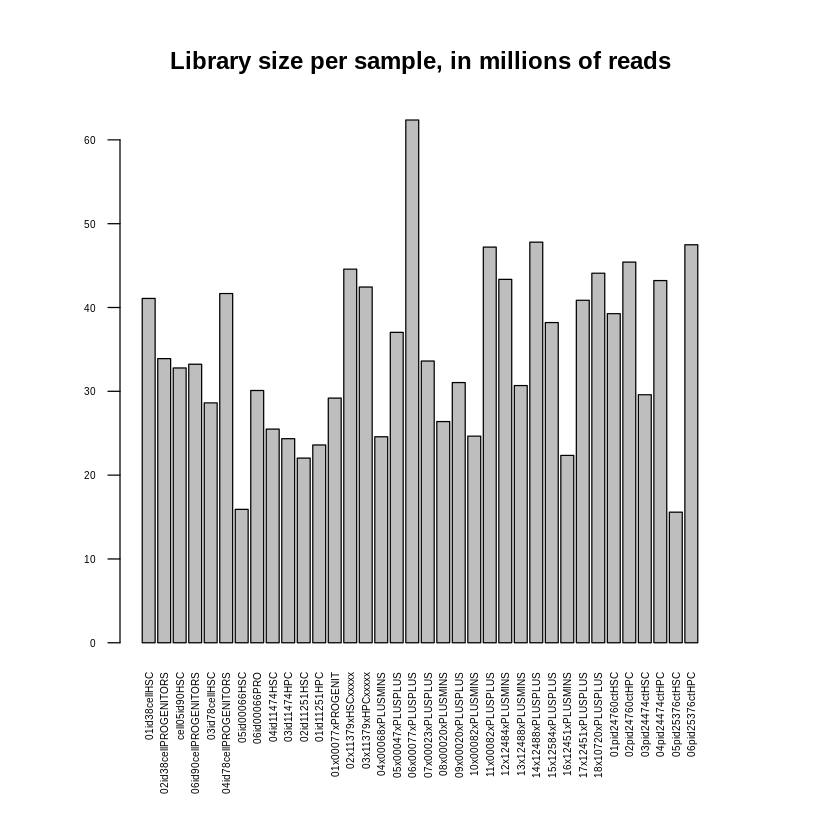

In [10]:
#Plot library size in millions of reads for each sample
par(mar=c(8,5,5,5), cex.axis=0.5)
options(scipen=-1)
barplot(gDgeList$samples$lib.size/1000000, horiz=F, names.arg=colnames(gDgeList$counts), las=2,
       main="Library size per sample, in millions of reads")
table(gDgeList$samples$group, gDgeList$samples$Cell.type)


AdultAML   PedAML    PedNL 
       5        9        6 

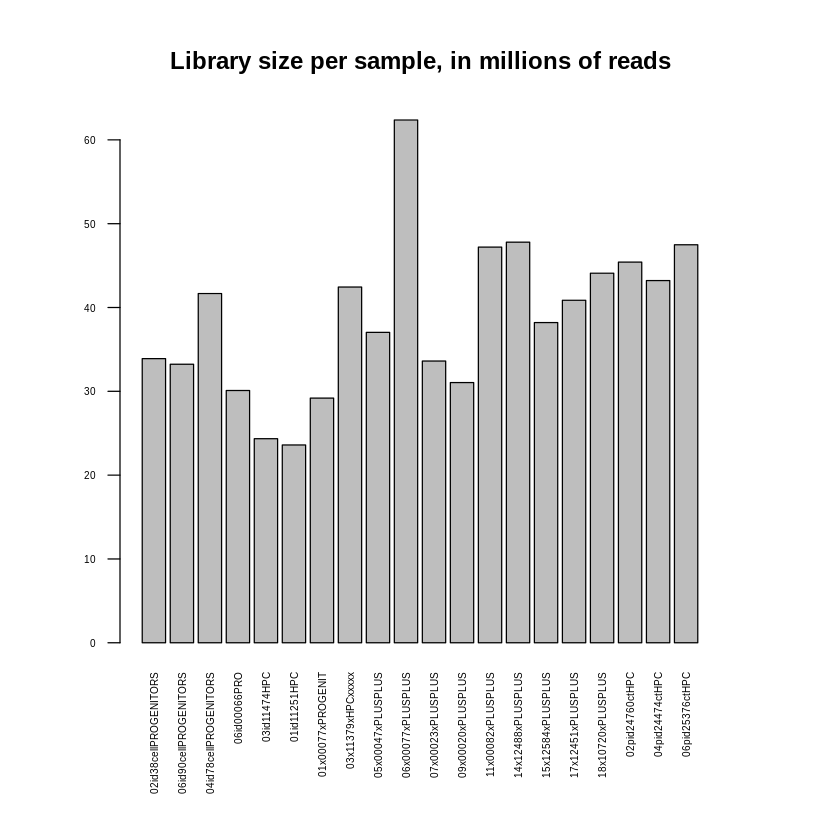

In [10]:
#Plot library size in millions of reads for each sample
par(mar=c(8,5,5,5), cex.axis=0.5)
options(scipen=-1)
barplot(gDgeList.prog$samples$lib.size/1000000, horiz=F, names.arg=colnames(gDgeList.prog$counts), las=2,
       main="Library size per sample, in millions of reads")
table(gDgeList.prog$samples$group)


AdultAML   PedAML    PedNL 
       4        9        3 

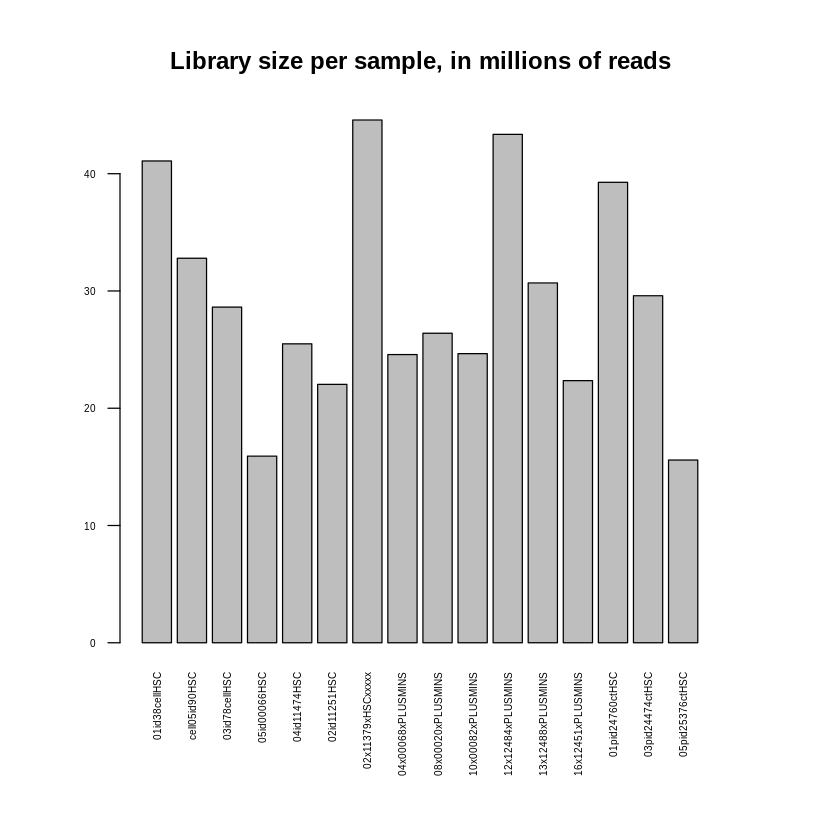

In [11]:
#Plot library size in millions of reads for each sample
par(mar=c(8,5,5,5), cex.axis=0.5)
options(scipen=-1)
barplot(gDgeList.stem$samples$lib.size/1000000, horiz=F, names.arg=colnames(gDgeList.stem$counts), las=2,
       main="Library size per sample, in millions of reads")
table(gDgeList.stem$samples$group)

### Removal of Low-Alignment Samples

    
> Since all samples have > 10 million aligned reads, all of them remain in the dataset after filtering out any low-aligned samples.


### Raw Counts Visualization

Next, perform and examine a principal components analysis of the **raw** data:

In [10]:
doRawCountsPca = function (dgeList, sampleNameMetadataCol, shapeMetadataCol, labelsMetadataCol, 
                           labelOnlyOutliers = FALSE) {
    makeAndPrintRawCountsPca(data.frame(dgeList$counts, check.names = FALSE), 
        dgeList$samples, shapeMetadataCol, sampleNameMetadataCol, 
        designColNameForLabels = labelsMetadataCol, labelOnlyOutliers = labelOnlyOutliers)
}

In [12]:
colnames(gDgeList$samples)
colnames(gDgeList.stem$samples)
colnames(gDgeList.stem$samples)
head(gDgeList.prog$samples)

[1] "group"            "lib.size"         "norm.factors"     "SequenceRun"     
 [5] "SequenceDate"     "Sample"           "SampleName"       "Patient.ID"      
 [9] "RIN"              "X"                "Adult.Pediatric"  "Disease"         
[13] "Cell.type"        "Sorted.Cell.Type" "Tissue.Source"    "RNA.seq.status"  
[17] "Reads"

[1] "group"            "lib.size"         "norm.factors"     "SequenceRun"     
 [5] "SequenceDate"     "Sample"           "SampleName"       "Patient.ID"      
 [9] "RIN"              "X"                "Adult.Pediatric"  "Disease"         
[13] "Cell.type"        "Sorted.Cell.Type" "Tissue.Source"    "RNA.seq.status"  
[17] "Reads"

[1] "group"            "lib.size"         "norm.factors"     "SequenceRun"     
 [5] "SequenceDate"     "Sample"           "SampleName"       "Patient.ID"      
 [9] "RIN"              "X"                "Adult.Pediatric"  "Disease"         
[13] "Cell.type"        "Sorted.Cell.Type" "Tissue.Source"    "RNA.seq.status"  
[17] "Reads"

,group,lib.size,norm.factors,SequenceRun,SequenceDate,Sample,SampleName,Patient.ID,RIN,X,Adult.Pediatric,Disease,Cell.type,Sorted.Cell.Type,Tissue.Source,RNA.seq.status,Reads
,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
02id38cellPROGENITORS,PedAML,33900321,1,ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91,5/5/19,02id38cellPROGENITORS,38 Progenitors,32538,9.7,PedAML,Pediatric,AML,Prog,34+38+,PB,Completed,73196851
06id90cellPROGENITORS,PedAML,33228834,1,ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91,5/5/19,06id90cellPROGENITORS,90 Progenitors,22390,10.0,PedAML,Pediatric,AML,Prog,34+38+,BM,Completed,81721991
04id78cellPROGENITORS,PedAML,41665738,1,ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91,5/5/19,04id78cellPROGENITORS,78 Progenitors,28678,10.0,PedAML,Pediatric,AML,Prog,34+38+,PB,Completed,88894032
06id00066PRO,PedAML,30096534,1,ca_ne_618_001_400_070_JAMIESON_SR_human-ensembl-ghrc38-r91,6/26/19,06id00066PRO,66 Progenitors,22666,9.8,PedAML,Pediatric,AML,Prog,34+38+,BM,Completed,77343883
03id11474HPC,AdultAML,24344437,1,ca_ne_618_001_400_070_JAMIESON_SR_human-ensembl-ghrc38-r91,6/26/19,03id11474HPC,11474 HPC,11474,9.6,AdultAML,Adult,AML,Prog,34+38+,PB,Completed,79871449
01id11251HPC,AdultAML,23597968,1,ca_ne_618_001_400_070_JAMIESON_SR_human-ensembl-ghrc38-r91,6/26/19,01id11251HPC,11251 HPC,11251,9.3,AdultAML,Adult,AML,Prog,34+38+,BM,Completed,80917720


In [15]:
gSampleColName = "Sample"

PCA of Raw Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
Standard deviation,71.13579,40.87222,34.86647,33.80014,31.73322,28.20341,25.40101,23.79989,22.65693,21.64131,⋯,13.05153,12.83203,12.27826,11.56442,10.77888,9.402498,9.157997,8.491483,8.275238,3.159064e-14
Proportion of Variance,0.26931,0.08891,0.06470,0.06080,0.05359,0.04233,0.03434,0.03015,0.02732,0.02493,⋯,0.00907,0.00876,0.00802,0.00712,0.00618,0.004710,0.004460,0.003840,0.003640,0.000000e+00
Cumulative Proportion,0.26931,0.35821,0.42291,0.48371,0.53730,0.57964,0.61398,0.64412,0.67144,0.69637,⋯,0.95326,0.96203,0.97005,0.97717,0.98335,0.988050,0.992520,0.996360,1.000000,1.000000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


PCA of Raw Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
Standard deviation,71.13579,40.87222,34.86647,33.80014,31.73322,28.20341,25.40101,23.79989,22.65693,21.64131,⋯,13.05153,12.83203,12.27826,11.56442,10.77888,9.402498,9.157997,8.491483,8.275238,3.159064e-14
Proportion of Variance,0.26931,0.08891,0.06470,0.06080,0.05359,0.04233,0.03434,0.03015,0.02732,0.02493,⋯,0.00907,0.00876,0.00802,0.00712,0.00618,0.004710,0.004460,0.003840,0.003640,0.000000e+00
Cumulative Proportion,0.26931,0.35821,0.42291,0.48371,0.53730,0.57964,0.61398,0.64412,0.67144,0.69637,⋯,0.95326,0.96203,0.97005,0.97717,0.98335,0.988050,0.992520,0.996360,1.000000,1.000000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


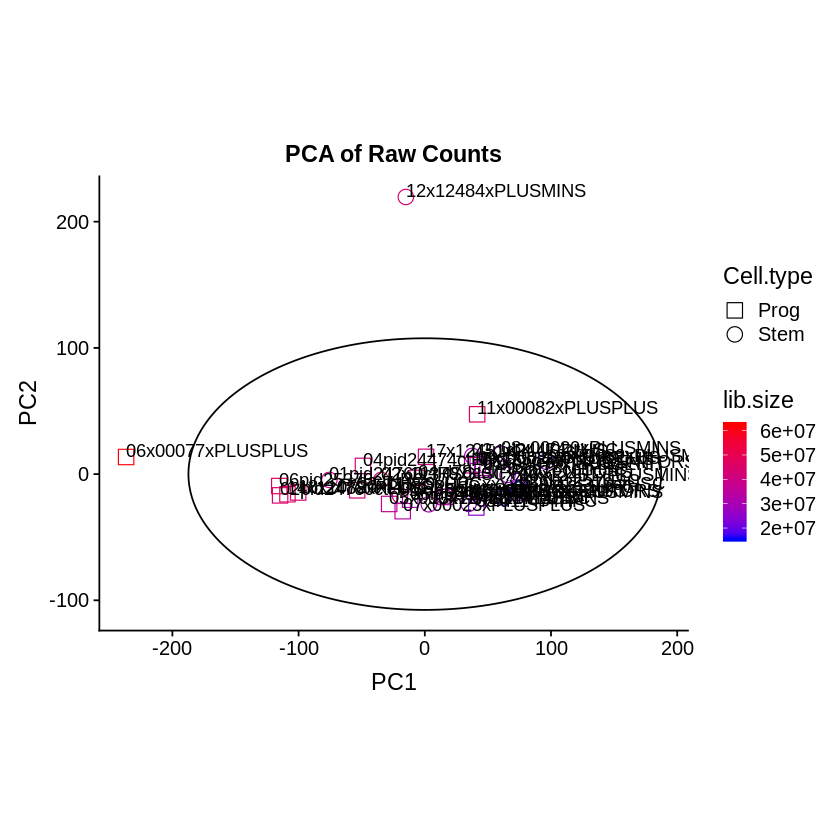

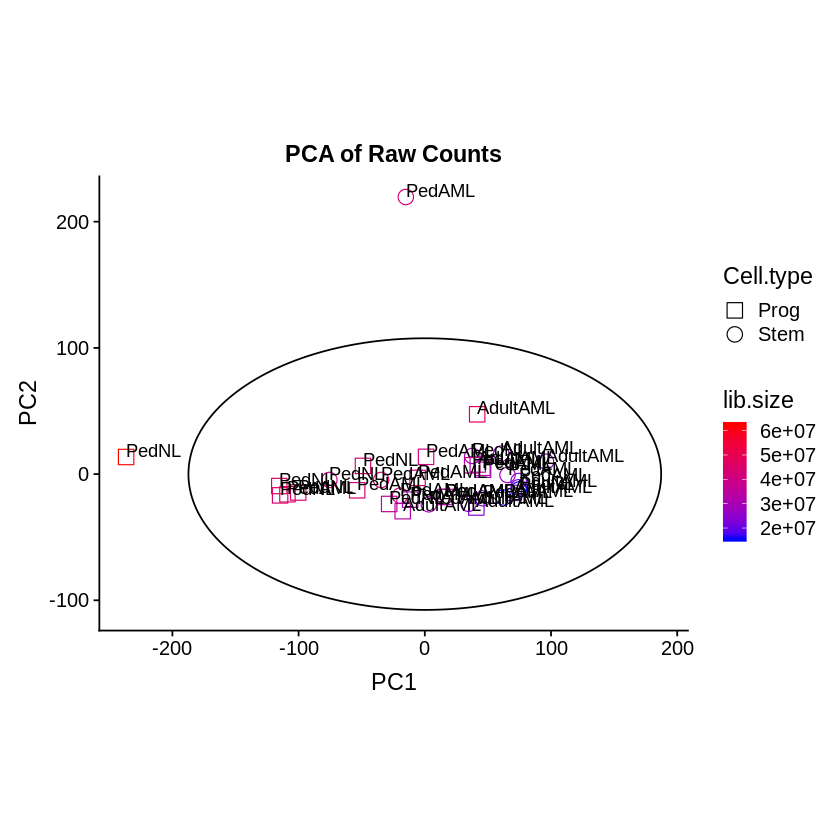

In [15]:
doRawCountsPca(gDgeList, gSampleColName, "Cell.type", "Sample")
doRawCountsPca(gDgeList, gSampleColName, "Cell.type", "group")

PCA of Raw Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
Standard deviation,71.13579,40.87222,34.86647,33.80014,31.73322,28.20341,25.40101,23.79989,22.65693,21.64131,⋯,13.05153,12.83203,12.27826,11.56442,10.77888,9.402498,9.157997,8.491483,8.275238,3.159064e-14
Proportion of Variance,0.26931,0.08891,0.06470,0.06080,0.05359,0.04233,0.03434,0.03015,0.02732,0.02493,⋯,0.00907,0.00876,0.00802,0.00712,0.00618,0.004710,0.004460,0.003840,0.003640,0.000000e+00
Cumulative Proportion,0.26931,0.35821,0.42291,0.48371,0.53730,0.57964,0.61398,0.64412,0.67144,0.69637,⋯,0.95326,0.96203,0.97005,0.97717,0.98335,0.988050,0.992520,0.996360,1.000000,1.000000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


PCA of Raw Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
Standard deviation,71.13579,40.87222,34.86647,33.80014,31.73322,28.20341,25.40101,23.79989,22.65693,21.64131,⋯,13.05153,12.83203,12.27826,11.56442,10.77888,9.402498,9.157997,8.491483,8.275238,3.159064e-14
Proportion of Variance,0.26931,0.08891,0.06470,0.06080,0.05359,0.04233,0.03434,0.03015,0.02732,0.02493,⋯,0.00907,0.00876,0.00802,0.00712,0.00618,0.004710,0.004460,0.003840,0.003640,0.000000e+00
Cumulative Proportion,0.26931,0.35821,0.42291,0.48371,0.53730,0.57964,0.61398,0.64412,0.67144,0.69637,⋯,0.95326,0.96203,0.97005,0.97717,0.98335,0.988050,0.992520,0.996360,1.000000,1.000000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


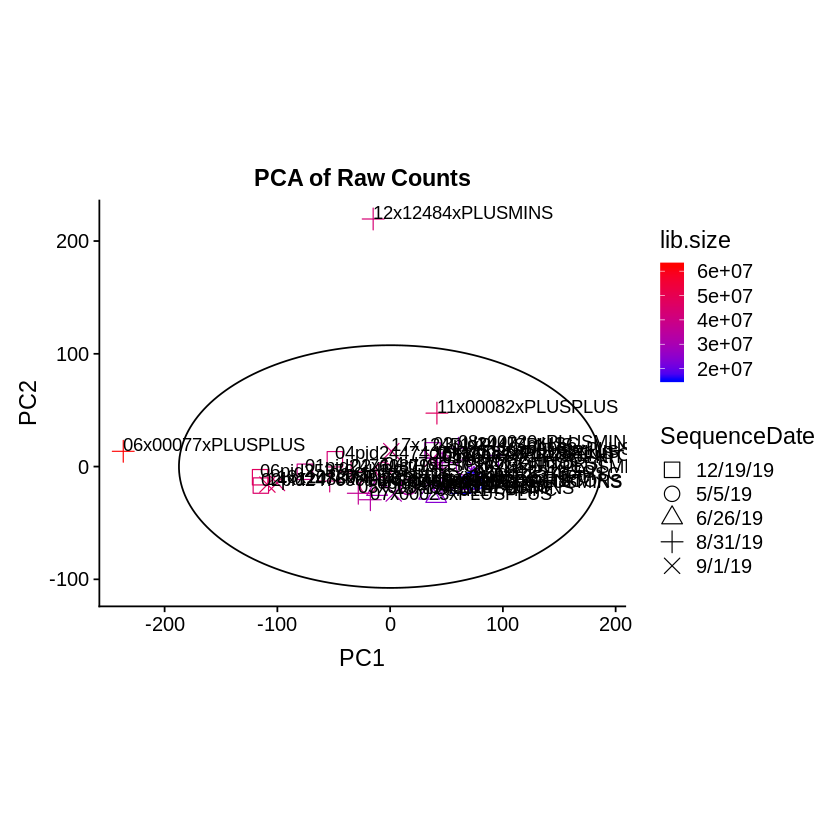

PCA of Raw Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
Standard deviation,71.13579,40.87222,34.86647,33.80014,31.73322,28.20341,25.40101,23.79989,22.65693,21.64131,⋯,13.05153,12.83203,12.27826,11.56442,10.77888,9.402498,9.157997,8.491483,8.275238,3.159064e-14
Proportion of Variance,0.26931,0.08891,0.06470,0.06080,0.05359,0.04233,0.03434,0.03015,0.02732,0.02493,⋯,0.00907,0.00876,0.00802,0.00712,0.00618,0.004710,0.004460,0.003840,0.003640,0.000000e+00
Cumulative Proportion,0.26931,0.35821,0.42291,0.48371,0.53730,0.57964,0.61398,0.64412,0.67144,0.69637,⋯,0.95326,0.96203,0.97005,0.97717,0.98335,0.988050,0.992520,0.996360,1.000000,1.000000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


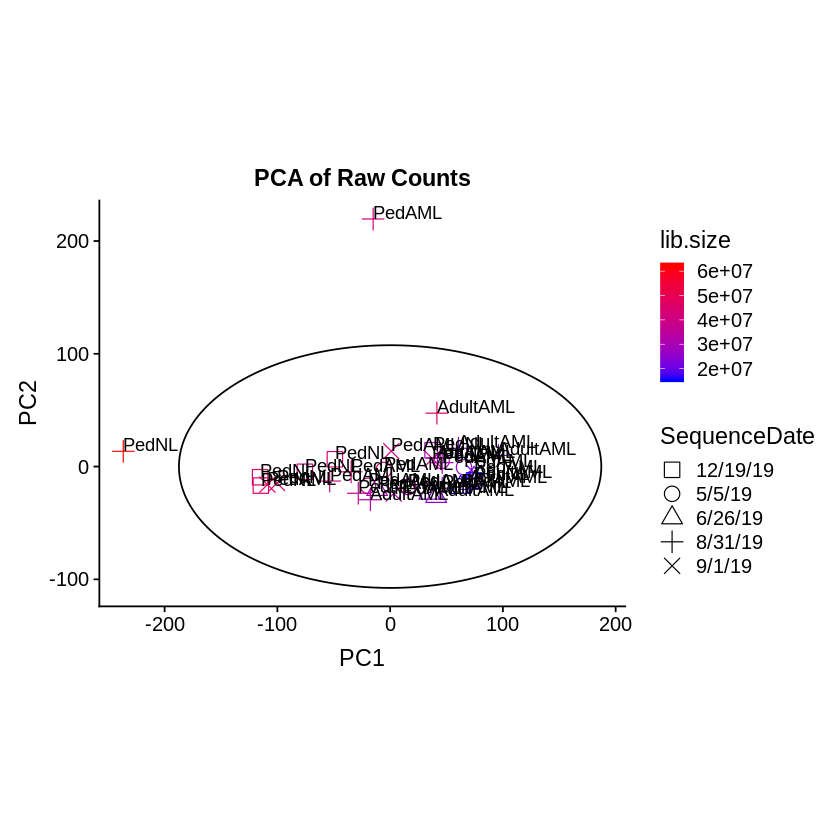

PCA of Raw Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
Standard deviation,77.32431,41.28275,37.28790,34.07973,31.19395,29.74217,28.12428,26.83648,26.11765,24.97531,22.87100,21.91213,20.96685,20.49708,19.02862,18.07813,17.52546,16.29091,14.75587,1.24339e-14
Proportion of Variance,0.32758,0.09337,0.07618,0.06363,0.05331,0.04847,0.04334,0.03946,0.03737,0.03418,0.02866,0.02631,0.02409,0.02302,0.01984,0.01791,0.01683,0.01454,0.01193,0.00000e+00
Cumulative Proportion,0.32758,0.42096,0.49713,0.56077,0.61408,0.66255,0.70588,0.74534,0.78271,0.81689,0.84555,0.87185,0.89594,0.91896,0.93880,0.95670,0.97353,0.98807,1.00000,1.00000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


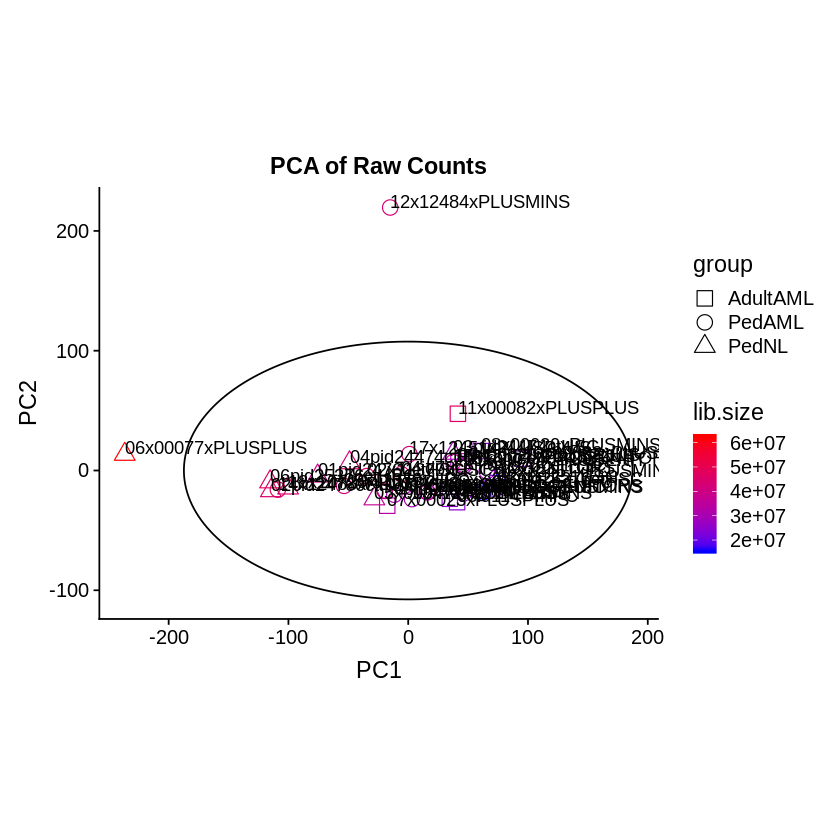

PCA of Raw Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
Standard deviation,65.13558,52.65563,42.44890,39.04788,35.93321,33.29890,29.28266,27.55046,26.78063,26.01237,23.70685,22.50560,21.97484,18.90591,17.54685,1.038993e-14
Proportion of Variance,0.23611,0.15430,0.10028,0.08485,0.07186,0.06171,0.04772,0.04224,0.03991,0.03766,0.03128,0.02819,0.02687,0.01989,0.01713,0.000000e+00
Cumulative Proportion,0.23611,0.39041,0.49069,0.57554,0.64740,0.70911,0.75683,0.79907,0.83898,0.87664,0.90791,0.93610,0.96297,0.98287,1.00000,1.000000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


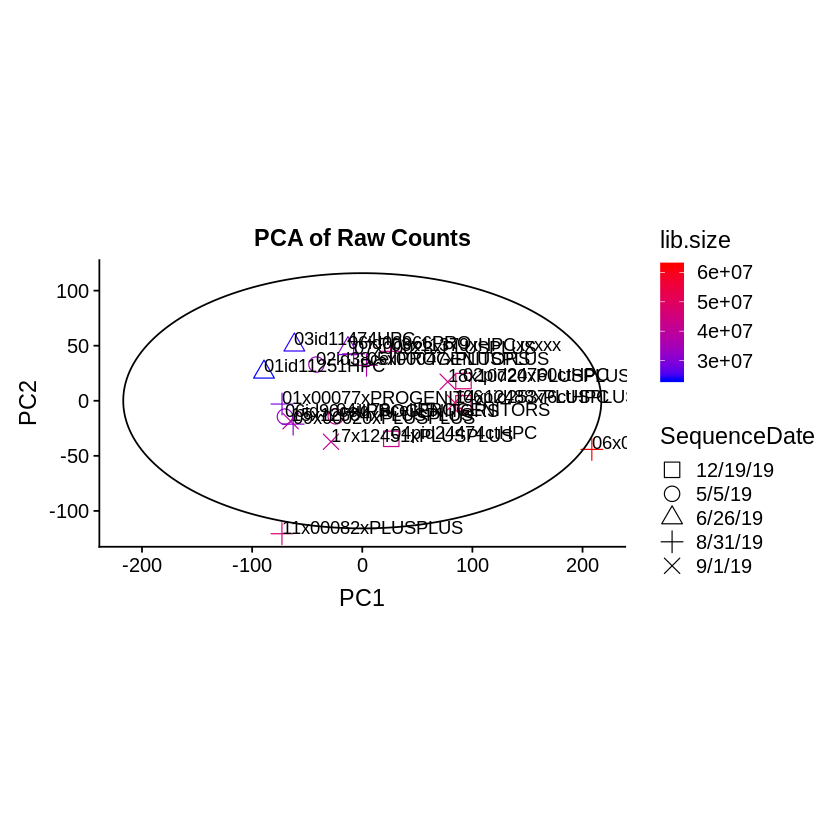

PCA of Raw Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
Standard deviation,77.32431,41.28275,37.28790,34.07973,31.19395,29.74217,28.12428,26.83648,26.11765,24.97531,22.87100,21.91213,20.96685,20.49708,19.02862,18.07813,17.52546,16.29091,14.75587,1.24339e-14
Proportion of Variance,0.32758,0.09337,0.07618,0.06363,0.05331,0.04847,0.04334,0.03946,0.03737,0.03418,0.02866,0.02631,0.02409,0.02302,0.01984,0.01791,0.01683,0.01454,0.01193,0.00000e+00
Cumulative Proportion,0.32758,0.42096,0.49713,0.56077,0.61408,0.66255,0.70588,0.74534,0.78271,0.81689,0.84555,0.87185,0.89594,0.91896,0.93880,0.95670,0.97353,0.98807,1.00000,1.00000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


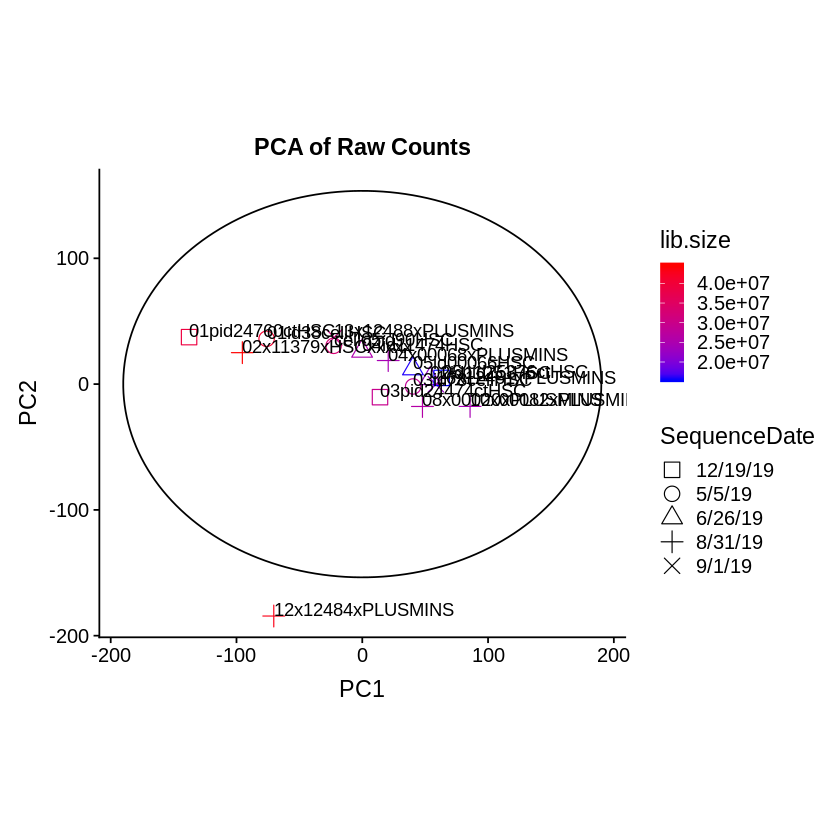

PCA of Raw Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
Standard deviation,65.13558,52.65563,42.44890,39.04788,35.93321,33.29890,29.28266,27.55046,26.78063,26.01237,23.70685,22.50560,21.97484,18.90591,17.54685,1.038993e-14
Proportion of Variance,0.23611,0.15430,0.10028,0.08485,0.07186,0.06171,0.04772,0.04224,0.03991,0.03766,0.03128,0.02819,0.02687,0.01989,0.01713,0.000000e+00
Cumulative Proportion,0.23611,0.39041,0.49069,0.57554,0.64740,0.70911,0.75683,0.79907,0.83898,0.87664,0.90791,0.93610,0.96297,0.98287,1.00000,1.000000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


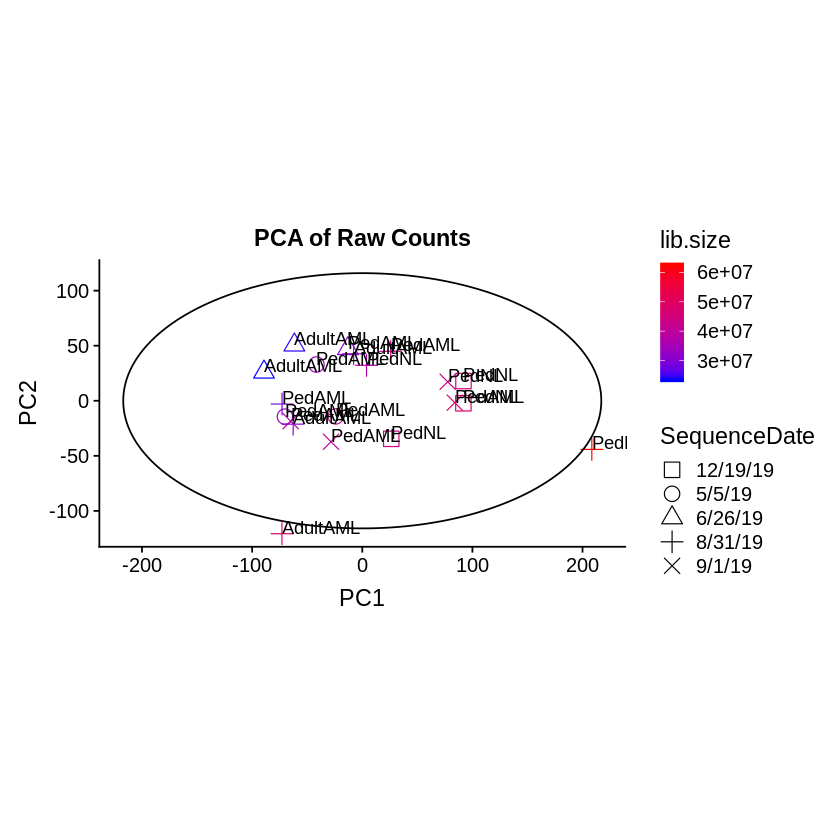

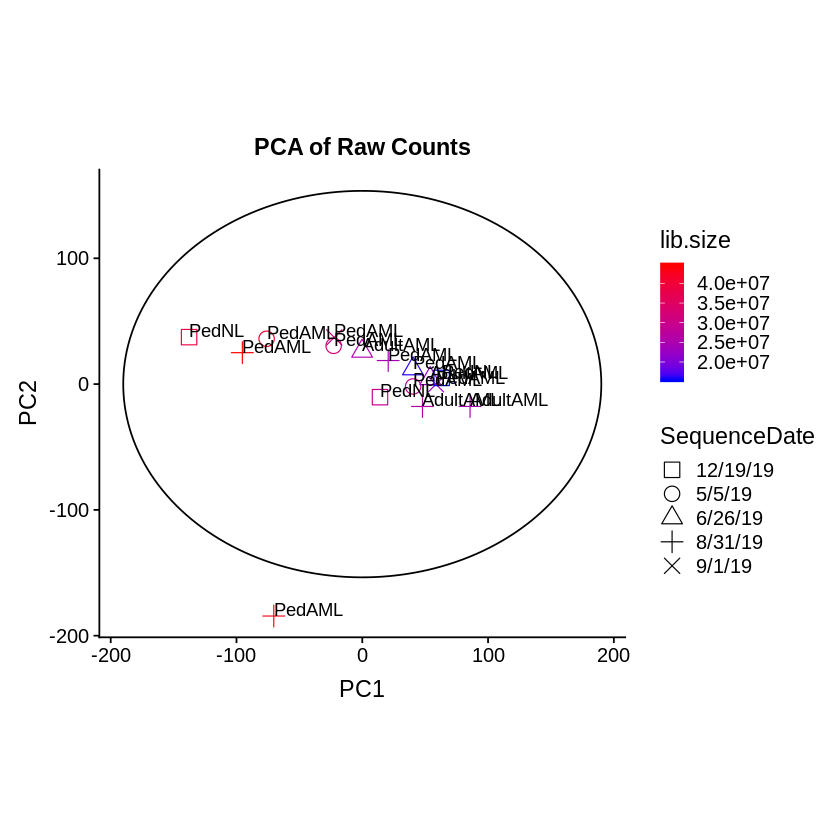

In [12]:
doRawCountsPca(gDgeList, gSampleColName, "SequenceDate", "Sample")
doRawCountsPca(gDgeList, gSampleColName, "SequenceDate", "group")
doRawCountsPca(gDgeList, gSampleColName, "group", "Sample")
doRawCountsPca(gDgeList.prog, gSampleColName, "SequenceDate", "Sample")
doRawCountsPca(gDgeList.stem, gSampleColName, "SequenceDate", "Sample")
doRawCountsPca(gDgeList.prog, gSampleColName, "SequenceDate", "group")
doRawCountsPca(gDgeList.stem, gSampleColName, "SequenceDate", "group")

   > This indicates that even before normalization, the primary variance in the data (approximately 35%) separates the samples in a way consistent with Age (i.e. Pediatric and Adult).  This is encouraging!
   


Examine how many genes are missing from the reads found in samples (those for which it is TRUE that they are NOT expressed in any sample):

In [227]:
table(rowSums(gDgeList.prog$counts==0)==nrow(gDgeList.prog$samples))
table(rowSums(gDgeList.stem$counts==0)==nrow(gDgeList.stem$samples))


FALSE  TRUE 
18252  2093 


FALSE  TRUE 
17969  2376 

    
   > Approximately 2100 of the genes in the dataset are missing from reads found in progenitor samples (that is, not found to be expressed in any of the samples). Approximately 2300 of the genes in the dataset are missing from reads found in stem cell samples (that is, not found to be expressed in any of the samples). 



[Table of Contents](#Table-of-Contents)

## Pre-Processing

### Scale Transformation and Lowly-Expressed Genes Filtration

> For differential expression and related analyses, gene expression is rarely considered at the level of raw counts since libraries sequenced at a greater depth will result in higher counts. Rather, it is common practice to transform raw counts onto a scale that accounts for such library size differences. Popular transformations include counts per million (CPM), log2-counts per million (log-CPM), reads per kilobase of transcript per million (RPKM), and fragments per kilobase of transcript per million (FPKM).
>
> In our analyses, CPM and log-CPM transformations are used regularly although they do not account for feature length differences which RPKM and FPKM values do. Whilst RPKM and FPKM values can just as well be used, CPM and log-CPM values can be calculated using a counts matrix alone and will suffice for the type of comparisons we are interested in. Assuming that there are no differences in isoform usage between conditions, differential expression analyses look at gene expression changes between conditions rather than comparing expression across multiple genes or drawing conclusions on absolute levels of expression. In other words, gene lengths remain constant for comparisons of interest and any observed differences are a result of changes in condition rather than changes in gene length.
>
> Here raw counts are converted to CPM and log-CPM values using the cpm function in edgeR, where log-transformations use a prior count of 0.25 to avoid taking the log of zero. RPKM values are just as easily calculated as CPM values using the rpkm function in edgeR if gene lengths are available. ([1](#Citations))

Also, regarding lowly expressed genes:

> All datasets will include a mix of genes that are expressed and those that are not expressed. Whilst it is of interest to examine genes that are expressed in one condition but not in another, some genes are unexpressed throughout all samples....
>
> Genes that are not expressed at a biologically meaningful level in any condition should be discarded to reduce the subset of genes to those that are of interest, and to reduce the number of tests carried out downstream when looking at differential expression. Upon examination of log-CPM values, it can be seen that a large proportion of genes within each sample is unexpressed or lowly-expressed .... Using a nominal CPM value of 1 (which is equivalent to a log-CPM value of 0) genes are deemed to be expressed if their expression is above this threshold, and unexpressed otherwise. Genes must be expressed in at least one group (or in at least [a minimum number of] samples across the entire experiment) to be kept for downstream analysis.
>
> Although any sensible value can be used as the expression cutoff, typically a CPM value of 1 is used in our analyses as it separates expressed genes from unexpressed genes well for most datasets. ... If sequence reads are summarised by exons rather than genes and/or experiments have low sequencing depth, a lower CPM cutoff may be considered. ([1](#Citations))

A filtration threshold of 1 CPM (counts per million) means a gene is considered expressed if it has more than the below number of counts in the sample with the lowest sequencing depth:

In [14]:
# the smallest library size, in millions
min(round(gDgeList$samples$lib.size))/1000000
min(round(gDgeList.prog$samples$lib.size))/1000000
min(round(gDgeList.stem$samples$lib.size))/1000000

[1] 15.58424

[1] 23.59797

[1] 15.58424

In [59]:
min(round(gDgeList.prog.merge$samples$lib.size))/1000000
min(round(gDgeList.stem.merge$samples$lib.size))/1000000

[1] 15.55652

[1] 8.323686

Likewise, a filtration threshold of 1 CPM (counts per million) means a gene is considered expressed if it has more than the below number of counts in the sample with the greatest sequencing depth:

In [15]:
# the largest library size, in millions
max(round(gDgeList$samples$lib.size))/1000000
max(round(gDgeList.prog$samples$lib.size))/1000000
max(round(gDgeList.stem$samples$lib.size))/1000000

[1] 62.37015

[1] 62.37015

[1] 44.57864

In [60]:
max(round(gDgeList.prog.merge$samples$lib.size))/1000000
max(round(gDgeList.stem.merge$samples$lib.size))/1000000

[1] 62.37015

[1] 64.86988

    
   > These values seem reasonable, given the library sizes, so a CPM threshold of 1 is selected.



    
   > Genes having a CPM of greater than 1 for greater than or equal to 3 samples will be retained for further analysis, while all others will be discarded.



In [101]:
# NB: this must be re-selected each time a new analysis is run
# to ensure these values are appropriate to the data
gMinExclusiveCpms = 3
gMinInclusiveNumSamples = 35

In [62]:
filterDgeListByCpmThresholdForNumSamples = function(aDgeList, minExclusiveCpms, minInclusiveNumSamples){
    cpmsMatrix = cpm(aDgeList)
    keepMask = rowSums(cpmsMatrix>minExclusiveCpms)>=minInclusiveNumSamples
    filteredDgeList = aDgeList[keepMask,, keep.lib.sizes=FALSE]
    return(filteredDgeList)
}

plotLogCpmDensityPrePostFiltering = function(unfilteredDgeList, filteredDgeList, minExclusiveCpmThreshold){
    library(RColorBrewer)
    
    logMinExclusiveCpmThreshold = log(minExclusiveCpmThreshold)
    nsamples <- ncol(unfilteredDgeList)
    unfilteredLogCpmsMatrix = cpm(unfilteredDgeList, log=TRUE)
    col <- brewer.pal(nsamples, "Paired")
    par(mfrow=c(1,2))
    plot(density(unfilteredLogCpmsMatrix[,1]), col=col[1], lwd=2, ylim=c(0,0.21), las=2, 
         main="", xlab="")
    title(main="A. Raw data", xlab="Log-CPM")
    abline(v=logMinExclusiveCpmThreshold, lty=3)
    for (i in 2:nsamples){
     den <- density(unfilteredLogCpmsMatrix[,i])
     lines(den$x, den$y, col=col[i], lwd=2)
    }
    #legend("topright", colnames(x), text.col=col, bty="n")
    filteredLogCpmsMatrix = cpm(filteredDgeList, log=TRUE)
    plot(density(filteredLogCpmsMatrix[,1]), col=col[1], lwd=2, ylim=c(0,0.21), las=2, 
         main="", xlab="")
    title(main="B. Filtered data", xlab="Log-CPM")
    abline(v=logMinExclusiveCpmThreshold, lty=3)
    for (i in 2:nsamples){
       den <- density(filteredLogCpmsMatrix[,i])
       lines(den$x, den$y, col=col[i], lwd=2)
    }
}

In [56]:
mean(ratio.df.prog$AlignRatio)
sd(ratio.df.prog$AlignRatio)
mean(ratio.df.prog$AlignRatio) - (2*sd(ratio.df.prog$AlignRatio))
cut.prog <- mean(ratio.df.prog$AlignRatio) - (2*sd(ratio.df.prog$AlignRatio))
table(ratio.df.prog$AlignRatio < cut.prog)
mean(ratio.df.stem$AlignRatio)
sd(ratio.df.stem$AlignRatio)
mean(ratio.df.stem$AlignRatio) - (2*sd(ratio.df.stem$AlignRatio))
cut.stem <- mean(ratio.df.stem$AlignRatio) - (2*sd(ratio.df.stem$AlignRatio))
table(ratio.df.stem$AlignRatio < cut.stem)
ratio.df

[1] 0.4249

[1] 0.0719502

[1] 0.2809996


FALSE 
   20 

[1] 0.3828125

[1] 0.08330444

[1] 0.2162036


FALSE  TRUE 
   15     1 

Patient.ID,lib.size,Reads,Cell.type,AlignRatio
<fct>,<dbl>,<dbl>,<fct>,<dbl>
01id38cellHSC,41053037,81234305,Stem,0.505
02id38cellPROGENITORS,33880305,73196851,Prog,0.463
cell05id90HSC,32756184,72625632,Stem,0.451
06id90cellPROGENITORS,33202985,81721991,Prog,0.406
03id78cellHSC,28605524,68483294,Stem,0.418
04id78cellPROGENITORS,41632102,88894032,Prog,0.468
05id00066HSC,15897883,77519907,Stem,0.205
06id00066PRO,30068212,77343883,Prog,0.389
04id11474HSC,25477749,79123032,Stem,0.322


[1] 36 17

[1] "07x00023xPLUSPLUS" "08x00020xPLUSMINS" "09x00020xPLUSPLUS"
[4] "10x00082xPLUSMINS" "11x00082xPLUSPLUS" "12x12484xPLUSMINS"

[1] 36 17

[1] 0.463 0.406 0.468 0.389 0.305 0.291 0.424 0.459 0.454 0.481 0.296 0.351
[13] 0.359 0.477 0.418 0.500 0.543 0.493 0.461 0.460

[1] 0.505 0.451 0.418 0.205 0.322 0.269 0.440 0.401 0.392 0.300 0.499 0.388
[13] 0.374 0.455 0.397 0.309

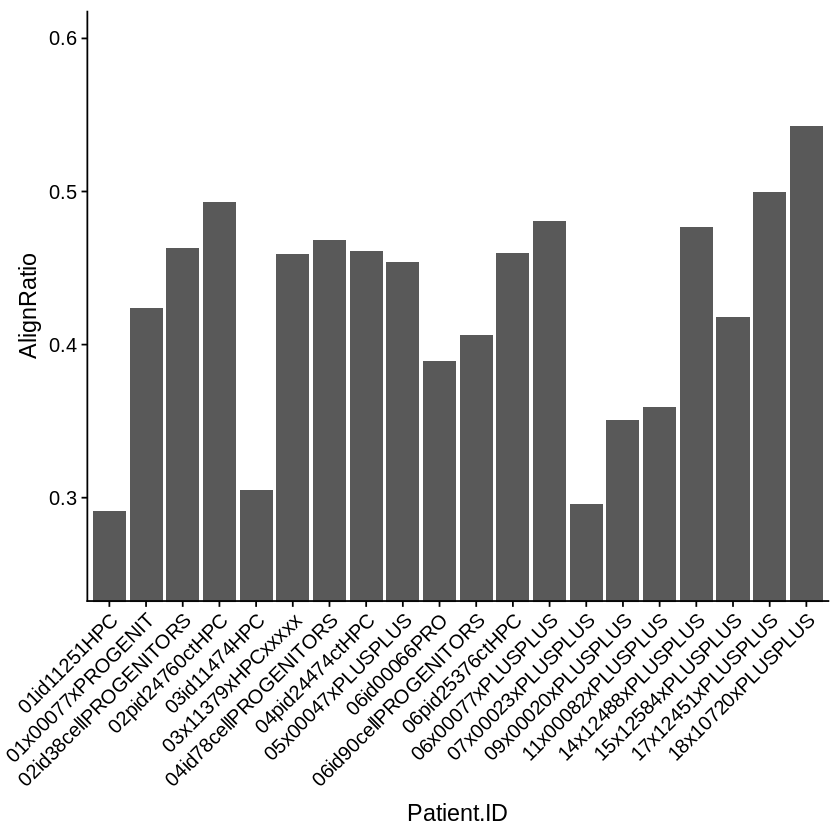

,Patient.ID,lib.size,Reads,Cell.type,AlignRatio
,<fct>,<dbl>,<dbl>,<fct>,<dbl>
2,02id38cellPROGENITORS,33880305,73196851,Prog,0.463
4,06id90cellPROGENITORS,33202985,81721991,Prog,0.406
6,04id78cellPROGENITORS,41632102,88894032,Prog,0.468
8,06id00066PRO,30068212,77343883,Prog,0.389
10,03id11474HPC,24327859,79871449,Prog,0.305
12,01id11251HPC,23583443,80917720,Prog,0.291
13,01x00077xPROGENIT,29159791,68810108,Prog,0.424
15,03x11379xHPCxxxxx,42376854,92324550,Prog,0.459
17,05x00047xPLUSPLUS,36975152,81377527,Prog,0.454


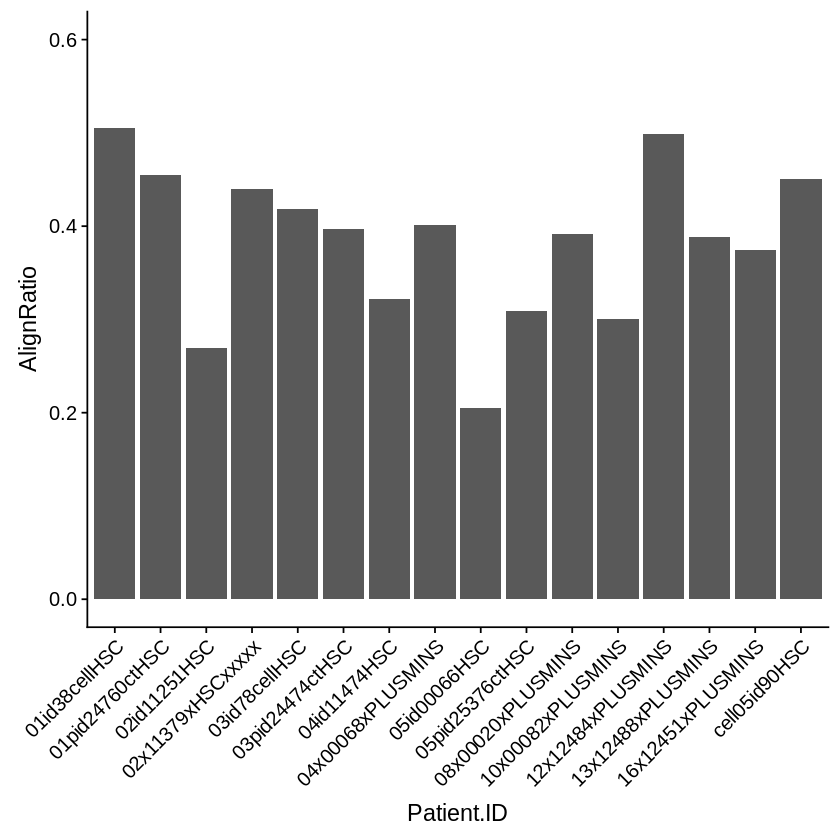

In [55]:
library(ggplot2)
#plot(gFilteredDgeList$samples$Sample, gFilteredDgeList$samples$Sample)
dim(gFilteredDgeList$samples)
gFilteredDgeList$samples$Sample[is.na(gFilteredDgeList$samples$Reads)]
gFilteredDgeList$samples$Reads[is.na(gFilteredDgeList$samples$Reads)] <- meta$Reads[match(gFilteredDgeList$samples$Sample[is.na(gFilteredDgeList$samples$Reads)], 
                                                                                          meta$Sample)]
tmpfilt <- gFilteredDgeList$samples[!is.na(gFilteredDgeList$samples$Reads),]
dim(tmpfilt)
ratio.df <- data.frame(Patient.ID=as.character(tmpfilt$Sample), lib.size=as.numeric(tmpfilt$lib.size),  
                                Reads=as.numeric(tmpfilt$Reads), Cell.type=tmpfilt$Cell.type, 
                                AlignRatio=round(as.numeric(tmpfilt$lib.size)/tmpfilt$Reads, 3))

ratio.df.prog <- subset(ratio.df, Cell.type=="Prog")
ratio.df.stem <- subset(ratio.df, Cell.type=="Stem")
ratio.df.prog$AlignRatio
ratio.df.stem$AlignRatio
#ggplot(ratio.df, aes(x=lib.size, y=Reads, col=Cell.type)) + geom_point()
#ggplot(ratio.df.prog, aes(x=lib.size, y=Reads, label=Patient.ID)) + geom_point() + geom_text(hjust=-0.5,vjust=1)
#ggplot(ratio.df.stem, aes(x=lib.size, y=Reads, label=Patient.ID)) + geom_point() + geom_text(hjust=-0.5,vjust=1)


ggplot(ratio.df.prog, aes(x=Patient.ID, y=AlignRatio)) + geom_col() + coord_cartesian(ylim=c(0.25,0.6)) +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
ggplot(ratio.df.stem, aes(x=Patient.ID, y=AlignRatio)) + geom_col() + coord_cartesian(ylim=c(0,0.6)) +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
ratio.df.prog
#gFilteredDgeList.prog$samples


In [46]:
gFilteredDgeList$samples[c("lib.size", "Reads")]

,lib.size,Reads
,<dbl>,<int>
01id38cellHSC,41053037,81234305
02id38cellPROGENITORS,33880305,73196851
cell05id90HSC,32756184,72625632
06id90cellPROGENITORS,33202985,81721991
03id78cellHSC,28605524,68483294
04id78cellPROGENITORS,41632102,88894032
05id00066HSC,15897883,77519907
06id00066PRO,30068212,77343883
04id11474HSC,25477749,79123032


In [12]:
gFilteredDgeList = filterDgeListByCpmThresholdForNumSamples(gDgeList, gMinExclusiveCpms, gMinInclusiveNumSamples)
gFilteredDgeList.prog = filterDgeListByCpmThresholdForNumSamples(gDgeList.prog, gMinExclusiveCpms, gMinInclusiveNumSamples)
gFilteredDgeList.stem = filterDgeListByCpmThresholdForNumSamples(gDgeList.stem, gMinExclusiveCpms, gMinInclusiveNumSamples)

In [102]:
gFilteredDgeList.prog.merge = filterDgeListByCpmThresholdForNumSamples(gDgeList.prog.merge, gMinExclusiveCpms, gMinInclusiveNumSamples)
gFilteredDgeList.stem.merge = filterDgeListByCpmThresholdForNumSamples(gDgeList.stem.merge, gMinExclusiveCpms, gMinInclusiveNumSamples)

"Note that subsetting the entire DGEList-object removes both the counts as well as the associated gene information." ([1](#Citations))

In [13]:
dim(gDgeList)
dim(gFilteredDgeList)
dim(gDgeList.prog)
dim(gFilteredDgeList.prog)
dim(gDgeList.stem)
dim(gFilteredDgeList.stem)

[1] 20345    36

[1] 12685    36

[1] 20345    20

[1] 12069    20

[1] 20345    16

[1] 11837    16

In [103]:
dim(gDgeList.prog.merge)
dim(gFilteredDgeList.prog.merge)
dim(gDgeList.stem.merge)
dim(gFilteredDgeList.stem.merge)

[1] 20345    86

[1] 11092    86

[1] 20345    63

[1] 10860    63

    
   > Discarding lowly expressed genes reduces the number of genes in the dataset from 20345 to 13209 in progenitors and 13333 in stem cells.



This removal changes the log-CPM density distribution of the dataset as shown below.

> The density of log-CPM values for raw pre-filtered data (A) and post-filtered data (B) are shown for each sample. Dotted vertical lines mark the **log**-CPM of the [CPM] threshold ... used in the filtering step. ([1](#Citations))


Warning message in brewer.pal(nsamples, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”Warning message in brewer.pal(nsamples, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”

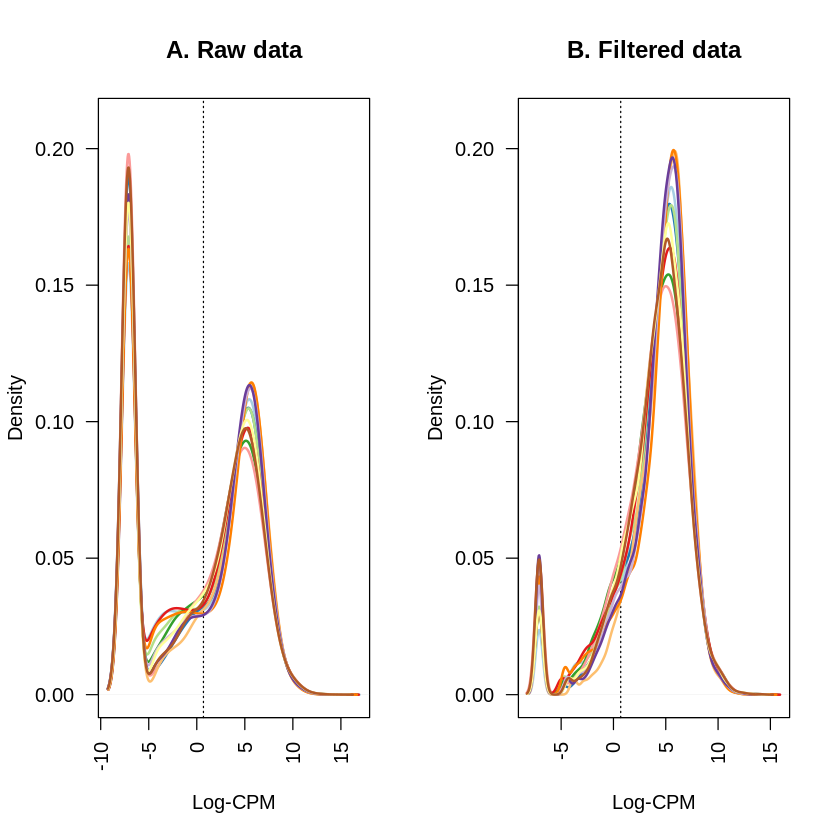

Warning message in brewer.pal(nsamples, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”

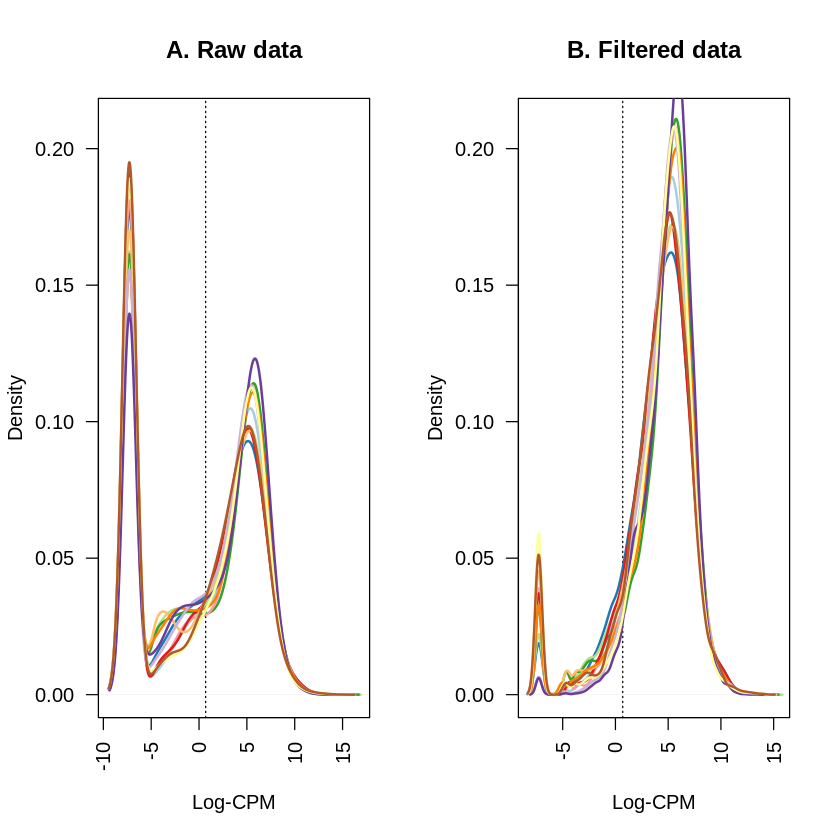

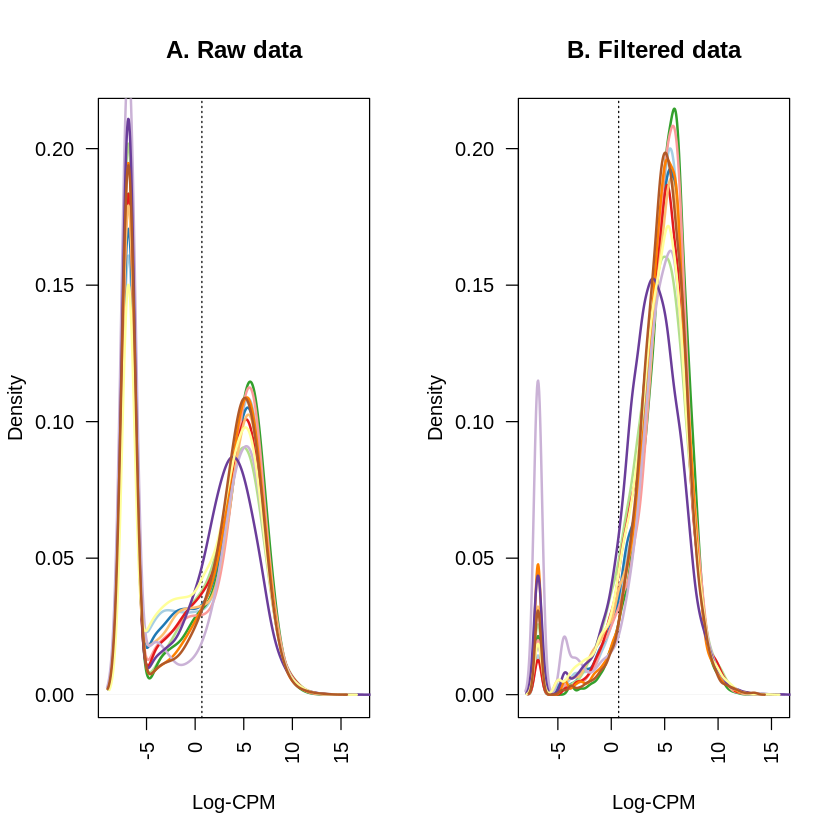

In [182]:
plotLogCpmDensityPrePostFiltering(gDgeList, gFilteredDgeList, gMinExclusiveCpms)
plotLogCpmDensityPrePostFiltering(gDgeList.prog, gFilteredDgeList.prog, gMinExclusiveCpms)
plotLogCpmDensityPrePostFiltering(gDgeList.stem, gFilteredDgeList.stem, gMinExclusiveCpms)

Warning message in brewer.pal(nsamples, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”
Warning message in brewer.pal(nsamples, "Paired"):
“n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
”


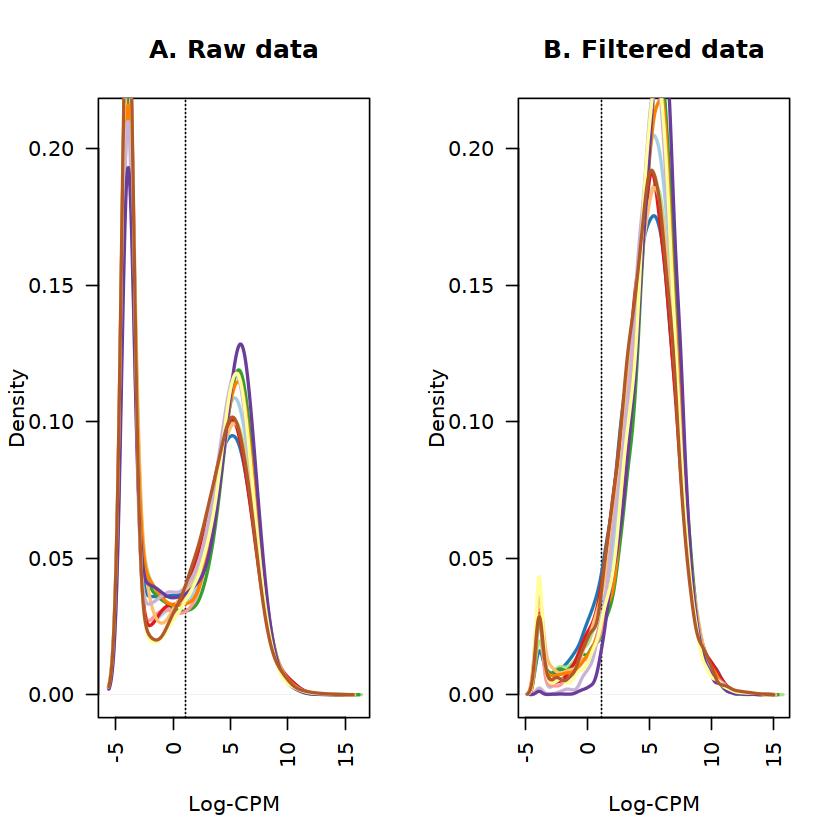

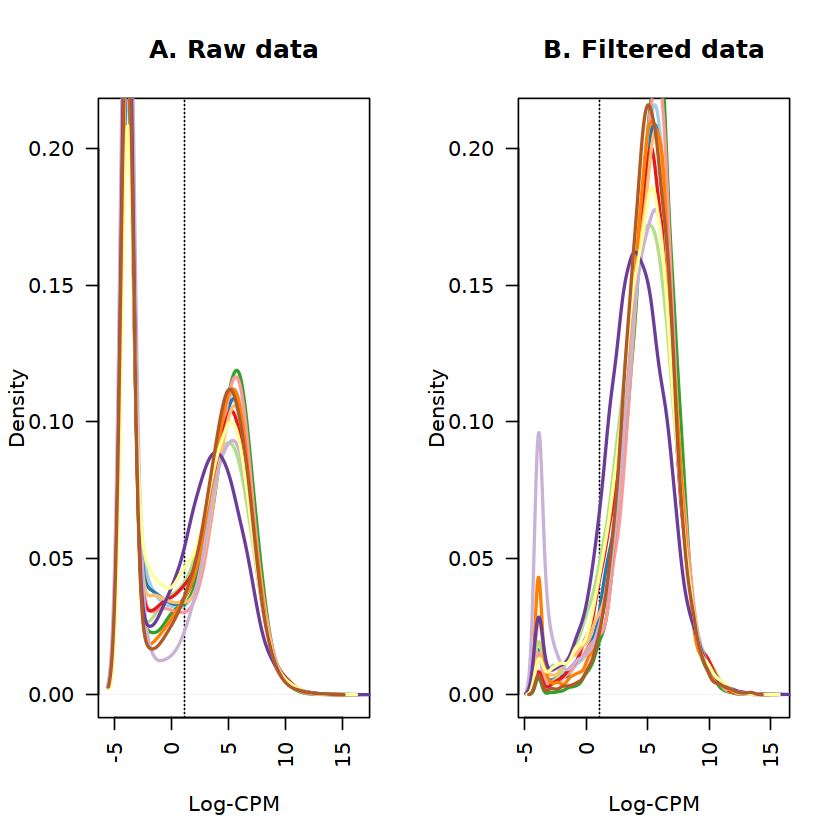

In [104]:
plotLogCpmDensityPrePostFiltering(gDgeList.prog.merge, gFilteredDgeList.prog.merge, gMinExclusiveCpms)
plotLogCpmDensityPrePostFiltering(gDgeList.stem.merge, gFilteredDgeList.stem.merge, gMinExclusiveCpms)

[Table of Contents](#Table-of-Contents)

### Normalization

> During the sample preparation or sequencing process, external factors that are not of biological interest can affect the expression of individual samples. For example, samples processed in the first batch of an experiment can have higher expression overall when compared to samples processed in a second batch. It is assumed that all samples should have a similar range and distribution of expression values. Normalisation is required to ensure that the expression distributions of each sample are similar across the entire experiment.
>
> Any plot showing the per sample expression distributions, such as a density [such as the log-CPM plot above] or boxplot, is useful in determining whether any samples are dissimilar to others. ([1](#Citations))

Note that normalization is generally applied even when no major per sample expression differences are evident.  It is useful to note that the normalization discussed here is distinct from that performed earlier when raw counts were normalized to counts per million:

> CPM "normalization" accounts for library size differences between samples, and produces normalized values that can be compared on an absolute scale (e.g., for filtering). TMM [see below] normalization accounts for composition bias, and computes normalization factors for comparing between libraries on a relative scale. CPM normalization doesn't account for composition bias, and TMM normalization doesn't produce normalized values. Thus, you need both steps in the analysis pipeline. This isn't a problem, as the two steps aren't really redundant. ([6](#Citations))

Thus, this normalization step accounts for differences in the composition of the RNA populations in different samples, whereas CPM normalization accounts for differences in library size. 

The most common normalizations applied to RNASeq data are TMM (Trimmed Mean of M-values) and RLE (Relative Log Expression, also frequently referred to as DESeq normalization).  Dillies et al 2013 ([7](#Citations)) report that these two methods (and only these two, of the seven normalization methods assessed) "are able to maintain a reasonable false-positive rate without any loss of power", and they find them largely interchangeable.  They also note:

> It is important to keep in mind that most normalization strategies (including DESeq and TMM) rely on the rather strong assumptions that most genes are not differentially expressed, and that for those differentially expressed there is an approximately balanced proportion of over- and under-expression .... Though these assumptions appear reasonable in many studies, including those considered here, there are experiments in which they are not met. Unfortunately, these assumptions are rarely checked in practice; in fact, it would be extremely difficult to do so.

With this in mind, we employ TMM ([8](#Citations)), which is the default for limma and edgeR analyses, unless we have pre-existing knowledge that the tested system is likely to contravene these assumptions.  

> [N]ormalisation by the method of trimmed mean of M-values (TMM) (Robinson and Oshlack 2010) is performed using the calcNormFactors function in edgeR. The normalisation factors calculated here are used as a scaling factor for the library sizes. When working with DGEList-objects, these normalisation factors are automatically stored in x\\$samples\$norm.factors. ([1](#Citations))

Normalize the data to remove effects of library sizes using the trimmed mean of M-values (TMM) approach:

### Removed outliers based on their library size and/or location in PCA plots
* 03id11474HPC
* 01id11251HPC
* 12x12484xPLUSMINS

In [67]:
gNonOutliersMask = c(TRUE, TRUE, TRUE, TRUE, TRUE, TRUE,TRUE, TRUE,TRUE, FALSE,TRUE, FALSE,TRUE, TRUE, TRUE, TRUE, TRUE, TRUE,
                    TRUE, TRUE, TRUE, TRUE, TRUE, FALSE,TRUE, TRUE,TRUE, TRUE,TRUE, TRUE,TRUE, TRUE, TRUE, TRUE, TRUE, TRUE)
gNonOutliersMask.prog = c(TRUE, TRUE, TRUE, TRUE, FALSE, FALSE, TRUE, TRUE,TRUE, TRUE,TRUE, TRUE,TRUE, TRUE, TRUE, TRUE, TRUE, TRUE,TRUE,TRUE)
gNonOutliersMask.stem = c(TRUE, TRUE, TRUE, TRUE, TRUE, TRUE,TRUE, TRUE,TRUE, TRUE,FALSE, TRUE,TRUE, TRUE, TRUE, TRUE)#

length(gFilteredDgeList$samples$lib.size)
sum(gNonOutliersMask==TRUE)
length(gFilteredDgeList.prog$samples$lib.size)
sum(gNonOutliersMask.prog==TRUE)
length(gFilteredDgeList.stem$samples$lib.size)
sum(gNonOutliersMask.stem==TRUE)

ERROR: Error in eval(expr, envir, enclos): object 'gFilteredDgeList' not found


In [105]:
gNonOutliersMask.prog.merge = c(TRUE, TRUE, TRUE, TRUE, FALSE, FALSE, TRUE, TRUE,TRUE, TRUE,TRUE, TRUE,TRUE, TRUE, TRUE, TRUE, TRUE, TRUE,TRUE,TRUE,
                               rep(TRUE, 66))
gNonOutliersMask.stem.merge= c(TRUE, TRUE, TRUE, TRUE, TRUE, TRUE,TRUE, TRUE,TRUE, TRUE,FALSE, TRUE,TRUE, TRUE, TRUE, TRUE,
                              rep(TRUE, 47))#

Apply the outlier removal filter:

In [21]:


gOrigFilteredDgeList = gFilteredDgeList[,gNonOutliersMask]
dim(gOrigFilteredDgeList)
table(gOrigFilteredDgeList$sample$group, gOrigFilteredDgeList$sample$Cell.type)
gOrigFilteredDgeList.prog = gFilteredDgeList.prog[,gNonOutliersMask.prog]
dim(gOrigFilteredDgeList.prog)
table(gOrigFilteredDgeList.prog$sample$group)
gOrigFilteredDgeList.stem = gFilteredDgeList.stem[,gNonOutliersMask.stem]
dim(gOrigFilteredDgeList.stem)
table(gOrigFilteredDgeList.stem$sample$group)

[1] 12685    33

          
           Prog Stem
  AdultAML    3    4
  PedAML      9    8
  PedNL       6    3

[1] 12069    18


AdultAML   PedAML    PedNL 
       3        9        6 

[1] 11837    15


AdultAML   PedAML    PedNL 
       4        8        3 

In [106]:
gOrigFilteredDgeList.prog.merge = gFilteredDgeList.prog.merge[,gNonOutliersMask.prog.merge]
dim(gOrigFilteredDgeList.prog.merge)
table(gOrigFilteredDgeList.prog.merge$sample$group)
gOrigFilteredDgeList.stem.merge = gFilteredDgeList.stem.merge[,gNonOutliersMask.stem.merge]
dim(gOrigFilteredDgeList.stem.merge)
table(gOrigFilteredDgeList.stem.merge$sample$group)

[1] 11092    84


AdultAML   PedAML    PedNL      ABM      CML    dnAML       ET       MF 
       3        9        6        8        5        2        2       24 
      PV     sAML      YBM 
       6       11        8 

[1] 10860    62


AdultAML   PedAML    PedNL      ABM      YBM       ET       PV       MF 
       4        8        3        4        4        2        3       24 
     CML      AML 
       5        5 

In [22]:
dim(gOrigFilteredDgeList$samples)
dim(gOrigFilteredDgeList$counts)

[1] 33 17

[1] 12685    33

In [23]:
gOrigNormedFilteredDgeList <- calcNormFactors(gOrigFilteredDgeList, method = "TMM")
gOrigNormedFilteredDgeList.prog <- calcNormFactors(gOrigFilteredDgeList.prog, method = "TMM")
gOrigNormedFilteredDgeList.stem <- calcNormFactors(gOrigFilteredDgeList.stem, method = "TMM")

In [107]:
gOrigNormedFilteredDgeList.prog.merge <- calcNormFactors(gOrigFilteredDgeList.prog.merge, method = "TMM")
gOrigNormedFilteredDgeList.stem.merge <- calcNormFactors(gOrigFilteredDgeList.stem.merge, method = "TMM")

In [31]:
length(gOrigNormedFilteredDgeList$samples$SampleName)
length(gOrigNormedFilteredDgeList.prog$samples$SampleName)
length(gOrigNormedFilteredDgeList.stem$samples$SampleName)
gOrigNormedFilteredDgeList$samples$SampleName
gOrigNormedFilteredDgeList.prog$samples$SampleName
gOrigNormedFilteredDgeList.stem$samples$SampleName

[1] 33

[1] 18

[1] 15

[1] "38 HSC"         "38 Progenitors" "90 HSC"         "90 Progenitors"
 [5] "78 HSC"         "78 Progenitors" "66 HSC"         "66 Progenitors"
 [9] "11474 HSC "     "11251 HSC"      "77 Progenitors" "11379 HSC"     
[13] "11379 HPC"      "68PlMn"         "47 PlPl"        "77 PlPl"       
[17] "23 PlPl"        "20 PlMn"        "20 PlPl"        "82 PlMn"       
[21] "82 PlPl"        "12488 PlMn"     "12488 PlPl"     "12584 PlPl"    
[25] "12451 PlMn"     "12451 PlPl"     "10720 PlPl"     "24760 HSC"     
[29] "24760 HPC"      "24474 HSC"      "24474 HPC"      "25376 HSC"     
[33] "25376 HPC"

[1] "38 Progenitors" "90 Progenitors" "78 Progenitors" "66 Progenitors"
 [5] "77 Progenitors" "11379 HPC"      "47 PlPl"        "77 PlPl"       
 [9] "23 PlPl"        "20 PlPl"        "82 PlPl"        "12488 PlPl"    
[13] "12584 PlPl"     "12451 PlPl"     "10720 PlPl"     "24760 HPC"     
[17] "24474 HPC"      "25376 HPC"

[1] "38 HSC"     "90 HSC"     "78 HSC"     "66 HSC"     "11474 HSC "
 [6] "11251 HSC"  "11379 HSC"  "68PlMn"     "20 PlMn"    "82 PlMn"   
[11] "12488 PlMn" "12451 PlMn" "24760 HSC"  "24474 HSC"  "25376 HSC"

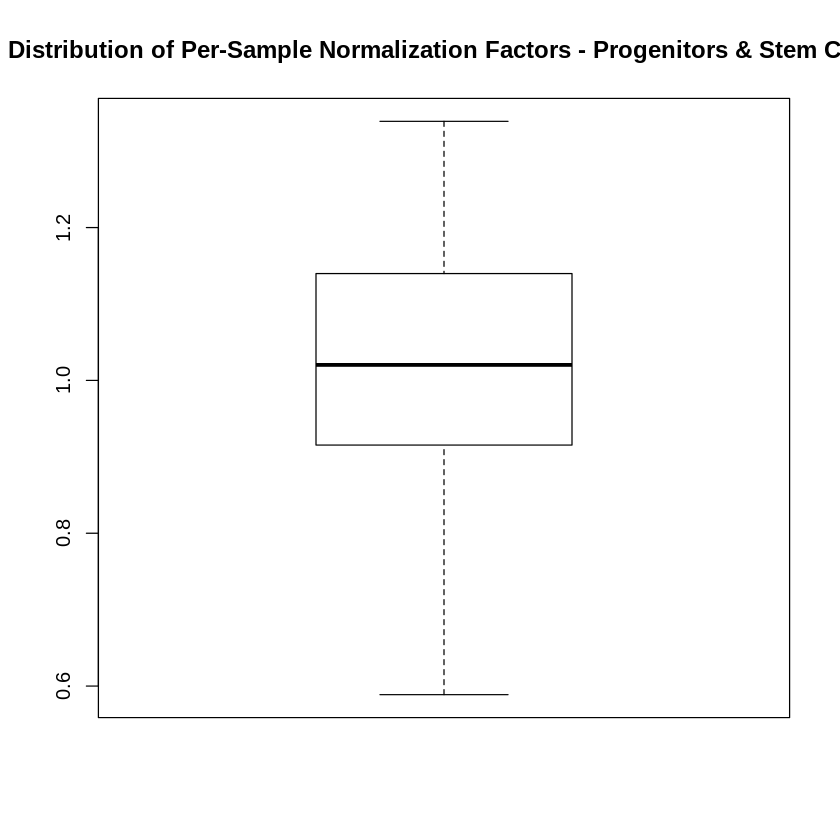

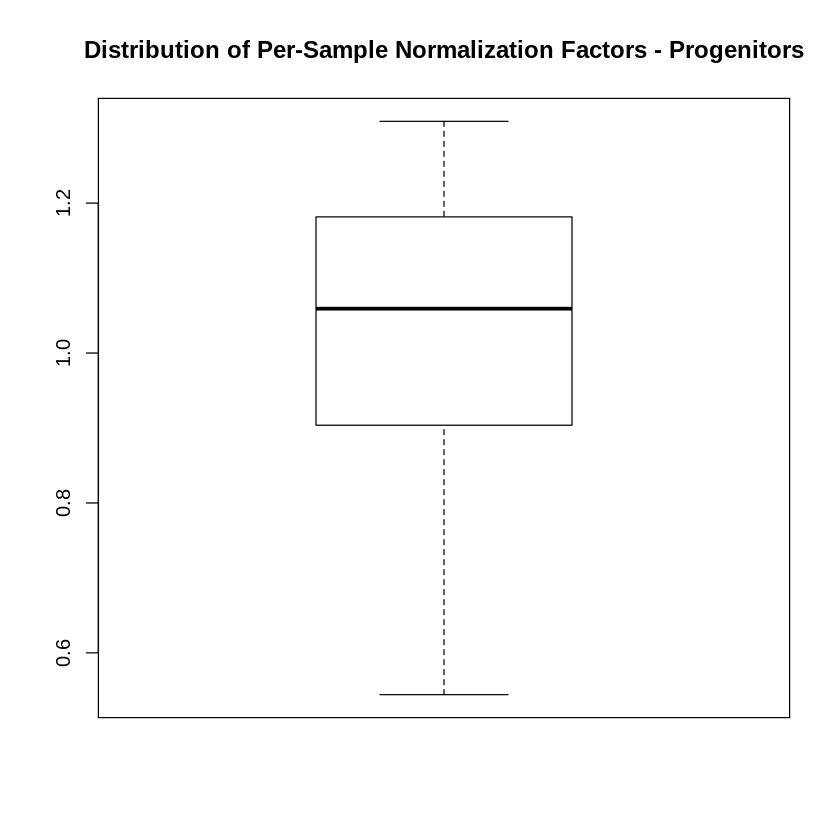

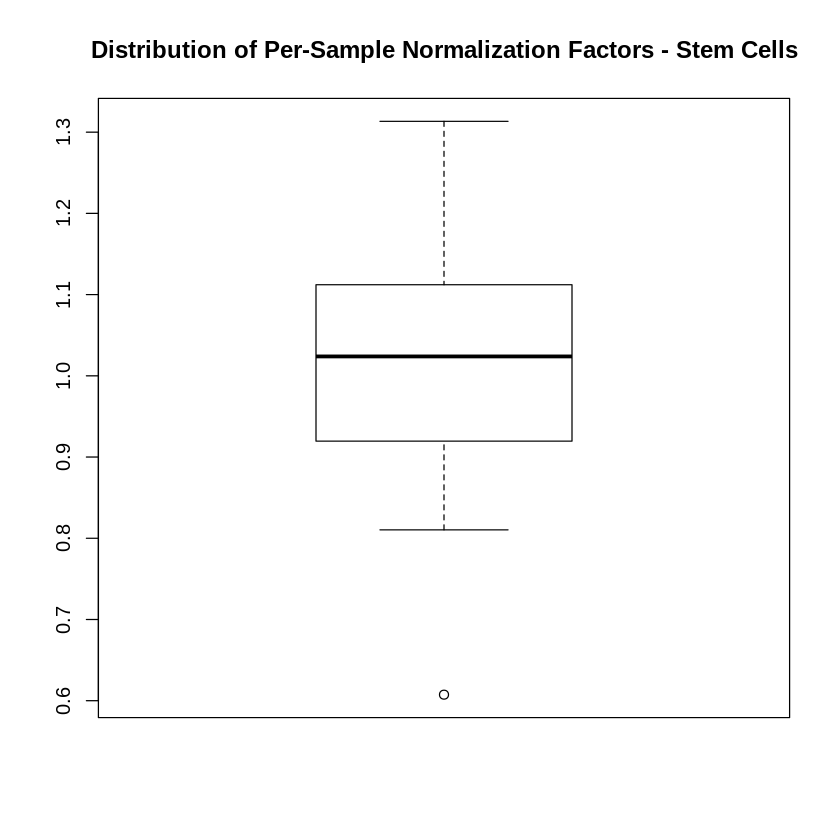

In [24]:
boxplot(gOrigNormedFilteredDgeList$samples$norm.factors, main="Distribution of Per-Sample Normalization Factors - Progenitors & Stem Cells")
boxplot(gOrigNormedFilteredDgeList.prog$samples$norm.factors, main="Distribution of Per-Sample Normalization Factors - Progenitors")
boxplot(gOrigNormedFilteredDgeList.stem$samples$norm.factors, main="Distribution of Per-Sample Normalization Factors - Stem Cells")

Write out the cpm-transformed, TMM-normalized data for future reference:

In [185]:
writeFilteredCpms = function(dgeList, outputDir, runName, geneType, celltype){
    cpm = cpm(dgeList)
    fileName = sprintf("%s_filtered_%s_genes_%s_tmm_normed_cpms.csv",runName, geneType, celltype)
    write.csv(cpm, file.path(outputDir, fileName))
    print(paste0("Output file: ",fileName))
}

In [186]:
writeFilteredCpms(gFilteredDgeList, gOutputDir, gRunName, gGeneType, "progstem")
writeFilteredCpms(gFilteredDgeList.prog, gOutputDir, gRunName, gGeneType, "prog")
writeFilteredCpms(gFilteredDgeList.stem, gOutputDir, gRunName, gGeneType, "stem")

[1] "Output file: 20200228_DeWerf_Human_PediatricAML_data_exploration_20200318125411_filtered_pc_genes_progstem_tmm_normed_cpms.csv"
[1] "Output file: 20200228_DeWerf_Human_PediatricAML_data_exploration_20200318125411_filtered_pc_genes_prog_tmm_normed_cpms.csv"
[1] "Output file: 20200228_DeWerf_Human_PediatricAML_data_exploration_20200318125411_filtered_pc_genes_stem_tmm_normed_cpms.csv"


[Table of Contents](#Table-of-Contents)

## Unsupervised Clustering

> In our opinion, one of the most important exploratory plots to examine for gene expression analyses is the multi-dimensional scaling (MDS) plot, or similar. The plot shows similarities and dissimilarities between samples in an unsupervised manner so that one can have an idea of the extent to which differential expression can be detected before carrying out formal tests. Ideally, samples would cluster well within the primary condition of interest, and any sample straying far from its group could be identified and followed up for sources of error or extra variation. If present, technical replicates should lie very close to one another. ([1](#Citations))

Examine the aggregate similarities between samples using unsupervised clustering, and determine if this unbiased approach shows similarities similar to those expected from the experimental design.  Begin with a principal components analysis of the normalized data.

### Principal Components Analysis

In [71]:
makeNormalizedPca<-function(normedDgeList, designDf, groupColName, sampleColName, 
                            designColNameForLabels=NULL, labelOnlyOutliers=TRUE){
    cpm_matrix = cpm(normedDgeList, normalized.lib.sizes=T)
    cpmDf = data.frame(cpm_matrix, check.names=FALSE)
    title = "PCA of Normalized Counts" 
    makeAndPrintPca(title, cpmDf, designDf, groupColName, sampleColName, 
                    designColNameForLabels=designColNameForLabels, 
                    labelOnlyOutliers=labelOnlyOutliers)    
    return("")
}

PCA of Normalized Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33
Standard deviation,51.49326,36.42777,33.90609,31.92862,28.59004,26.16873,24.75532,23.77297,20.39626,20.05102,⋯,9.009459,8.589532,7.63588,7.311233,7.000985,6.337762,6.064693,5.828723,5.327644,2.28676e-14
Proportion of Variance,0.20903,0.10461,0.09063,0.08037,0.06444,0.05399,0.04831,0.04455,0.03280,0.03169,⋯,0.006400,0.005820,0.00460,0.004210,0.003860,0.003170,0.002900,0.002680,0.002240,0.00000e+00
Cumulative Proportion,0.20903,0.31364,0.40427,0.48464,0.54907,0.60306,0.65137,0.69592,0.72872,0.76041,⋯,0.970530,0.976340,0.98094,0.985150,0.989020,0.992180,0.995080,0.997760,1.000000,1.00000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


[1] ""

PCA of Normalized Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33
Standard deviation,51.49326,36.42777,33.90609,31.92862,28.59004,26.16873,24.75532,23.77297,20.39626,20.05102,⋯,9.009459,8.589532,7.63588,7.311233,7.000985,6.337762,6.064693,5.828723,5.327644,2.28676e-14
Proportion of Variance,0.20903,0.10461,0.09063,0.08037,0.06444,0.05399,0.04831,0.04455,0.03280,0.03169,⋯,0.006400,0.005820,0.00460,0.004210,0.003860,0.003170,0.002900,0.002680,0.002240,0.00000e+00
Cumulative Proportion,0.20903,0.31364,0.40427,0.48464,0.54907,0.60306,0.65137,0.69592,0.72872,0.76041,⋯,0.970530,0.976340,0.98094,0.985150,0.989020,0.992180,0.995080,0.997760,1.000000,1.00000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


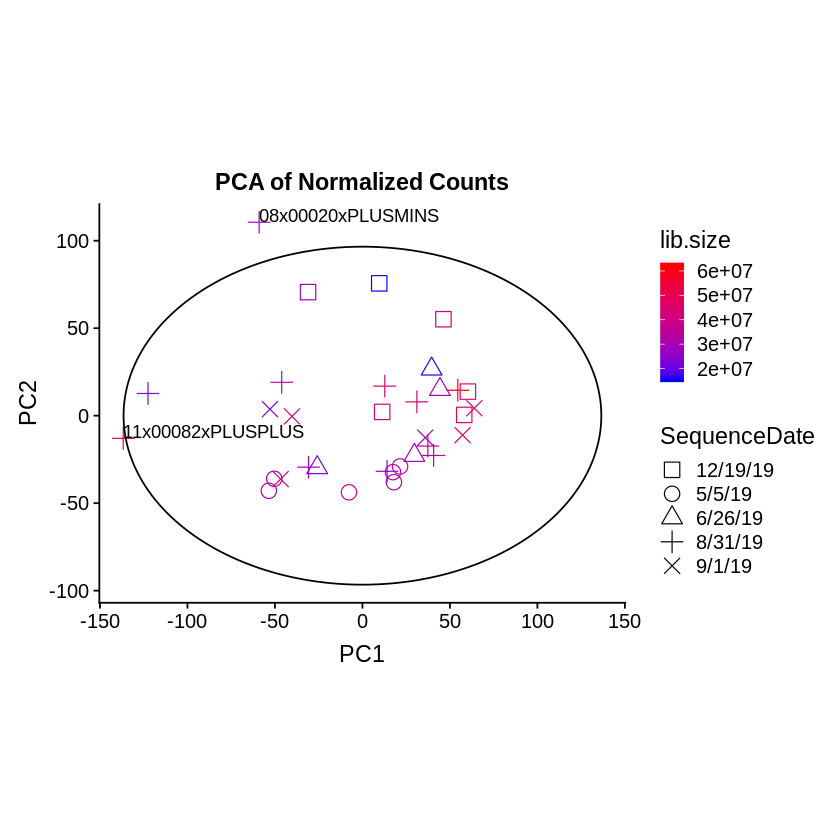

[1] ""

PCA of Normalized Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33
Standard deviation,51.49326,36.42777,33.90609,31.92862,28.59004,26.16873,24.75532,23.77297,20.39626,20.05102,⋯,9.009459,8.589532,7.63588,7.311233,7.000985,6.337762,6.064693,5.828723,5.327644,2.28676e-14
Proportion of Variance,0.20903,0.10461,0.09063,0.08037,0.06444,0.05399,0.04831,0.04455,0.03280,0.03169,⋯,0.006400,0.005820,0.00460,0.004210,0.003860,0.003170,0.002900,0.002680,0.002240,0.00000e+00
Cumulative Proportion,0.20903,0.31364,0.40427,0.48464,0.54907,0.60306,0.65137,0.69592,0.72872,0.76041,⋯,0.970530,0.976340,0.98094,0.985150,0.989020,0.992180,0.995080,0.997760,1.000000,1.00000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


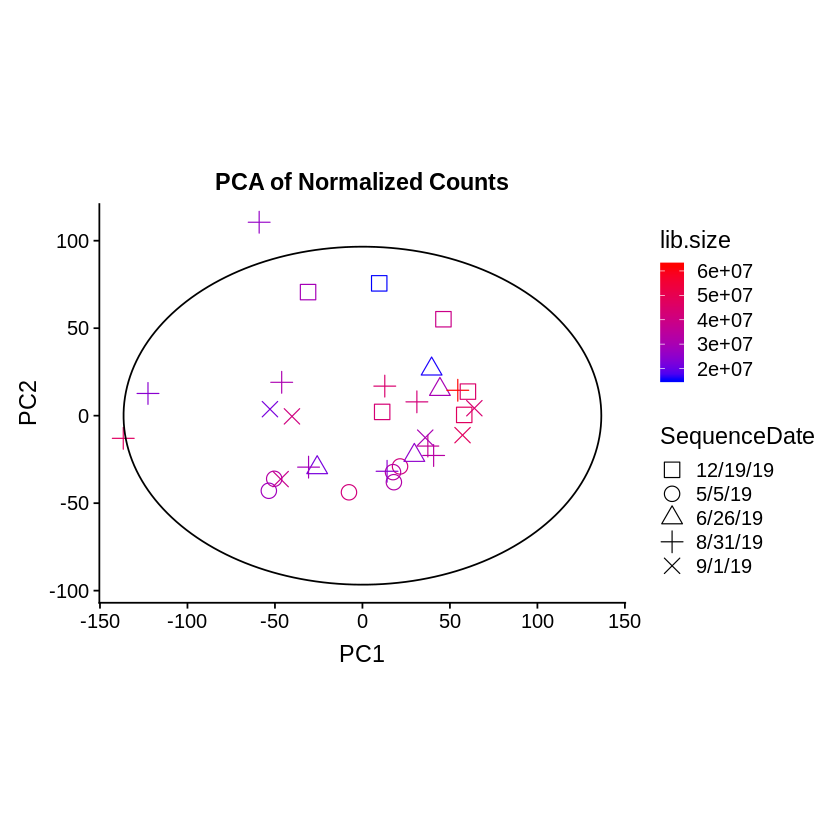

[1] ""

PCA of Normalized Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33
Standard deviation,51.49326,36.42777,33.90609,31.92862,28.59004,26.16873,24.75532,23.77297,20.39626,20.05102,⋯,9.009459,8.589532,7.63588,7.311233,7.000985,6.337762,6.064693,5.828723,5.327644,2.28676e-14
Proportion of Variance,0.20903,0.10461,0.09063,0.08037,0.06444,0.05399,0.04831,0.04455,0.03280,0.03169,⋯,0.006400,0.005820,0.00460,0.004210,0.003860,0.003170,0.002900,0.002680,0.002240,0.00000e+00
Cumulative Proportion,0.20903,0.31364,0.40427,0.48464,0.54907,0.60306,0.65137,0.69592,0.72872,0.76041,⋯,0.970530,0.976340,0.98094,0.985150,0.989020,0.992180,0.995080,0.997760,1.000000,1.00000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


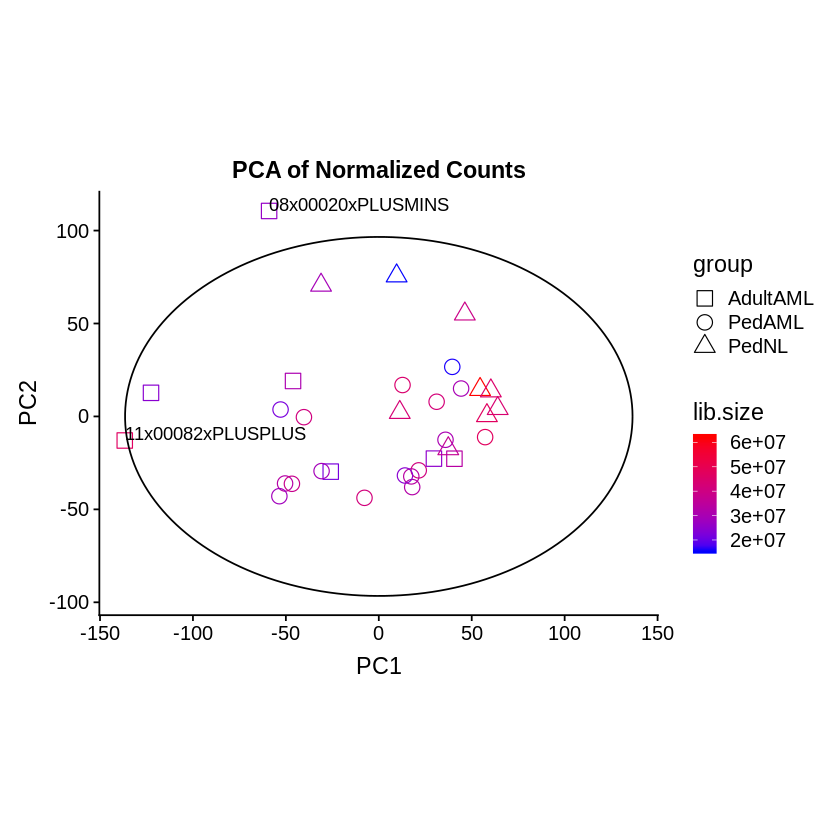

[1] ""

PCA of Normalized Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
Standard deviation,58.83808,37.30828,34.61915,33.21533,31.15530,28.69811,24.68796,23.18450,19.57433,18.87016,17.26905,16.50097,13.77122,12.90066,11.42019,9.751988,8.991326,1.384282e-14
Proportion of Variance,0.28684,0.11533,0.09930,0.09141,0.08043,0.06824,0.05050,0.04454,0.03175,0.02950,0.02471,0.02256,0.01571,0.01379,0.01081,0.007880,0.006700,0.000000e+00
Cumulative Proportion,0.28684,0.40217,0.50148,0.59289,0.67331,0.74155,0.79205,0.83659,0.86834,0.89784,0.92255,0.94511,0.96083,0.97462,0.98542,0.993300,1.000000,1.000000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


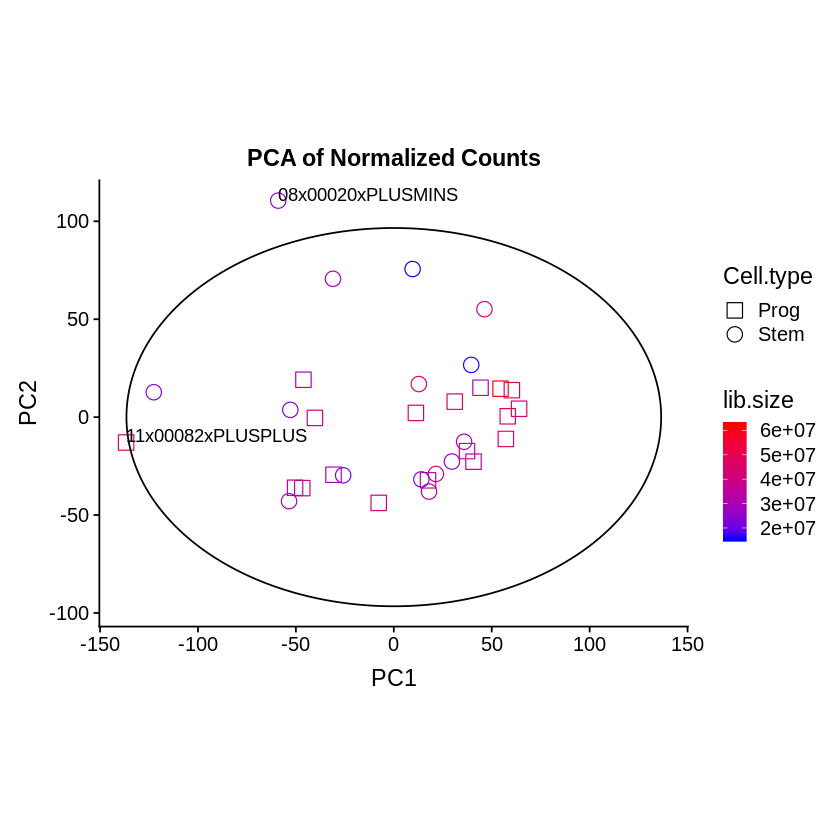

[1] ""

PCA of Normalized Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
Standard deviation,58.83808,37.30828,34.61915,33.21533,31.15530,28.69811,24.68796,23.18450,19.57433,18.87016,17.26905,16.50097,13.77122,12.90066,11.42019,9.751988,8.991326,1.384282e-14
Proportion of Variance,0.28684,0.11533,0.09930,0.09141,0.08043,0.06824,0.05050,0.04454,0.03175,0.02950,0.02471,0.02256,0.01571,0.01379,0.01081,0.007880,0.006700,0.000000e+00
Cumulative Proportion,0.28684,0.40217,0.50148,0.59289,0.67331,0.74155,0.79205,0.83659,0.86834,0.89784,0.92255,0.94511,0.96083,0.97462,0.98542,0.993300,1.000000,1.000000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


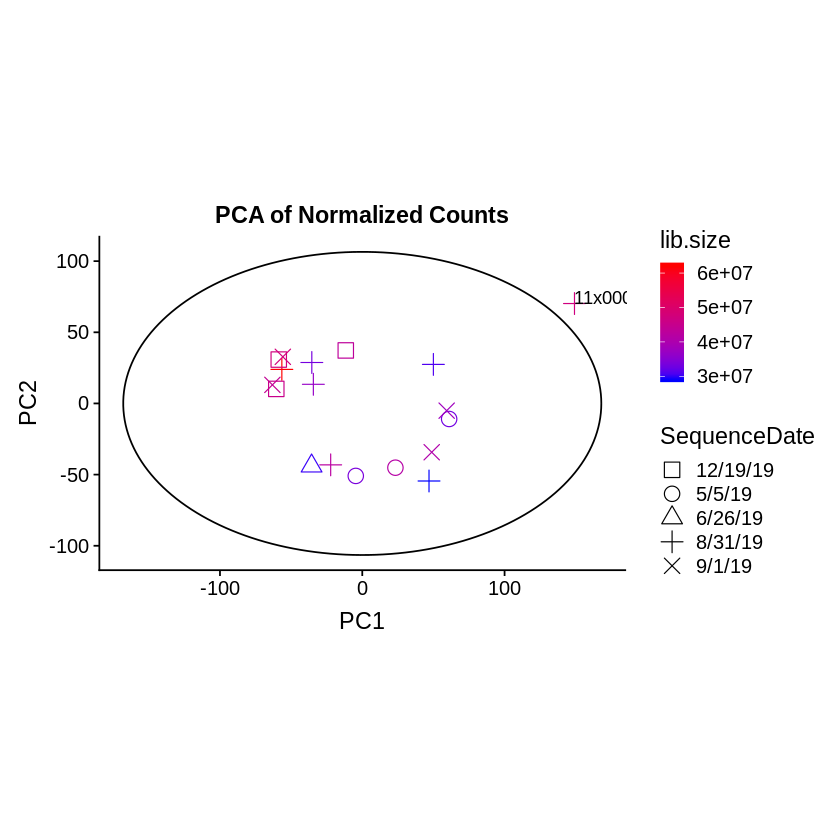

[1] ""

PCA of Normalized Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
Standard deviation,50.09486,42.33034,37.16405,33.38625,31.68321,28.53644,26.71007,24.41337,21.90414,20.75394,16.96673,16.25487,15.77058,14.17482,1.289099e-14
Proportion of Variance,0.21200,0.15138,0.11668,0.09417,0.08480,0.06880,0.06027,0.05035,0.04053,0.03639,0.02432,0.02232,0.02101,0.01697,0.000000e+00
Cumulative Proportion,0.21200,0.36338,0.48006,0.57423,0.65903,0.72783,0.78810,0.83845,0.87899,0.91537,0.93969,0.96201,0.98303,1.00000,1.000000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


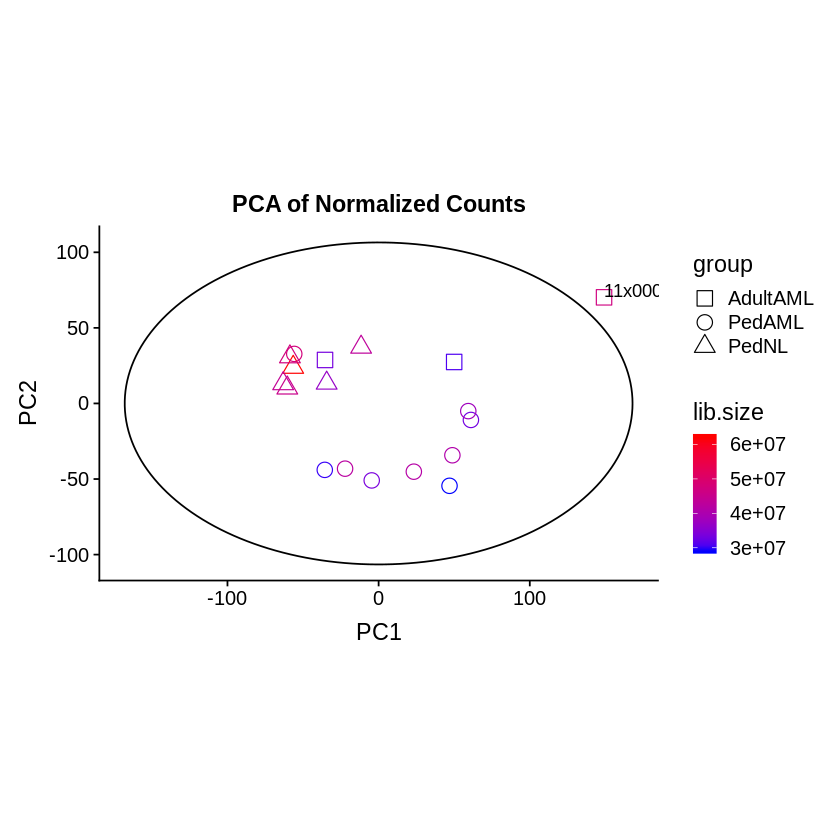

[1] ""

PCA of Normalized Counts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
Standard deviation,50.09486,42.33034,37.16405,33.38625,31.68321,28.53644,26.71007,24.41337,21.90414,20.75394,16.96673,16.25487,15.77058,14.17482,1.289099e-14
Proportion of Variance,0.21200,0.15138,0.11668,0.09417,0.08480,0.06880,0.06027,0.05035,0.04053,0.03639,0.02432,0.02232,0.02101,0.01697,0.000000e+00
Cumulative Proportion,0.21200,0.36338,0.48006,0.57423,0.65903,0.72783,0.78810,0.83845,0.87899,0.91537,0.93969,0.96201,0.98303,1.00000,1.000000e+00


Coordinate system already present. Adding new coordinate system, which will replace the existing one.


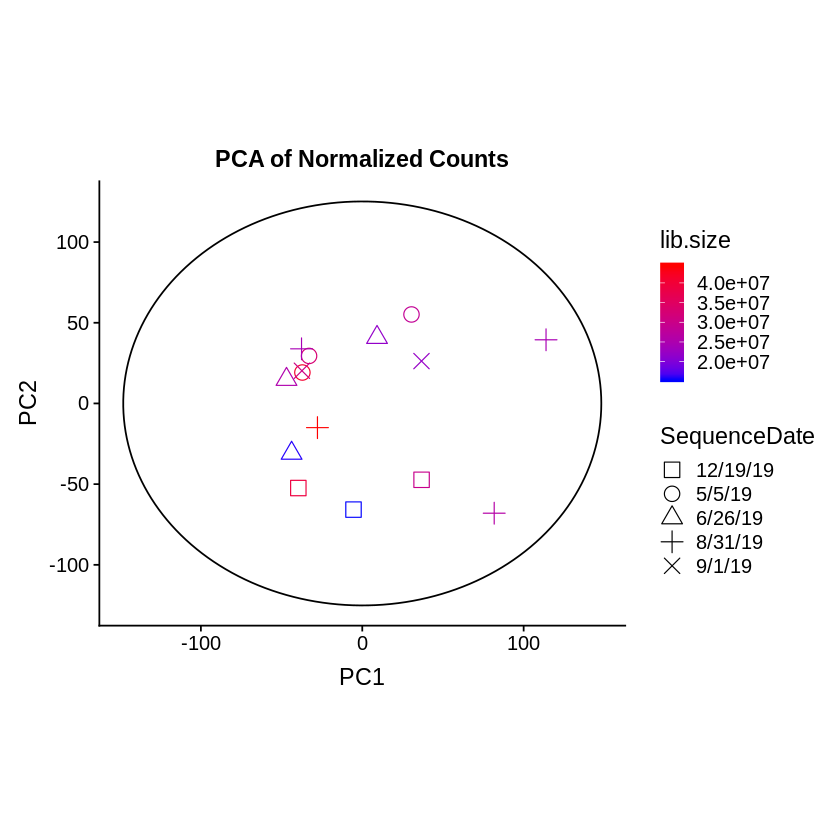

[1] ""

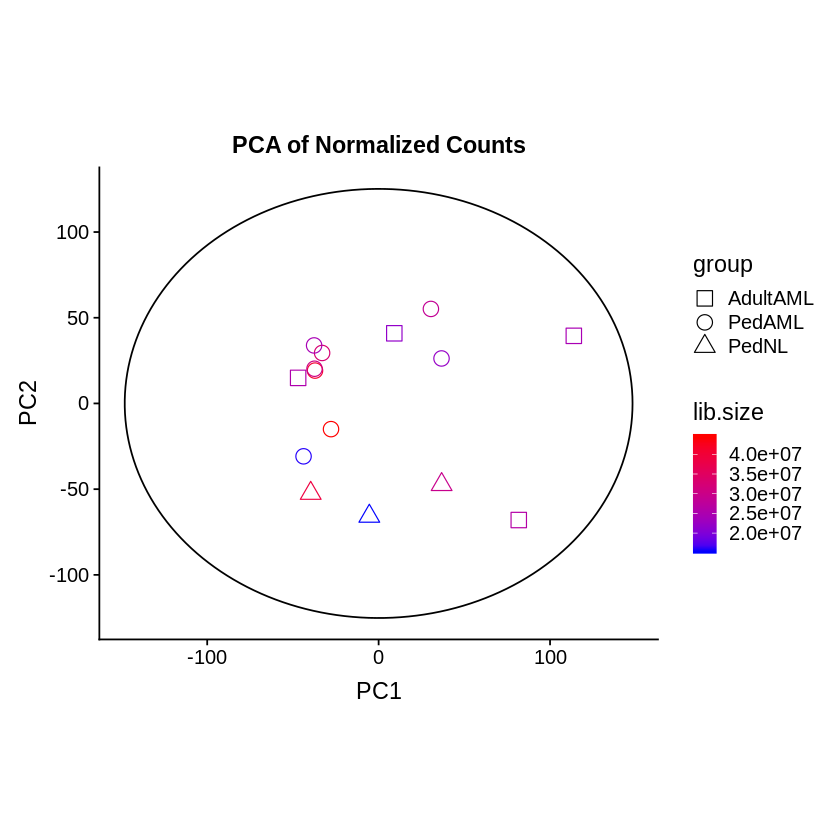

In [42]:
makeNormalizedPca(gOrigNormedFilteredDgeList, gOrigNormedFilteredDgeList$samples, 
                  "SequenceDate", "Sample", "Sample")
makeNormalizedPca(gOrigNormedFilteredDgeList, gOrigNormedFilteredDgeList$samples, 
                  "SequenceDate", gSampleColName)
makeNormalizedPca(gOrigNormedFilteredDgeList, gOrigNormedFilteredDgeList$samples, 
                  "group", gSampleColName, "Sample")
makeNormalizedPca(gOrigNormedFilteredDgeList, gOrigNormedFilteredDgeList$samples, 
                  "Cell.type", gSampleColName, "Sample")

makeNormalizedPca(gOrigNormedFilteredDgeList.prog, gOrigNormedFilteredDgeList.prog$samples, 
                  "SequenceDate", gSampleColName, "Sample")
makeNormalizedPca(gOrigNormedFilteredDgeList.prog, gOrigNormedFilteredDgeList.prog$samples, 
                  "group", gSampleColName, "Sample")

makeNormalizedPca(gOrigNormedFilteredDgeList.stem, gOrigNormedFilteredDgeList.stem$samples, 
                  "SequenceDate", gSampleColName, "Sample")
makeNormalizedPca(gOrigNormedFilteredDgeList.stem, gOrigNormedFilteredDgeList.stem$samples, 
                  "group", gSampleColName, "Sample")

In [ ]:
makeNormalizedPca<-function(normedDgeList, designDf, groupColName, sampleColName, 
                            designColNameForLabels=NULL, labelOnlyOutliers=TRUE){
    cpm_matrix = cpm(normedDgeList, normalized.lib.sizes=T)
    cpmDf = data.frame(cpm_matrix, check.names=FALSE)
    title = "PCA of Normalized Counts" 
    makeAndPrintPca(title, cpmDf, designDf, groupColName, sampleColName, 
                    designColNameForLabels=designColNameForLabels, 
                    labelOnlyOutliers=labelOnlyOutliers)    
    return("")
}

In [80]:

table(gOrigNormedFilteredDgeList.prog.merge$samples$group)
table(gOrigNormedFilteredDgeList.prog.merge$samples$Sample %in% colnames(gOrigNormedFilteredDgeList.prog.merge$counts))

gOrigNormedFilteredDgeList.prog.merge$samples$Sample
colnames(gOrigNormedFilteredDgeList.prog.merge$counts)


AdultAML   PedAML    PedNL      ABM      CML    dnAML       ET       MF 
       3        9        6        8        5        2        2       24 
      PV     sAML      YBM 
       6       11        8 


FALSE  TRUE 
   28    56 

[1] "02id38cellPROGENITORS" "06id90cellPROGENITORS" "04id78cellPROGENITORS"
 [4] "06id00066PRO"          "01x00077xPROGENIT"     "03x11379xHPCxxxxx"    
 [7] "05x00047xPLUSPLUS"     "06x00077xPLUSPLUS"     "07x00023xPLUSPLUS"    
[10] "09x00020xPLUSPLUS"     "11x00082xPLUSPLUS"     "14x12488xPLUSPLUS"    
[13] "15x12584xPLUSPLUS"     "17x12451xPLUSPLUS"     "18x10720xPLUSPLUS"    
[16] "02pid24760ctHPC"       "04pid24474ctHPC"       "06pid25376ctHPC"      
[19] "X368_ACAGTG_S0"        "X380_ACAGTG_S0"        "X401_ACAGTG_S0"       
[22] "X402_ACAGTG_S0"        "X410_ACAGTG_S0"        "X415_ACAGTG_S0"       
[25] "X416_ACAGTG_S0"        "X426_ACAGTG_S0"        "X591.BM.Prog_S0"      
[28] "X672A.PB.Prog_S3"      "X672B.PB.Prog_S0"      "X735.PB.Prog_S8"      
[31] "X571.BM.Prog"          "X608.BM.Prog"          "X616.BM.Prog"         
[34] "X703.PB.Prog"          "X727.PB.Prog"          "X20_MDStoAML"         
[37] "X19_MDStoAML"          "X431.PB.Prog"          "X638.BM.Prog"         
[40] "X407.PB.Prog"          "X428.PB.Prog"          "X560.PB.Prog"         
[43] "X566.PB.Prog"          "X569.PB.Prog"          "X573.BM.Prog"         
[46] "X576.PB.Prog"          "X580.BM.Prog"          "X581.PB.Prog"         
[49] "X599.PB.Prog"          "X600.BM.Prog"          "X600.PB.Prog"         
[52] "X621.PB.Prog"          "X664.BM.Prog"          "X666.PB.Prog"         
[55] "X668.PB.Prog_S2"       "X670A.PB.Prog"         "X670B.PB.Prog"        
[58] "X724.PB.Prog_S3"       "X725.PB.Prog"          "X732.PB.Prog"         
[61] "X736.BM.Prog_S0"       "X744.PB.Prog"          "X767.BM.Prog"         
[64] "X562.PB.Prog_S0"       "X575A.PB.Prog_S0"      "X598.PB.Prog_S0"      
[67] "X662.BM.Prog_S4"       "X689.BM.Prog_S11"      "X690.BM.Prog_S5"      
[70] "X102"                  "X89"                   "X87"                  
[73] "X36"                   "X42"                   "X107"                 
[76] "X48_MDStoAML"          "X4018_GTGAAA_S0"       "X4040_GTGAAA_S0"      
[79] "X4066_GTGAAA_S0"       "X4188_GTGAAA_S0"       "X4215_GTGAAA_S0"      
[82] "X4218_GTGAAA_S0"       "X4259_GTGAAA_S0"       "X4279_GTGAAA_S0"

[1] "02id38cellPROGENITORS" "06id90cellPROGENITORS" "04id78cellPROGENITORS"
 [4] "06id00066PRO"          "01x00077xPROGENIT"     "03x11379xHPCxxxxx"    
 [7] "05x00047xPLUSPLUS"     "06x00077xPLUSPLUS"     "07x00023xPLUSPLUS"    
[10] "09x00020xPLUSPLUS"     "11x00082xPLUSPLUS"     "14x12488xPLUSPLUS"    
[13] "15x12584xPLUSPLUS"     "17x12451xPLUSPLUS"     "18x10720xPLUSPLUS"    
[16] "02pid24760ctHPC"       "04pid24474ctHPC"       "06pid25376ctHPC"      
[19] "X368_ACAGTG_S0"        "X380_ACAGTG_S0"        "X401_ACAGTG_S0"       
[22] "X402_ACAGTG_S0"        "X410_ACAGTG_S0"        "X415_ACAGTG_S0"       
[25] "X416_ACAGTG_S0"        "X426_ACAGTG_S0"        "X591.BM.Prog_S0"      
[28] "X672A.PB.Prog_S3"      "X672B.PB.Prog_S0"      "X735.PB.Prog_S8"      
[31] "X571.BM.Prog_S0"       "X608.BM.Prog_S3"       "X616.BM.Prog_S0"      
[34] "X703.PB.Prog_S13"      "X727.PB.Prog_S4"       "X20_MDStoAML"         
[37] "X19_MDStoAML"          "X431.PB.Prog_S0"       "X638.BM.Prog_S1"      
[40] "X407.PB.Prog_S0"       "X428.PB.Prog_S0"       "X560.PB.Prog_S0"      
[43] "X566.PB.Prog_S0"       "X569.PB.Prog_S0"       "X573.BM.Prog_S0"      
[46] "X576.PB.Prog_S0"       "X580.BM.Prog_S0"       "X581.PB.Prog_S2"      
[49] "X599.PB.Prog_S0"       "X600.BM.Prog_S0"       "X600.PB.Prog_S0"      
[52] "X621.PB.Prog_S2"       "X664.BM.Prog_S4"       "X666.PB.Prog_S2"      
[55] "X668.PB.Prog_S2"       "X670A.PB.Prog_S3"      "X670B.PB.Prog_S2"     
[58] "X724.PB.Prog_S3"       "X725.PB.Prog_S7"       "X732.PB.Prog_S5"      
[61] "X736.BM.Prog_S0"       "X744.PB.Prog_S0"       "X767.BM.Prog_S0"      
[64] "X562.PB.Prog_S0"       "X575A.PB.Prog_S0"      "X598.PB.Prog_S0"      
[67] "X662.BM.Prog_S4"       "X689.BM.Prog_S11"      "X690.BM.Prog_S5"      
[70] "X102"                  "X89"                   "X87"                  
[73] "X36"                   "X42"                   "X107"                 
[76] "X48_MDStoAML"          "X4018_GTGAAA_S0"       "X4040_GTGAAA_S0"      
[79] "X4066_GTGAAA_S0"       "X4188_GTGAAA_S0"       "X4215_GTGAAA_S0"      
[82] "X4218_GTGAAA_S0"       "X4259_GTGAAA_S0"       "X4279_GTGAAA_S0"

In [108]:
colnames(gOrigNormedFilteredDgeList.prog.merge$counts) <- gOrigNormedFilteredDgeList.prog.merge$samples$Sample
colnames(gOrigNormedFilteredDgeList.stem.merge$counts) <- gOrigNormedFilteredDgeList.stem.merge$samples$Sample

#makeNormalizedPca(gOrigNormedFilteredDgeList.prog.merge, gOrigNormedFilteredDgeList.prog.merge$samples, 
#                  "group", gSampleColName, "Sample")

makeNormalizedPca(gOrigNormedFilteredDgeList.stem.merge, gOrigNormedFilteredDgeList.stem.merge$samples, 
                  "group", gSampleColName, "Sample")

PCA of Normalized Counts

ERROR: Error in La.svd(x, nu, nv): BLAS/LAPACK routine 'DLASCL' gave error code -4


### Add one additional outlier based on the normalized PCA plots
* 08x00020xPlusMins

In [26]:
mask.len <- nrow(gOrigNormedFilteredDgeList$samples)
mask.len.stem <- nrow(gOrigNormedFilteredDgeList.stem$samples)
gNonOutliersMask2 = rep(TRUE, mask.len)
gNonOutliersMask2[which(gOrigNormedFilteredDgeList$samples$Sample == '08x00020xPLUSMINS')] <- FALSE 
gNonOutliersMask2.stem = rep(TRUE, mask.len.stem)
gNonOutliersMask2.stem[which(gOrigNormedFilteredDgeList.stem$samples$Sample == '08x00020xPLUSMINS')] <- FALSE 


gNormedFilteredDgeList <- gOrigNormedFilteredDgeList[,gNonOutliersMask2]
gNormedFilteredDgeList.stem <- gOrigNormedFilteredDgeList.stem[,gNonOutliersMask2.stem]
gNormedFilteredDgeList.prog <- gOrigNormedFilteredDgeList.prog

In [109]:
mask.len.stem.merge <- nrow(gOrigNormedFilteredDgeList.stem.merge$samples)
gNonOutliersMask2.stem.merge = rep(TRUE, mask.len.stem.merge)
gNonOutliersMask2.stem.merge[which(gOrigNormedFilteredDgeList.stem.merge$samples$Sample == '08x00020xPLUSMINS')] <- FALSE 

gNormedFilteredDgeList.stem.merge <- gOrigNormedFilteredDgeList.stem.merge[,gNonOutliersMask2.stem.merge]
gNormedFilteredDgeList.prog.merge <- gOrigNormedFilteredDgeList.prog.merge

Examine the total number of samples and compare it to the number that pass the outlier mask:

### Multidimensional Scaling Visualization

Next, examine multidimensional scaling plots of the data.

> [An MDS] plot can be made in limma using the plotMDS function. The first dimension represents the leading-fold-change that best separates samples and explains the largest proportion of variation in the data, with subsequent dimensions having a smaller effect and being orthogonal to the ones before it. When experimental design involves multiple factors, it is recommended that each factor is examined over several dimensions. If samples cluster by a given factor in any of these dimensions, it suggests that the factor contributes to expression differences and is worth including in the linear modelling. On the other hand, factors that show little or no effect may be left out of downstream analysis. ([1](#Citations))

In [34]:
head(gNormedFilteredDgeList$sample)

,group,lib.size,norm.factors,SequenceRun,SequenceDate,Sample,SampleName,Patient.ID,RIN,X,Adult.Pediatric,Disease,Cell.type,Sorted.Cell.Type,Tissue.Source,RNA.seq.status,Reads
,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
01id38cellHSC,PedAML,41053037,1.0202671,ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91,5/5/19,01id38cellHSC,38 HSC,32538,10.0,PedAML,Pediatric,AML,Stem,34+38-,PB,Completed,81234305
02id38cellPROGENITORS,PedAML,33880305,0.9970015,ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91,5/5/19,02id38cellPROGENITORS,38 Progenitors,32538,9.7,PedAML,Pediatric,AML,Prog,34+38+,PB,Completed,73196851
cell05id90HSC,PedAML,32756184,0.9893871,ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91,5/5/19,cell05id90HSC,90 HSC,22390,10.0,PedAML,Pediatric,AML,Stem,34+38-,BM,Completed,72625632
06id90cellPROGENITORS,PedAML,33202985,0.8548814,ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91,5/5/19,06id90cellPROGENITORS,90 Progenitors,22390,10.0,PedAML,Pediatric,AML,Prog,34+38+,BM,Completed,81721991
03id78cellHSC,PedAML,28605524,0.8076966,ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91,5/5/19,03id78cellHSC,78 HSC,28678,10.0,PedAML,Pediatric,AML,Stem,34+38-,PB,Completed,68483294
04id78cellPROGENITORS,PedAML,41632102,0.9348678,ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91,5/5/19,04id78cellPROGENITORS,78 Progenitors,28678,10.0,PedAML,Pediatric,AML,Prog,34+38+,PB,Completed,88894032


In [85]:
plotMdsColoredByColumn = function(aDgeList, colNameInSampleDf, dimensions=c(1,2), 
                                  brewerPaletteName="Dark2", labelColNameInSampleDf=NULL){
    condition <- as.factor(aDgeList$sample[[colNameInSampleDf]])
    lcpm <- cpm(aDgeList, log=TRUE)
    par(mfrow=c(1,1))
    col.condition <- condition
    naive_palette = brewer.pal(nlevels(col.condition), brewerPaletteName) #if more than 2 conditions
    extended_palette = colorRampPalette(naive_palette)(nlevels(col.condition)) 
    levels(col.condition) = extended_palette
    
    # levels(col.condition) <-  brewer.pal(nlevels(col.condition), brewerPaletteName) #if more than 2 conditions
    col.condition <- as.character(col.condition) 
    if(is.null(labelColNameInSampleDf)) {
        plotMDS(lcpm, labels=condition, col=col.condition, cex=.5, dim=dimensions)
        title(main=paste("MDS plot labeled by", colNameInSampleDf))
    } else {
        
        plotMDS(lcpm, labels=as.factor(aDgeList$sample[[labelColNameInSampleDf]]), 
                col=col.condition, cex=.5, dim=dimensions, legend="all")
        title(main=paste("MDS plot labeled by", colNameInSampleDf))
 #       legend(fill=col.condition, levels(condition))
    }
}

<div class="alert alert-warning">
    <strong>Analyst Note: Modify Code</strong><br />
    
**Add code cells to the section below to look at MDS plots for each relevant factor** in the metadata.  For each factor, look at it over dimensions higher than the first and second dimension if that shows no effect (see guidance from citation 1 above).  For each plot, select the metadata column (e.g., "day", "treatment", etc) for the factor of interest should and insert it as the second argument in the plotMdsColoredByColumn function call.  Then decide on the dimensions to be viewed (e.g., c(1,2) for the first and second, or c(3,4) for the third and fourth, etc), and insert it as the third argument in the function call.
    
</div>

[1] 12685    32

[1] 32 17

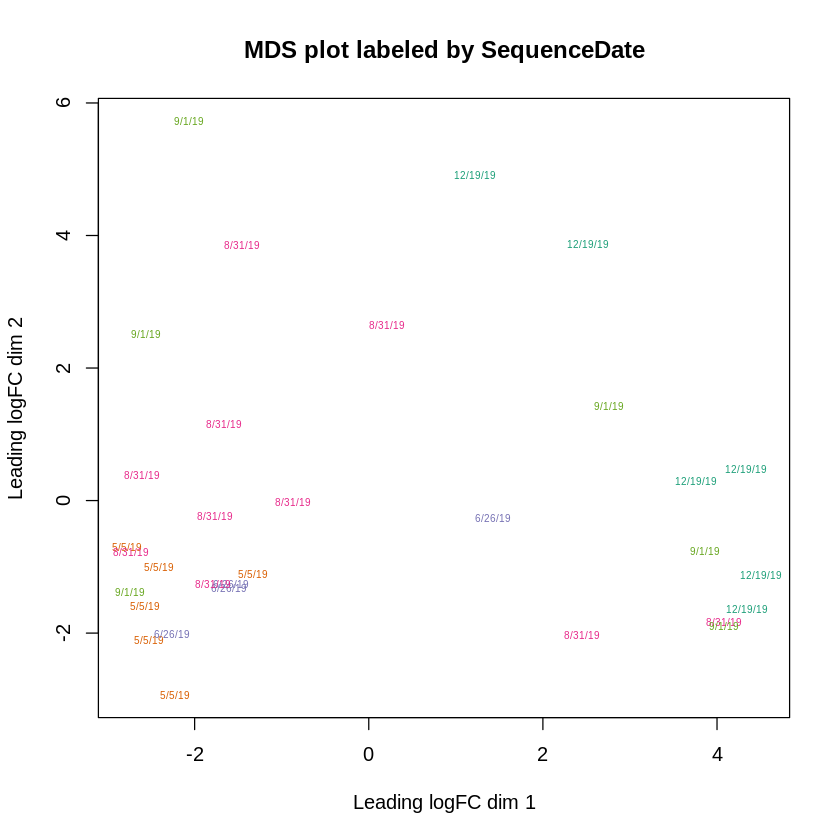

Warning message in brewer.pal(nlevels(col.condition), brewerPaletteName):
“minimal value for n is 3, returning requested palette with 3 different levels
”

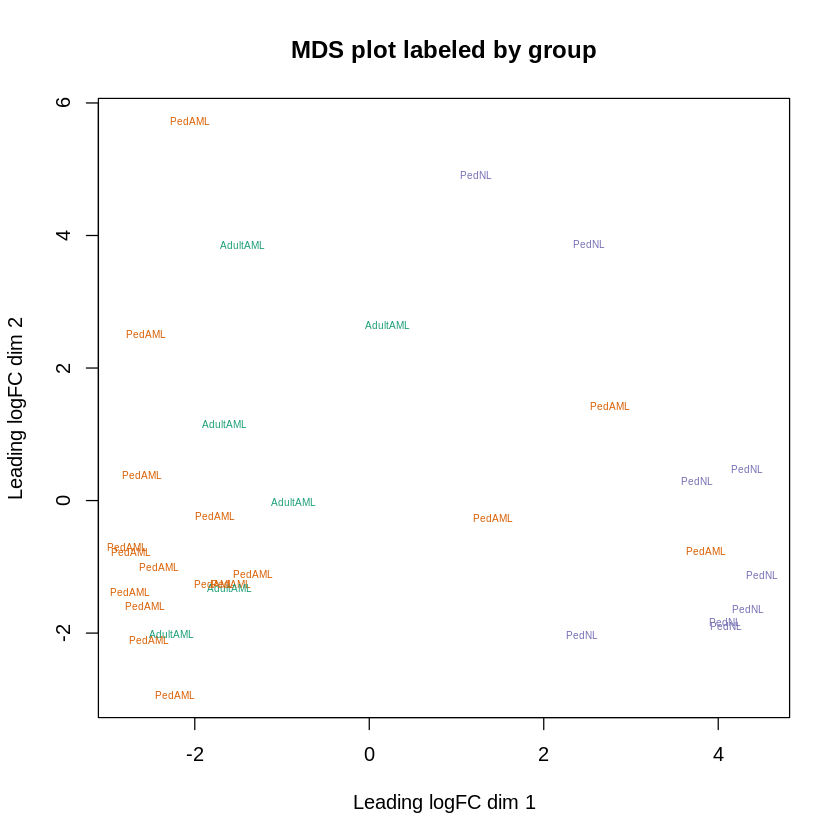

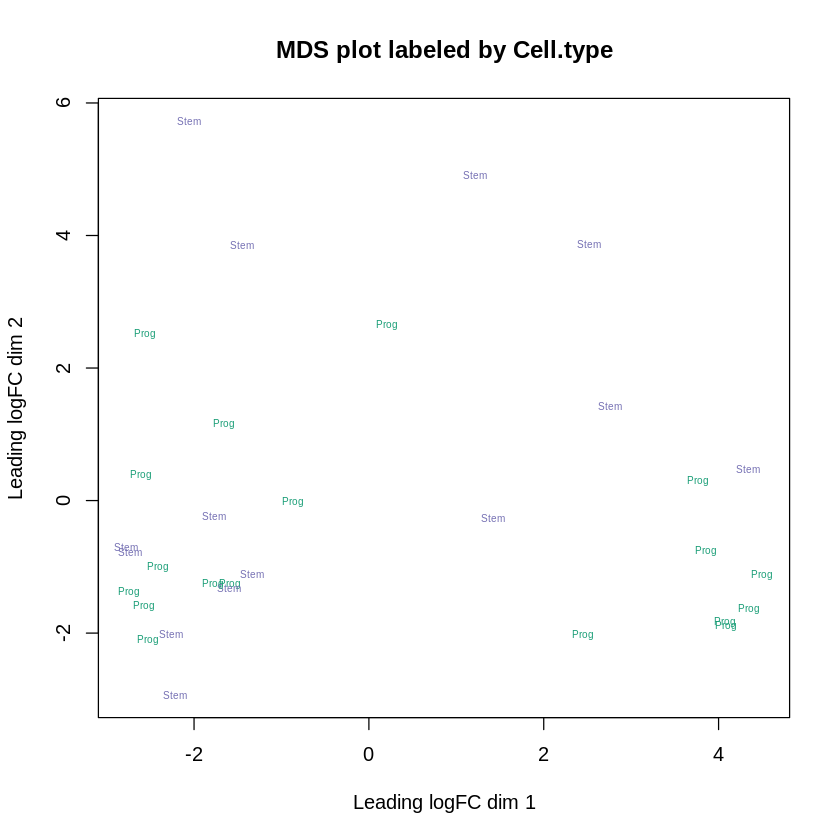

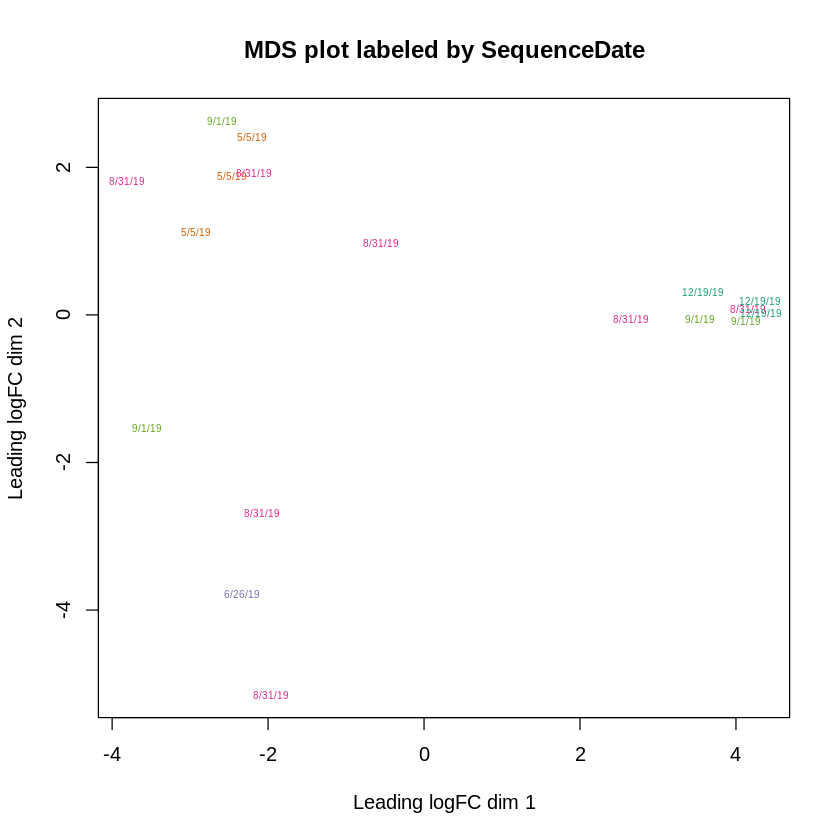

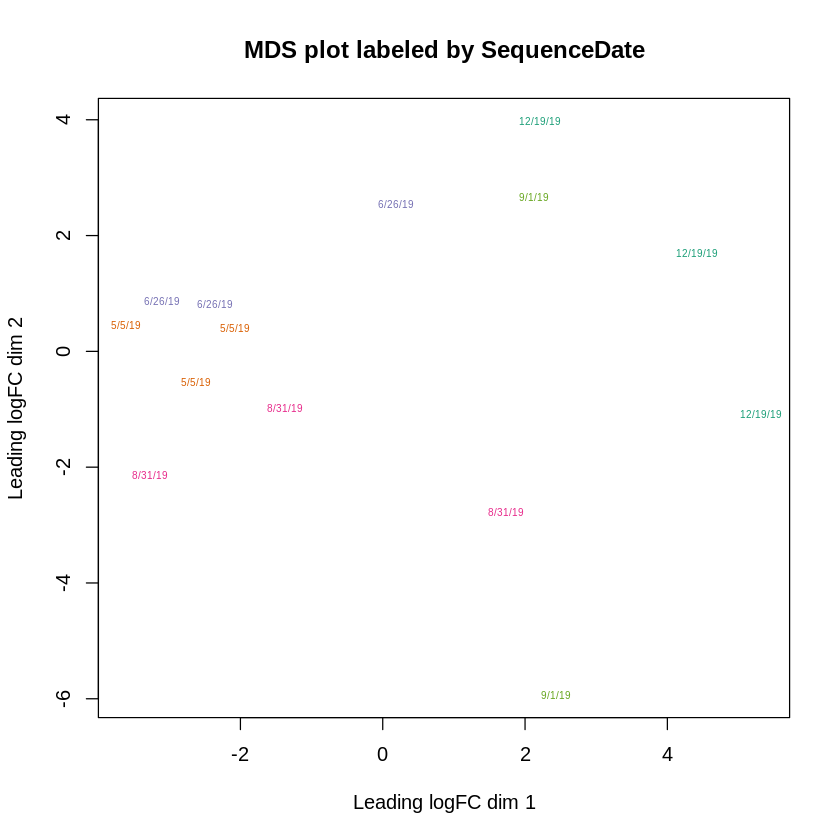

In [49]:
dim(gNormedFilteredDgeList$counts)
dim(gNormedFilteredDgeList$samples)
plotMdsColoredByColumn(gNormedFilteredDgeList, "SequenceDate", c(1,2))
plotMdsColoredByColumn(gNormedFilteredDgeList, "group", c(1,2))
plotMdsColoredByColumn(gNormedFilteredDgeList, "Cell.type", c(1,2))
plotMdsColoredByColumn(gNormedFilteredDgeList.prog, "SequenceDate", c(1,2))
plotMdsColoredByColumn(gNormedFilteredDgeList.stem, "SequenceDate", c(1,2))

Warning message in brewer.pal(nlevels(col.condition), brewerPaletteName):
“minimal value for n is 3, returning requested palette with 3 different levels
”
Warning message in brewer.pal(nlevels(col.condition), brewerPaletteName):
“minimal value for n is 3, returning requested palette with 3 different levels
”


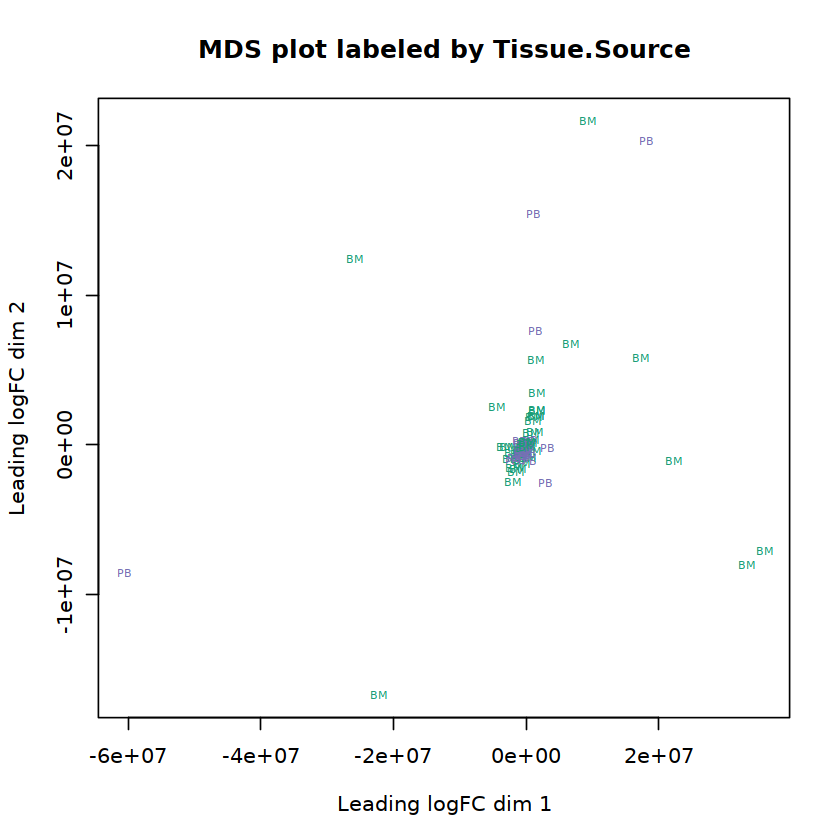

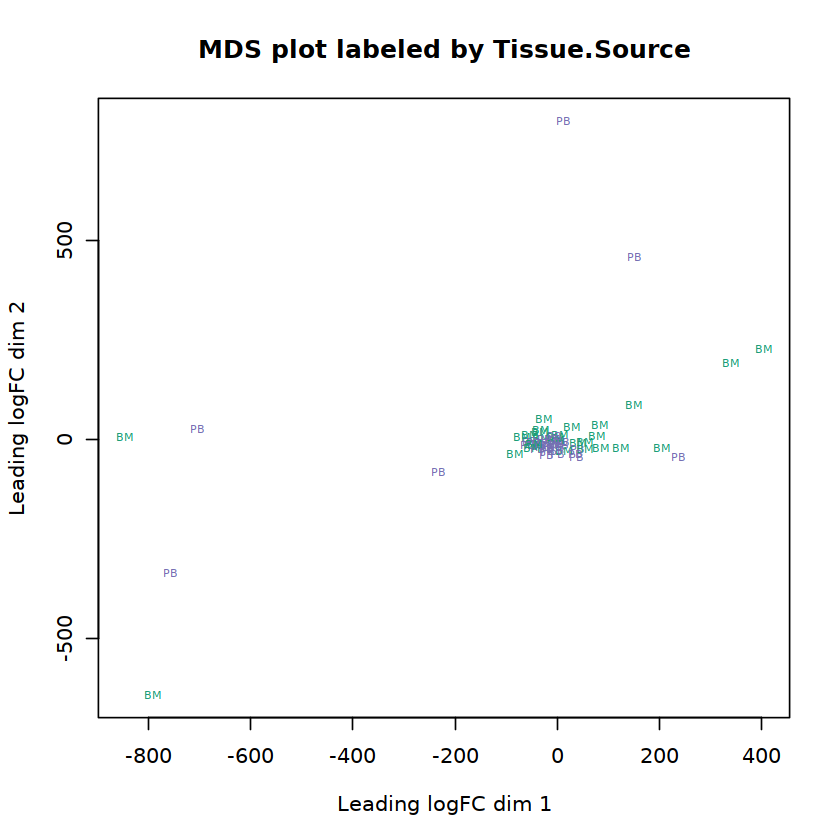

In [110]:
plotMdsColoredByColumn(gNormedFilteredDgeList.prog.merge, "Tissue.Source", c(1,2))
plotMdsColoredByColumn(gNormedFilteredDgeList.stem.merge, "Tissue.Source", c(1,2))

Warning message in brewer.pal(nlevels(col.condition), brewerPaletteName):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”
Warning message in brewer.pal(nlevels(col.condition), brewerPaletteName):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”


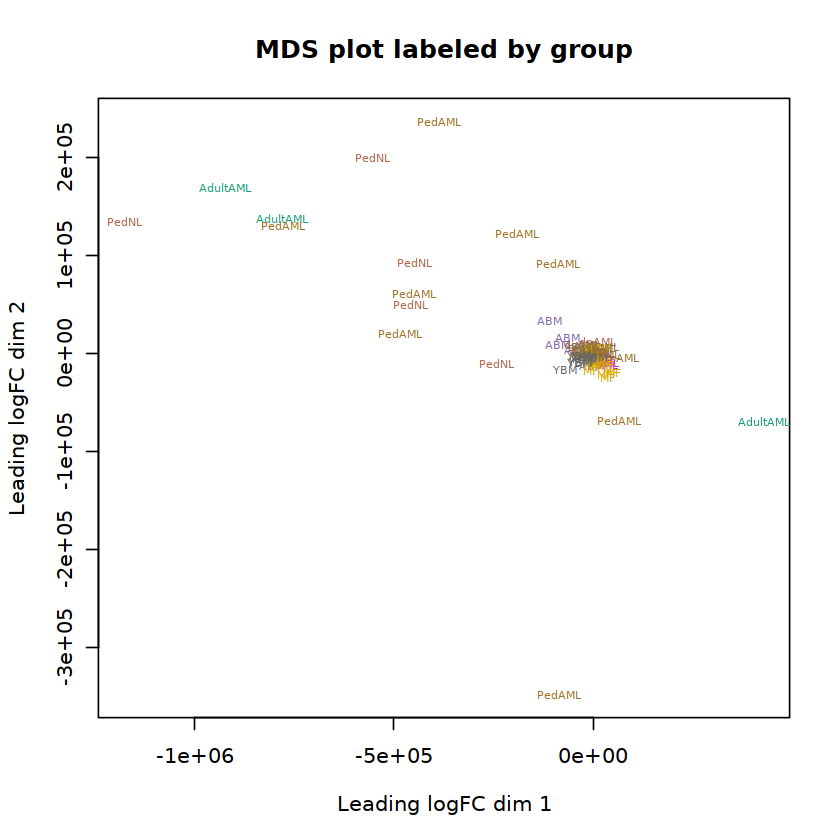

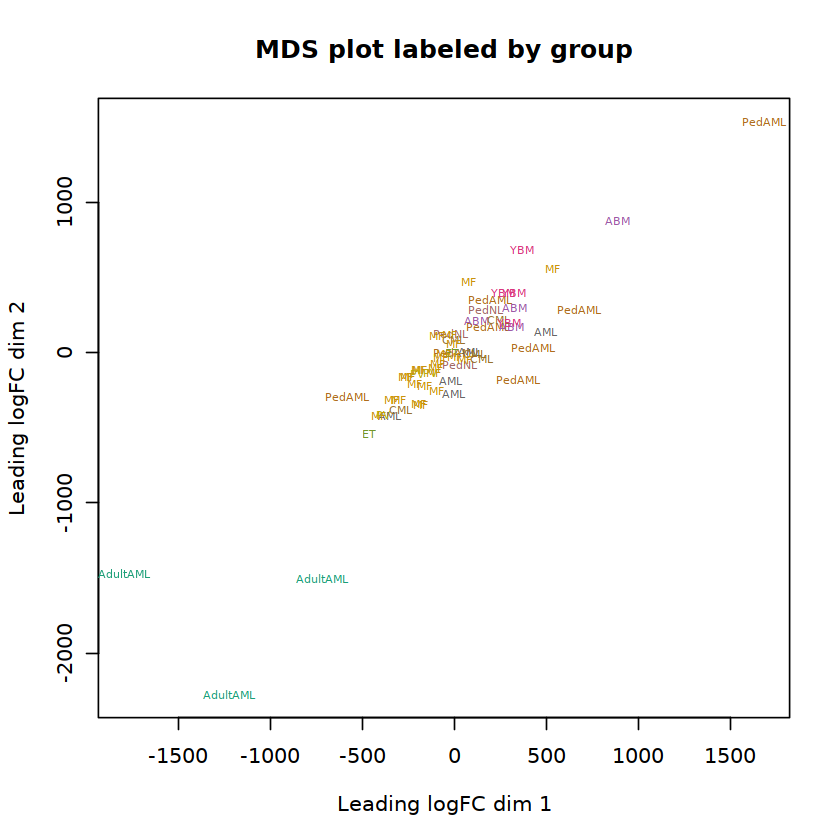

In [111]:
plotMdsColoredByColumn(gNormedFilteredDgeList.prog.merge, "group", c(1,2))
plotMdsColoredByColumn(gNormedFilteredDgeList.stem.merge, "group", c(1,2))

Warning message in brewer.pal(nlevels(col.condition), brewerPaletteName):
“minimal value for n is 3, returning requested palette with 3 different levels
”Warning message in plot.window(...):
“"legend" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"legend" is not a graphical parameter”Warning message in axis(side = side, at = at, labels = labels, ...):
“"legend" is not a graphical parameter”Warning message in axis(side = side, at = at, labels = labels, ...):
“"legend" is not a graphical parameter”Warning message in box(...):
“"legend" is not a graphical parameter”Warning message in title(...):
“"legend" is not a graphical parameter”Warning message in text.default(x$x, x$y, labels = labels, cex = cex, ...):
“"legend" is not a graphical parameter”

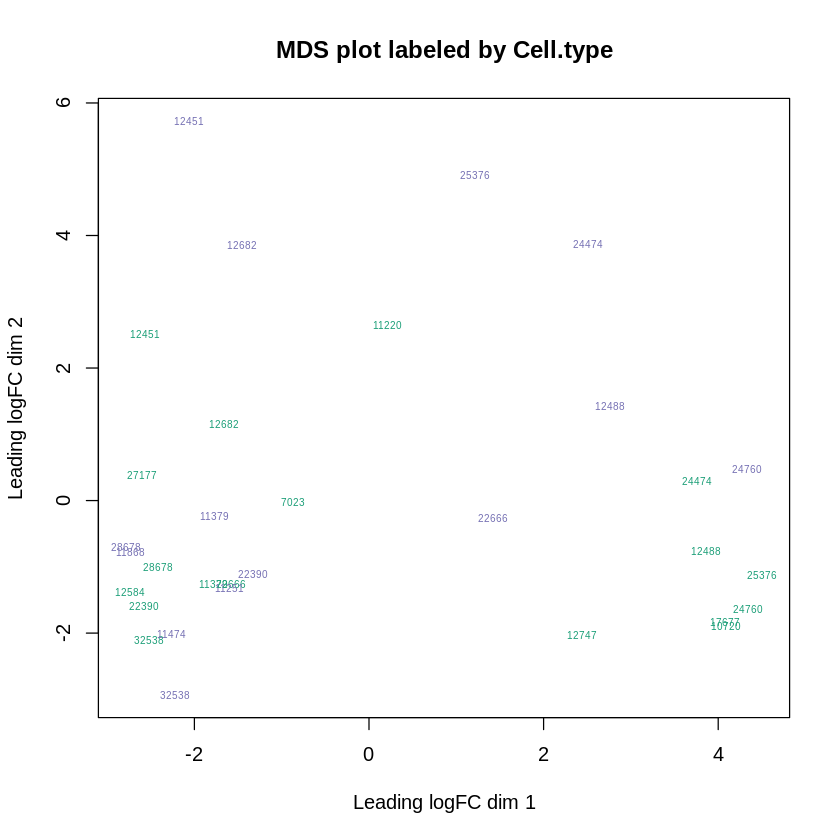

In [48]:
plotMdsColoredByColumn(gNormedFilteredDgeList, "Cell.type", c(1,2), labelColNameInSampleDf = "Patient.ID")
#plotMdsColoredByColumn(gNormedFilteredDgeList.prog, "Cell.type", c(1,2), labelColNameInSampleDf = "Patient.ID")
#plotMdsColoredByColumn(gNormedFilteredDgeList.stem, "Cell.type", c(1,2), labelColNameInSampleDf = "Patient.ID")

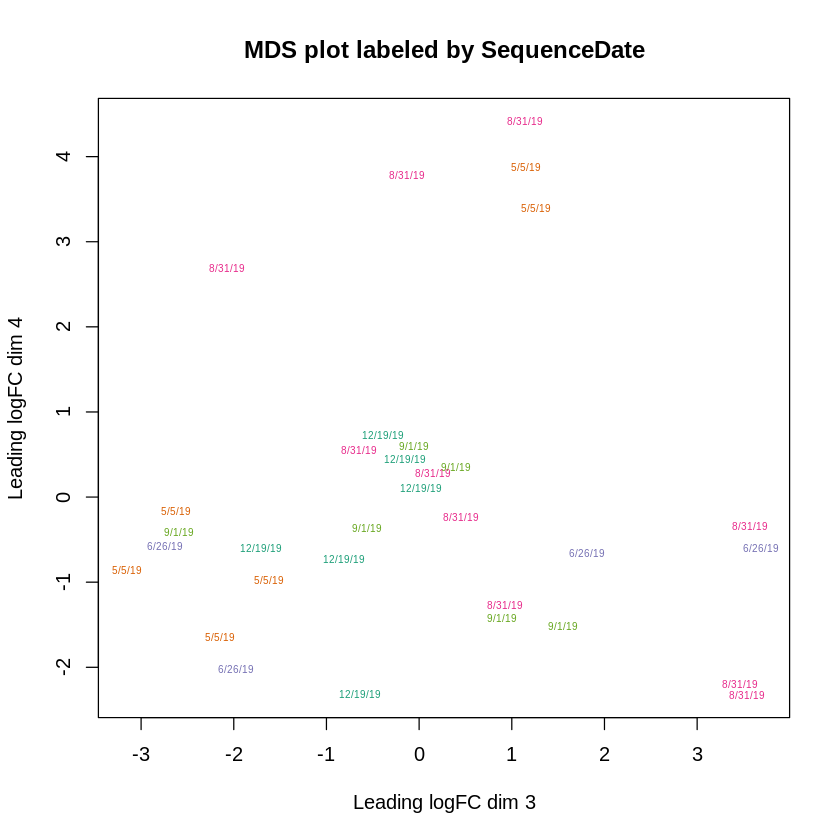

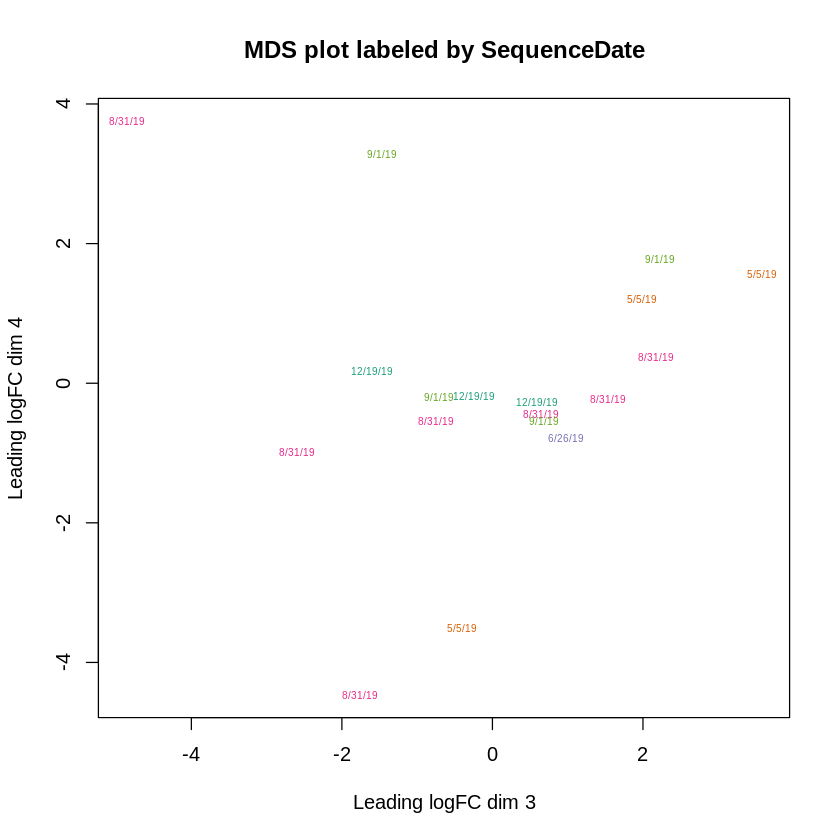

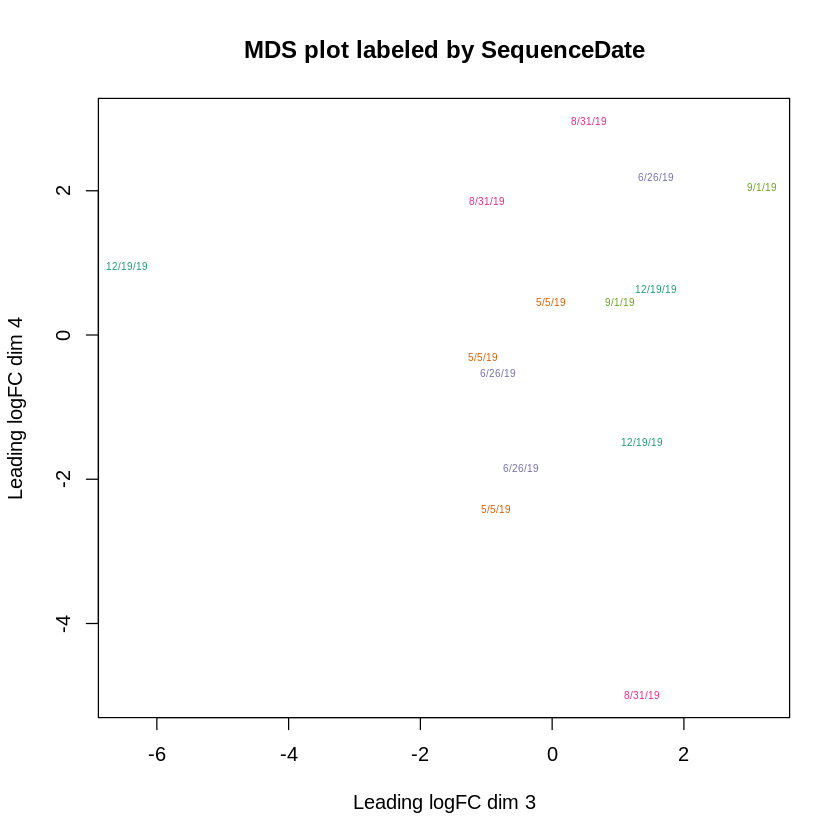

In [56]:
plotMdsColoredByColumn(gNormedFilteredDgeList, "SequenceDate", c(3,4))
plotMdsColoredByColumn(gNormedFilteredDgeList.prog, "SequenceDate", c(3,4))
plotMdsColoredByColumn(gNormedFilteredDgeList.stem, "SequenceDate", c(3,4))

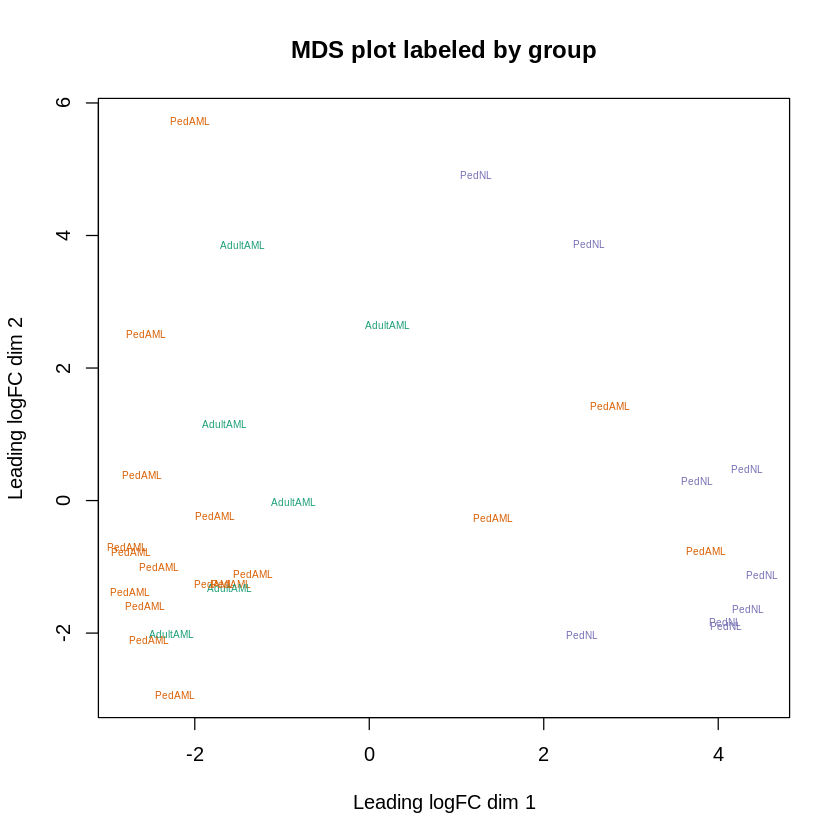

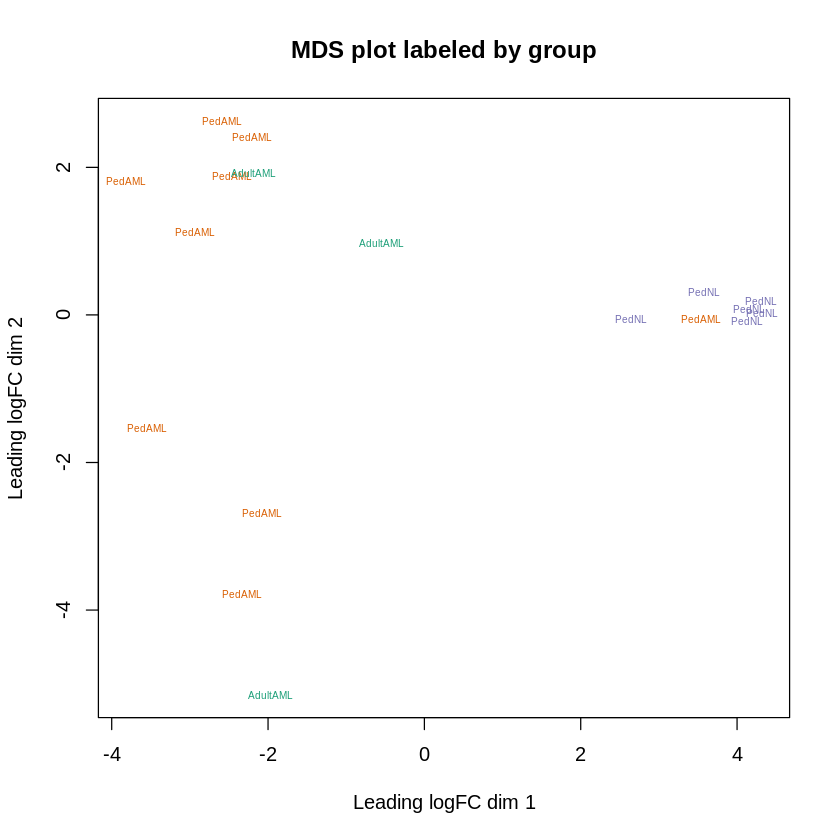

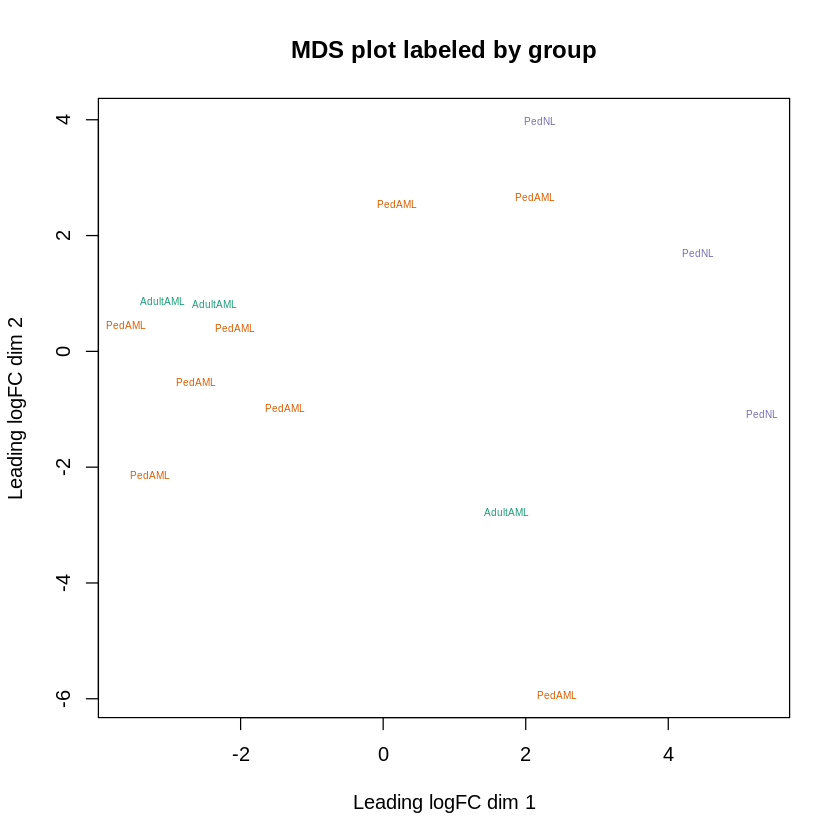

In [57]:
plotMdsColoredByColumn(gNormedFilteredDgeList, "group", c(1,2))
plotMdsColoredByColumn(gNormedFilteredDgeList.prog, "group", c(1,2))
plotMdsColoredByColumn(gNormedFilteredDgeList.stem, "group", c(1,2))

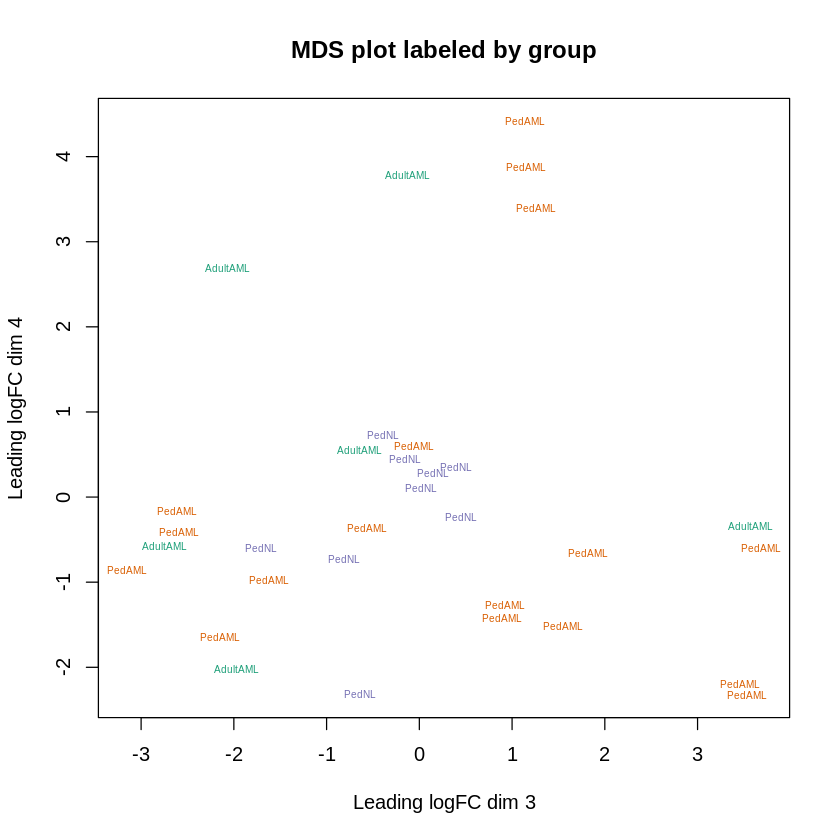

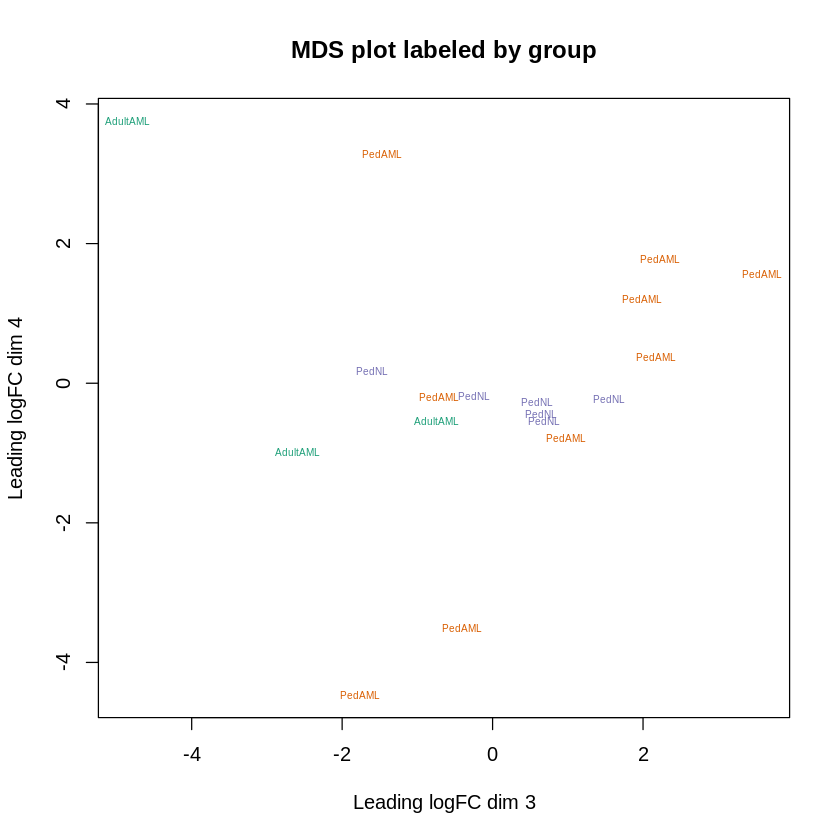

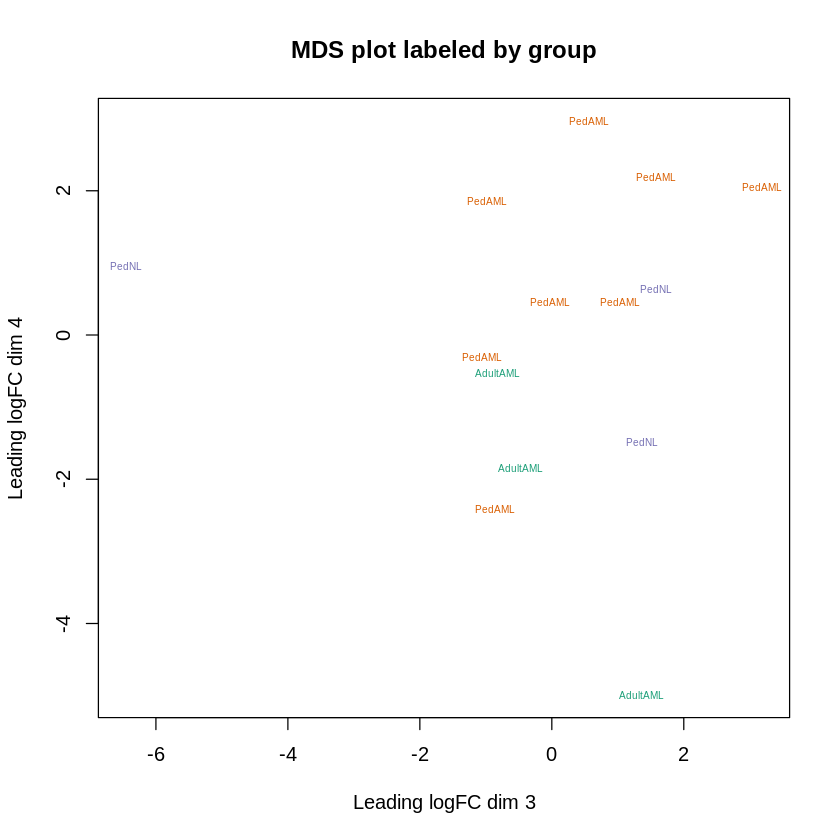

In [58]:
plotMdsColoredByColumn(gNormedFilteredDgeList, "group", c(3,4))
plotMdsColoredByColumn(gNormedFilteredDgeList.prog, "group", c(3,4))
plotMdsColoredByColumn(gNormedFilteredDgeList.stem, "group", c(3,4))

In [9]:
plotMdsColoredByColumn

ERROR: Error in eval(expr, envir, enclos): object 'plotMdsColoredByColumn' not found


    
   > These demonstrate the same good separation of the phenotypes along the main axes of variance; however, a lot of the same sample type were run on the same day which confounds the analysis.

### Interactive MDS plot
The Glimma package ([9](#Citations)) offers the convenience of an interactive MDS plot where multiple dimensions can be explored. The glMDSPlot function generates an html page with an MDS plot in the left panel and a barplot showing the proportion of variation explained by each dimension in the right panel. Clicking on the bars of the bar plot changes the pair of dimensions plotted in the MDS plot, and hovering over the individual points reveals the sample label. 

In [191]:
print(data.frame("column" = colnames(gOrigNormedFilteredDgeList.prog$samples)))
print(data.frame("column" = colnames(gOrigNormedFilteredDgeList.stem$samples)))

             column
1             group
2          lib.size
3      norm.factors
4       SequenceRun
5      SequenceDate
6            Sample
7        SampleName
8        Patient.ID
9               RIN
10                X
11  Adult.Pediatric
12          Disease
13        Cell.type
14 Sorted.Cell.Type
15    Tissue.Source
16   RNA.seq.status
17            Reads
             column
1             group
2          lib.size
3      norm.factors
4       SequenceRun
5      SequenceDate
6            Sample
7        SampleName
8        Patient.ID
9               RIN
10                X
11  Adult.Pediatric
12          Disease
13        Cell.type
14 Sorted.Cell.Type
15    Tissue.Source
16   RNA.seq.status
17            Reads


In [62]:
head(gOrigNormedFilteredDgeList.prog$samples)
gGroupColumnsA = c(1,5,11,13,15)
gGroupColumns = c(1,5,11,15)

,group,lib.size,norm.factors,SequenceRun,SequenceDate,Sample,SampleName,Patient.ID,RIN,X,Adult.Pediatric,Disease,Cell.type,Sorted.Cell.Type,Tissue.Source,RNA.seq.status,Reads
,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
02id38cellPROGENITORS,PedAML,33857287,0.9828611,ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91,5/5/19,02id38cellPROGENITORS,38 Progenitors,32538,9.7,PedAML,Pediatric,AML,Prog,34+38+,PB,Completed,73196851
06id90cellPROGENITORS,PedAML,33182123,0.8321179,ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91,5/5/19,06id90cellPROGENITORS,90 Progenitors,22390,10.0,PedAML,Pediatric,AML,Prog,34+38+,BM,Completed,81721991
04id78cellPROGENITORS,PedAML,41582383,0.9294246,ca_ne_586_001_400_000_JAMIESON_SR_human-ensembl-grch38-r91,5/5/19,04id78cellPROGENITORS,78 Progenitors,28678,10.0,PedAML,Pediatric,AML,Prog,34+38+,PB,Completed,88894032
06id00066PRO,PedAML,30046504,1.1581854,ca_ne_618_001_400_070_JAMIESON_SR_human-ensembl-ghrc38-r91,6/26/19,06id00066PRO,66 Progenitors,22666,9.8,PedAML,Pediatric,AML,Prog,34+38+,BM,Completed,77343883
01x00077xPROGENIT,PedAML,29106100,0.9036754,ca_ne_630_001_400_060_JAMIESON_SN_human-ensembl-grch38-r91,8/31/19,01x00077xPROGENIT,77 Progenitors,27177,9.8,PedAML,Pediatric,AML,Prog,34+38+,BM,Completed,68810108
03x11379xHPCxxxxx,PedAML,42324440,1.0968453,ca_ne_630_001_400_060_JAMIESON_SN_human-ensembl-grch38-r91,8/31/19,03x11379xHPCxxxxx,11379 HPC,11379,9.7,PedAML,Pediatric,AML,Prog,34+38+,PB,Completed,92324550


In [63]:
glMDSPlot(cpm(gOrigNormedFilteredDgeList, log=TRUE), 
          labels = gOrigNormedFilteredDgeList$samples[[gSampleColName]], 
          groups = gOrigNormedFilteredDgeList$samples[,gGroupColumnsA], 
          path = gOutputDir,
          html = sprintf("MDS-Plot_%s_%s", gProjectName, "Progenitors_StemCells"))

In [64]:
glMDSPlot(cpm(gOrigNormedFilteredDgeList.prog, log=TRUE), 
          labels = gOrigNormedFilteredDgeList.prog$samples[[gSampleColName]], 
          groups = gOrigNormedFilteredDgeList.prog$samples[,gGroupColumns], 
          path = gOutputDir,
          html = sprintf("MDS-Plot_%s_%s", gProjectName, "Progenitors"))

In [65]:
glMDSPlot(cpm(gOrigNormedFilteredDgeList.stem, log=TRUE), 
          labels = gOrigNormedFilteredDgeList.stem$samples[[gSampleColName]], 
          groups = gOrigNormedFilteredDgeList.stem$samples[,gGroupColumns], 
          path = gOutputDir,
          html = sprintf("MDS-Plot_%s", gProjectName, "StemCells"))

The Glimma plot opens in a new window of the browser; switch to that window to explore the variance futher.  It is also stored in the "glimma-plots" sub-folder of the output directory for future reference.

Save the workspace objects for future reference:

In [50]:
head(gOrigNormedFilteredDgeList.paired$sample)

ERROR: Error in head(gOrigNormedFilteredDgeList.paired$sample): object 'gOrigNormedFilteredDgeList.paired' not found


In [112]:
writeWorkspaceImage(gInterimDir, paste0(gRunName, "withMPN"))

[1] "Output file: 20200228_DeWerf_Human_PediatricAML_data_exploration_20220902181053withMPN.RData"


[Table of Contents](#Table-of-Contents)

## Summary

<div class="alert alert-warning">
    <strong>Analyst Note: Fill In</strong><br />
    
Replace this cell with a summary of key points from this notebook in this section. This summary should highlight important statistics and draw conclusions for the researcher. An *example* summary is below, which should be replaced with the conclusions from your particular analysis.

> **Library sizes**
* These numbers are somewhat small, given that the raw fastq files for the samples contained 26.5 to 50.0 million reads each (see primary analysis); the researchers may wish to investigate the cause for this attrition.  However, these library sizes should be adequate to give gene-level differential expression findings. 

> **Removal of low-alignment samples**
* The following samples were excluded because they did not meet the 10M reads per sample threshold: S1, S8, S9

> **Raw counts visualization observations**
* This indicates that even before normalization, the primary variance in the data (approximately 35%) separates the samples in a way consistent with time point.  This is encouraging!

OR


> * This indicates that before normalization, the primary variance in the data is driven by library size.  This is unsurprising but highlights the necessity for normalization below.

> **Genes filtered due to no/low counts**
* Approximately 2100 of the genes in the dataset are missing from reads found in samples (that is, not found to be expressed in any of the samples). 
* Discarding lowly expressed genes reduces the number of genes in the dataset from 20345 to 14454.

> **CPM threshold**
* Genes having a CPM of greater than 1 for greater than or equal to 3 samples (chosen as this is the smallest group size in this experiment) will be retained for further analysis, while all others will be discarded.

> **Notes on normalization**
* The above analysis shows that, after library size normalization, an even greater percentage of the variance is consistent with differences between days, and that different samples for the same day cluster closely.  However, the day 5 samples do not appear intermediate to the day 0 and day 10 samples on either of the first two principal components.
   
OR 
   
> * This indicates that normalization appears to have removed library size as the primary variance driver in the data.  The controls appear fairly localized, while the mild samples are spread out primarily along the first principal component and the severe samples are spread out along both principal component 1 and 2, including two rather extreme values.

> **Removal of outliers**
* No outliers were removed from the analysis.

OR

> * (List of samples) were outliers in the PCA/MDS plot and were removed from the analysis.

>**Notes on MDS plots**
* The MDS plots demonstrate the same good separation of time points along the main axes of variance, and show the day 5 samples as more integrated in the gradient of the first axis. However, the second axis appears to largely separate day 10 from the remainder of the time points.  It is worth noting that day 10 has two (out of three) samples with very low library sizes, which might contribute to this separation.

</div>

[Table of Contents](#Table-of-Contents)

## Citations

1. Law CW, Alhamdoosh M, Su S, Smyth GK, Ritchie ME. RNA-seq analysis is easy as 1-2-3 with limma, Glimma and edgeR. Version 2. F1000Res. 2016 Jun 17 [revised 2016 Jan 1];5:1408.
2. Ritchie, ME, Phipson, B, Wu, D, Hu, Y, Law, CW, Shi, W, and Smyth, GK (2015). limma powers differential expression analyses for RNA-sequencing and microarray studies. Nucleic Acids Research 43(7), e47.
3. Robinson MD, McCarthy DJ and Smyth GK (2010). edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics 26, 139-140.
4. Huber W, Carey VJ, Gentleman R, Anders S, Carlson M, Carvalho BS, Bravo HC, Davis S, Gatto L, Girke T, Gottardo R, Hahne F, Hansen KD, Irizarry RA, Lawrence M, Love MI, MacDonald J, Obenchain V, Oleś AK, Pagès H, Reyes A, Shannon P, Smyth GK, Tenenbaum D, Waldron L, Morgan M. Orchestrating high-throughput genomic analysis with Bioconductor. Nat Methods. 2015 Feb;12(2):115-21.
5. R Core Team (2016). R: A language and environment for statistical computing. R Foundation for Statistical Computing, Vienna, Austria. URL https://www.R-project.org/.
6. https://support.bioconductor.org/p/69433/#69441
7. Dillies MA, Rau A, Aubert J, Hennequet-Antier C, Jeanmougin M, Servant N, Keime C, Marot G, Castel D, Estelle J, Guernec G, Jagla B, Jouneau L, Laloë D, Le Gall C, Schaëffer B, Le Crom S, Guedj M, Jaffrézic F; French StatOmique Consortium. A comprehensive evaluation of normalization methods for Illumina high-throughput RNA sequencing data analysis. Brief Bioinform. 2013 Nov;14(6):671-83.
8. Robinson MD, Oshlack A. A scaling normalization method for differential expression analysis of RNA-seq data. Genome Biol. 2010;11(3):R25.
9. Su S, Law CW, Ah-Cann C, Asselin-Labat M, Blewitt ME, Ritchie ME (2017). Glimma: interactive graphics for gene expression analysis. Bioinformatics, 33(13), 2050-2052.

[Table of Contents](#Table-of-Contents)

## Appendix: R Session Info

In [112]:
Sys.time()
sessionInfo()

[1] "2020-03-06 11:10:29 PST"

R version 3.4.3 (2017-11-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS: /mnt/data1/tomw/anaconda2/lib/R/lib/libRblas.so
LAPACK: /mnt/data1/tomw/anaconda2/lib/R/lib/libRlapack.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] RColorBrewer_1.1-2   cowplot_0.9.4        ggplot2_3.1.1       
[4] IRdisplay_0.7.0      Glimma_1.6.0         edgeR_3.20.9        
[7] limma_3.34.9         RevoUtils_10.0.8     RevoUtilsMath_10.0.1

loaded via a namespace (and not attached):
 [1] Biobase_2.38.0             httr_1.4.0                
 [3] RMySQL_0.10.17             bit64_0.9-7               
 [5] jsonlite_1.6               assertthat_0.2.1          
 [7] stats4_3.4.3               RBGL_1.54.0               
 [9] blob_1.1.1                 GenomeInfoDbData_1.0.0    
[11] Rsamtools_1.30.0           progress_1.2.2          

[Table of Contents](#Table-of-Contents)

Copyright (c) 2018 UC San Diego Center for Computational Biology & Bioinformatics under the MIT License

Notebook template by Amanda Birmingham